In [1]:
from collections import defaultdict
from os.path import join as pjoin
from time import time
from glob import glob
from typing import Mapping, Any, Optional
import re
import numpy as np
import os
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from textworld import EnvInfos
from gg_pretrained import ggModel
import textworld.gym

In [2]:
# PATH = pjoin(os.path.dirname(__file__), 'textworld_data')
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_command_score(command):
    score = 0
    if command in commands_gg_score_map:
        score = commands_gg_score_map[command]
    else:
        gg_result = gg_model.get_score(command)
        score = gg_result[0][1]
        commands_gg_score_map[command] = score
    
    return score

In [3]:
def get_commands_score(commands):
    score = []
    for command in commands:
        if command in commands_gg_score_map:
            score.append(commands_gg_score_map[command])
        else:
            gg_result = gg_model.get_score(command)
            gg_score = gg_result[0][1]
            score.append(gg_score)
            commands_gg_score_map[command] = gg_score
    score = np.array(score)
    score = score.reshape(1,1,-1)
    score_r = torch.from_numpy(score)
    return score_r

In [4]:
class ActorzCritic(nn.Module):

    eps = 0.01

    def __init__(self, input_size, hidden_size):
        super(ActorzCritic, self).__init__()
        torch.manual_seed(42)  # For reproducibility
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.encoder_gru = nn.GRU(hidden_size, hidden_size)
        self.cmd_encoder_gru = nn.GRU(hidden_size, hidden_size)
        self.state_gru = nn.GRU(hidden_size, hidden_size)

        self.linear_1 = nn.Linear(2 * hidden_size, 2 * hidden_size)
        self.critic = nn.Linear(hidden_size, 1)
        self.actor = nn.Linear(hidden_size * 2, 1)

        # Parameters
        self.state_hidden = torch.zeros(1, 1, hidden_size, device=device)
        self.hidden_size = hidden_size

    def forward(self, obs, commands, command_scores, mode, method):
        input_length, batch_size = obs.size(0), obs.size(1)
        nb_cmds = commands.size(1)

        embedded = self.embedding(obs)
        encoder_output, encoder_hidden = self.encoder_gru(embedded)

        state_output, state_hidden = self.state_gru(encoder_hidden, self.state_hidden)
        self.state_hidden = state_hidden
        state_value = self.critic(state_output)

        # Attention network over the commands.
        cmds_embedding = self.embedding.forward(commands)
        _, cmds_encoding_last_states = self.cmd_encoder_gru.forward(cmds_embedding)  # 1*cmds*hidden

        # Same observed state for all commands.
        cmd_selector_input = torch.stack([state_hidden] * nb_cmds, 2)  # 1*batch*cmds*hidden

        # Same command choices for the whole batch.
        cmds_encoding_last_states = torch.stack([cmds_encoding_last_states] * batch_size, 1)  # 1*batch*cmds*hidden

        # Concatenate the observed state and command encodings.
        input_ = torch.cat([cmd_selector_input, cmds_encoding_last_states], dim=-1)

        # One FC layer
        x = F.relu(self.linear_1(input_))

        # Compute state-action value (score) per command.
        action_state = F.relu(self.actor(x)).squeeze(-1)  # 1 x Batch x cmds
        print("action_state: ", action_state)
        action_state = action_state * command_scores
        print("action_state_1: ", action_state)
        # action_state = F.relu(self.actor(input_)).squeeze(-1)  # 1 x Batch x cmds

        probs = F.softmax(action_state, dim=2)  # 1 x Batch x cmds
        print("probs_0: ", probs)
#         probs = probs * command_scores
#         print("probs_1: ", probs)

        if mode == "train":
            action_index = probs[0].multinomial(num_samples=1).unsqueeze(0)  # 1 x batch x indx
        elif mode == "test":
            if method == 'random':
                action_index = probs[0].multinomial(num_samples=1).unsqueeze(0)  # 1 x batch x indx
            elif method == 'arg-max':
                action_index = probs[0].max(1).indices.unsqueeze(-1).unsqueeze(-1)  # 1 x batch x indx
            elif method == 'eps-soft':
                index = probs[0].max(1).indices.unsqueeze(-1).unsqueeze(-1)
                p = np.random.random()
                if p < (1 - self.eps + self.eps / nb_cmds):
                    action_index = index
                else:
                    while True:
                        tp = np.random.choice(probs[0][0].detach().numpy())
                        if (probs[0][0] == tp).nonzero().unsqueeze(-1) != index:
                            action_index = (probs[0][0] == tp).nonzero().unsqueeze(-1)
                            break

        return action_state, action_index, state_value

    def reset_hidden(self, batch_size):
        self.state_hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)

In [5]:

class NeuralAgent:
    """ Simple Neural Agent for playing TextWorld games. """

    MAX_VOCAB_SIZE = 1000
    UPDATE_FREQUENCY = 10
    LOG_FREQUENCY = 1000
    GAMMA = 0.9

    def __init__(self) -> None:
        self.id2word = ["<PAD>", "<UNK>"]
        self.word2id = {w: i for i, w in enumerate(self.id2word)}

        self.model = ActorzCritic(input_size=self.MAX_VOCAB_SIZE, hidden_size=128)
        self.optimizer = optim.Adam(self.model.parameters(), 0.00003)

    def train(self):
        self.mode = "train"
        self.method = "random"
        self.transitions = []
        self.last_score = 0
        self.no_train_step = 0
        self.stats = {"max": defaultdict(list), "mean": defaultdict(list)}
        self.memo = {"max": defaultdict(list), "mean": defaultdict(list), "mem": defaultdict(list)}
        self.model.reset_hidden(1)

    def test(self, method):
        self.mode = "test"
        self.method = method
        self.model.reset_hidden(1)

    @property
    def infos_to_request(self) -> EnvInfos:
        return EnvInfos(description=True, inventory=True, admissible_commands=True, won=True, lost=True)

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> Optional[str]:
        # Build agent's observation: feedback + look + inventory.
        input_ = "{}\n{}\n{}".format(obs, infos["description"], infos["inventory"])

        # Tokenize and pad the input and the commands to chose from.
        input_tensor = self._process([input_])
        commands_tensor = self._process(infos["admissible_commands"])
        command_scores = get_commands_score(infos["admissible_commands"])

        # Get our next action and value prediction.
        outputs, indexes, values = self.model(input_tensor, commands_tensor, command_scores, mode=self.mode, method=self.method)
        action = infos["admissible_commands"][indexes[0]]

        if self.mode == "test":
            if done:
                self.model.reset_hidden(1)
            return action

        self.no_train_step += 1

        if self.transitions:
            reward = score - self.last_score  # Reward is the gain/loss in score.
            self.last_score = score
            if infos["won"]:
                reward += 100
            if infos["lost"]:
                reward -= 100

            self.transitions[-1][0] = reward  # Update reward information.

        self.stats["max"]["score"].append(score)
        self.memo["max"]["score"].append(score)

        if self.no_train_step % self.UPDATE_FREQUENCY == 0:
            # Update model
            returns, advantages = self._discount_rewards(values)

            loss = 0
            for transition, ret, advantage in zip(self.transitions, returns, advantages):
                reward, indexes_, outputs_, values_ = transition

                advantage = advantage.detach()  # Block gradients flow here.
                probs = F.softmax(outputs_, dim=2)
                log_probs = torch.log(probs)
                log_action_probs = log_probs.gather(2, indexes_)
                policy_loss = (log_action_probs * advantage).sum()
                value_loss = ((values_ - ret) ** 2.).sum()
                entropy = (-probs * log_probs).sum()
                loss += 0.5 * value_loss - policy_loss - 0.001 * entropy

                self.memo["mem"]["selected_action_index"].append(indexes_.item())
                self.memo["mem"]["state_val_func"].append(values_.item())
                self.memo["mem"]["advantage"].append(advantage.item())
                self.memo["mem"]["return"].append(ret.item())
                self.memo["mean"]["reward"].append(reward)
                self.memo["mean"]["policy_loss"].append(policy_loss.item())
                self.memo["mean"]["value_loss"].append(value_loss.item())

                self.stats["mean"]["reward"].append(reward)
                self.stats["mean"]["policy_loss"].append(policy_loss.item())
                self.stats["mean"]["value_loss"].append(value_loss.item())
                self.stats["mean"]["entropy"].append(entropy.item())
                self.stats["mean"]["confidence"].append(torch.exp(log_action_probs).item())

            if self.no_train_step % self.LOG_FREQUENCY == 0:
                msg = "{}. ".format(self.no_train_step)
                msg += "  ".join("{}: {:.3f}".format(k, np.mean(v)) for k, v in self.stats["mean"].items())
                msg += "  " + "  ".join("{}: {}".format(k, np.max(v)) for k, v in self.stats["max"].items())
                msg += "  vocab: {}".format(len(self.id2word))
                print(msg)
                self.stats = {"max": defaultdict(list), "mean": defaultdict(list)}

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(self.model.parameters(), 40)
            self.optimizer.step()
            self.optimizer.zero_grad()

            self.transitions = []
            self.model.reset_hidden(1)
        else:
            # Keep information about transitions for Truncated Backpropagation Through Time.
            self.transitions.append([None, indexes, outputs, values])  # Reward will be set on the next call

        if done:
            self.last_score = 0  # Will be starting a new episode. Reset the last score.

        return action

    def _process(self, texts):
        texts = list(map(self._tokenize, texts))
        max_len = max(len(l) for l in texts)
        padded = np.ones((len(texts), max_len)) * self.word2id["<PAD>"]

        for i, text in enumerate(texts):
            padded[i, :len(text)] = text

        padded_tensor = torch.from_numpy(padded).type(torch.long).to(device)
        padded_tensor = padded_tensor.permute(1, 0)  # Batch x Seq => Seq x Batch
        return padded_tensor

    def _tokenize(self, text):
        # Simple tokenizer: strip out all non-alphabetic characters.
        text = re.sub("[^a-zA-Z0-9\- ]", " ", text)
        word_ids = list(map(self._get_word_id, text.split()))
        return word_ids

    def _get_word_id(self, word):
        if word not in self.word2id:
            if len(self.word2id) >= self.MAX_VOCAB_SIZE:
                return self.word2id["<UNK>"]

            self.id2word.append(word)
            self.word2id[word] = len(self.word2id)

        return self.word2id[word]

    def _discount_rewards(self, last_values):
        returns, advantages = [], []
        R = last_values.data
        for t in reversed(range(len(self.transitions))):
            rewards, _, _, values = self.transitions[t]
            R = rewards + self.GAMMA * R
            adv = R - values
            returns.append(R)
            advantages.append(adv)

        return returns[::-1], advantages[::-1]

In [6]:

def play(agent, path, max_step=50, nb_episodes=10, verbose=True):
    """
        This code uses the cooking agent design in the spaceship game.

        :param agent: the obj of NeuralAgent, a sample object for the agent
        :param path: The path to the game (envo model)
    """

    infos_to_request = agent.infos_to_request
    infos_to_request.max_score = True  # Needed to normalize the scores.

    gamefiles = [path]
    if os.path.isdir(path):
        gamefiles = glob(os.path.join(path, "*.ulx"))

    env_id = textworld.gym.register_games(gamefiles,
                                          request_infos=infos_to_request,
                                          max_episode_steps=max_step)
    env = gym.make(env_id)  # Create a Gym environment to play the text game.

    if verbose:
        if os.path.isdir(path):
            print(os.path.dirname(path), end="")
        else:
            print(os.path.basename(path), end="")

    # Collect some statistics: nb_steps, final reward.
    avg_moves, avg_scores, avg_norm_scores, seed_h = [], [], [], 4567
    for no_episode in range(nb_episodes):
        print("episode: ", no_episode)
        obs, infos = env.reset()  # Start new episode.

        env.env.textworld_env._wrapped_env.seed(seed=seed_h)
        seed_h += 1

        score = 0
        done = False
        nb_moves = 0
        while not done:
            command = agent.act(obs, score, done, infos)
            print("command -> ", command)
            obs, score, done, infos = env.step(command)
            nb_moves += 1
        agent.act(obs, score, done, infos)  # Let the agent know the game is done.

        if verbose:
            print(".", end="")
        avg_moves.append(nb_moves)
        avg_scores.append(score)
        avg_norm_scores.append(score / infos["max_score"])
        print("episode_score: ",score)

    env.close()
    msg = "  \tavg. steps: {:5.1f}; avg. score: {:4.1f} / {}."
    if verbose:
        if os.path.isdir(path):
            print(msg.format(np.mean(avg_moves), np.mean(avg_norm_scores), 1))
        else:
            print(avg_scores)
            print(msg.format(np.mean(avg_moves), np.mean(avg_scores), infos["max_score"]))


In [7]:
game_path = "./tw_games/super_hero_6.ulx"
agent = NeuralAgent()
gg_model = ggModel()
commands_gg_score_map = dict()
step_size = 750

print(" =====  Training  ===================================================== ")
agent.train()  # Tell the agent it should update its parameters.
start_time = time()
# print(os.path.realpath("./games/levelMedium_v1.ulx"))
print(os.path.realpath(game_path))
# play(agent, "./games/levelMedium_v1.ulx", max_step=step_size, nb_episodes=2000, verbose=False)
play(agent, game_path, max_step=step_size, nb_episodes=2000, verbose=False)
print("Trained in {:.2f} secs".format(time() - start_time))

print(' =====  Test  ========================================================= ')
agent.test(method='arg-max')
# play(agent, "./games/levelMedium_v1.ulx", max_step=step_size)  # Medium level game.
play(agent, game_path, max_step=step_size)  # Medium level game.

save_path = "./model/levelMedium_v1_random.npy"
if not os.path.exists(os.path.dirname(save_path)):
    os.mkdir(os.path.dirname(save_path))

np.save(save_path, agent)

 =====  Training  ===================================================== 
/media/nahian/Media/CORGI_Projects/Learning_from_story/LNFStories_gitrepo/Learning_from_stories/tw_games/super_hero_6.ulx
episode:  0


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]

action_state:  tensor([[[0.0614, 0.0053, 0.0748]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2199, 0.0190, 0.2671]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3489, 0.2854, 0.3658]]], grad_fn=<SoftmaxBackward>)
command ->  go east



100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


action_state:  tensor([[[0.0000, 0.0239, 0.0044, 0.0360, 0.0278, 0.0558, 0.0551, 0.0509,
          0.0412, 0.0441, 0.0000, 0.0769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0898, 0.0163, 0.1333, 0.0883, 0.1998, 0.1966, 0.1763,
          0.1463, 0.1588, 0.0000, 0.2747]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0734, 0.0803, 0.0746, 0.0839, 0.0802, 0.0896, 0.0894, 0.0876,
          0.0850, 0.0860, 0.0734, 0.0966]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0000, 0.0248, 0.0060, 0.0371, 0.0310, 0.0572, 0.0571, 0.0528,
          0.0423, 0.0471, 0.0000, 0.0778]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0931, 0.0225, 0.1374, 0.0985, 0.2048, 0.2037, 0.1829,
          0.1503, 0.1697, 0.0000, 0.2780]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0730, 0.0802, 0.0747, 0.0838, 0.0806, 0.0896, 0.0895, 0.0877,
          0.0849, 0.0865, 0.0730, 0.0964]]], grad_fn=<SoftmaxBackward>)
command ->  go w

/home/nahian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


command ->  wait
action_state:  tensor([[[0.0553, 0.0061, 0.0787]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1981, 0.0218, 0.2811]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3419, 0.2866, 0.3715]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0597, 0.0091, 0.0803]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2136, 0.0329, 0.2870]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3435, 0.2868, 0.3697]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0623, 0.0102, 0.0798]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2230, 0.0368, 0.2849]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3455, 0.2868, 0.3676]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0630, 0.0101, 0.0793]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2256, 0.0364, 0.2833]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3464, 0.2867, 0.3670]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.0184, 0.0000, 0.0324, 0.0240, 0.0446, 0.0499, 0.0398,
          0.0316, 0.0393, 0.0000, 0.0728]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0694, 0.0000, 0.1199, 0.0761, 0.1598, 0.1781, 0.1378,
          0.1124, 0.1416, 0.0000, 0.2600]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0748, 0.0802, 0.0748, 0.0844, 0.0808, 0.0878, 0.0894, 0.0859,
          0.0837, 0.0862, 0.0748, 0.0971]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0143, 0.0000, 0.0309, 0.0134, 0.0396, 0.0458, 0.0371,
          0.0317, 0.0324, 0.0000, 0.0702]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0539, 0.0000, 0.1146, 0.0426, 0.1418, 0.1634, 0.1284,
          0.1128, 0.1168, 0.0000, 0.2508]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0757, 0.0799, 0.0757, 0.0849, 0.0790, 0.0872, 0.0891, 0.0860,
          0.0847, 0.0850, 0.0757, 0.0972]]], grad_fn=<SoftmaxBackward>)
command ->  go east
actio

100%|██████████| 1/1 [00:00<00:00, 15.42it/s]

action_state:  tensor([[[0.0000, 0.0000, 0.0225, 0.0000, 0.0231, 0.0016, 0.0301, 0.0380,
          0.0232, 0.0163, 0.0300, 0.0000, 0.0627]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.0000, -0.0796,  0.0000,  0.0856,  0.0052,  0.1078,
           0.1356,  0.0804,  0.0579,  0.1080,  0.0000,  0.2238]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0725, 0.0725, 0.0670, 0.0725, 0.0790, 0.0729, 0.0808, 0.0831,
          0.0786, 0.0769, 0.0808, 0.0725, 0.0907]]], grad_fn=<SoftmaxBackward>)
command ->  go north



100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


action_state:  tensor([[[0.0000, 0.0392, 0.0000, 0.0015, 0.0133, 0.0082, 0.0288, 0.0542]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.1205, -0.0000,  0.0019,  0.0460,  0.0297, -0.1044,
           0.1937]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1202, 0.1356, 0.1202, 0.1204, 0.1258, 0.1238, 0.1082, 0.1459]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  7
action_state:  tensor([[[0.0394, 0.0044, 0.0743]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1412, 0.0159, 0.2653]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3317, 0.2927, 0.3756]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0440, 0.0000, 0.0807]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1577, 0.0000, 0.2883]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3340, 0.2853, 0.3806]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0462, 0.0022, 0.0814]]], grad_fn=<SqueezeBackward1>)
action_s

episode_score:  0
episode:  9
action_state:  tensor([[[0.0396, 0.0030, 0.0832]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1417, 0.0109, 0.2971]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3284, 0.2881, 0.3836]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0411, 0.0052, 0.0840]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1472, 0.0187, 0.2999]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3285, 0.2889, 0.3827]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0235, 0.0000, 0.0425, 0.0260, 0.0441, 0.0529, 0.0364,
          0.0341, 0.0453, 0.0000, 0.0802]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0884, 0.0000, 0.1573, 0.0825, 0.1579, 0.1889, 0.1259,
          0.1211, 0.1630, 0.0000, 0.2864]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0741, 0.0809, 0.0741, 0.0867, 0.0805, 0.0867, 0.0895, 0.0840,
          0.0836, 0.0872, 0.0741, 0.0986]]], grad_fn=<SoftmaxB

100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


action_state:  tensor([[[0.0285, 0.0036, 0.0210, 0.0090, 0.0720, 0.0241, 0.0306, 0.0219,
          0.0277, 0.0286, 0.0000, 0.0400]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1004,  0.0134,  0.0777,  0.0288,  0.2551,  0.0862,  0.1091,
           0.0757,  0.0983,  0.1031,  0.0000,  0.1430]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0697, 0.0782, 0.0833, 0.0794, 0.0995, 0.0841, 0.0860, 0.0832,
          0.0851, 0.0855, 0.0771, 0.0890]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0218, 0.0000, 0.0148, 0.0024, 0.0731, 0.0176, 0.0251, 0.0165,
          0.0205, 0.0228, 0.0000, 0.0336]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0768,  0.0000,  0.0549,  0.0076,  0.2591,  0.0629,  0.0896,
           0.0571,  0.0729,  0.0822,  0.0000,  0.1201]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0724, 0.0782, 0.0826, 0.0788, 0.1013, 0.0832, 0.0855, 0.0828,
          0.0841, 0.0849, 0.0782, 0.0881]]], grad_fn

100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


action_state:  tensor([[[0.0000, 0.0358, 0.0023, 0.0000, 0.0791]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.1281, 0.0084, 0.0000, 0.2824]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1828, 0.2078, 0.1843, 0.1828, 0.2424]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot
action_state:  tensor([[[0.0000, 0.0262, 0.0000, 0.0610]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0936, 0.0000, 0.2179]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2303, 0.2529, 0.2303, 0.2864]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0225, 0.0000, 0.0158, 0.0031, 0.0752, 0.0180, 0.0241, 0.0181,
          0.0211, 0.0218, 0.0000, 0.0344]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0795,  0.0000,  0.0584,  0.0098,  0.2665,  0.0646,  0.0862,
           0.0627,  0.0749,  0.0787,  0.0000,  0.1230]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0721, 0.0781, 0.0828, 0.0788, 0.1019, 0.0833, 0.0

command ->  examine oven
action_state:  tensor([[[0.0000, 0.0093, 0.0000, 0.0091, 0.0000, 0.0063, 0.0179, 0.0046,
          0.0047, 0.0170, 0.0000, 0.0489]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.0000, -0.0327,  0.0000,  0.0338,  0.0000,  0.0224,  0.0637,
           0.0160,  0.0167,  0.0613,  0.0000,  0.1745]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0808, 0.0782, 0.0808, 0.0836, 0.0808, 0.0826, 0.0861, 0.0821,
          0.0822, 0.0859, 0.0808, 0.0962]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.0000, 0.0896, 0.0000, 0.0591]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3198, 0.0000, 0.2111]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2168, 0.2986, 0.2168, 0.2678]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  11
action_state:  tensor([[[0.0335, 0.0100, 0.0766]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1201, 0.0361, 0.2736]]], grad_fn=<MulBackward0>)
probs_0:  t

action_state:  tensor([[[0.0376, 0.0027, 0.0761]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1345, 0.0099, 0.2717]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3300, 0.2914, 0.3786]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0098, 0.0000, 0.0312, 0.0102, 0.0280, 0.0407, 0.0213,
          0.0226, 0.0339, 0.0000, 0.0698]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0367, 0.0000, 0.1155, 0.0324, 0.1001, 0.1454, 0.0738,
          0.0805, 0.1221, 0.0000, 0.2493]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0768, 0.0796, 0.0768, 0.0862, 0.0793, 0.0848, 0.0888, 0.0826,
          0.0832, 0.0867, 0.0768, 0.0985]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.0146, 0.0000, 0.0361, 0.0149, 0.0315, 0.0437, 0.0215, 0.0228,
          0.0381, 0.0000, 0.0740]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0551, 0.0000, 0.1337, 0.0473, 0.1129, 0.1558, 0.0745,

command ->  wait
action_state:  tensor([[[0.0254, 0.0000, 0.0724]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0908, 0.0000, 0.2585]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3230, 0.2950, 0.3820]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0250, 0.0000, 0.0722]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0896, 0.0000, 0.2577]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3229, 0.2952, 0.3820]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0060, 0.0000, 0.0285, 0.0065, 0.0192, 0.0328, 0.0069,
          0.0103, 0.0304, 0.0000, 0.0630]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0227, 0.0000, 0.1056, 0.0208, 0.0686, 0.1169, 0.0238,
          0.0365, 0.1094, 0.0000, 0.2249]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0783, 0.0800, 0.0783, 0.0870, 0.0799, 0.0838, 0.0880, 0.0801,
          0.0812, 0.0873, 0.0783, 0.0980]]], grad_fn=<SoftmaxBackward>)
com

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.0000, 0.0185, 0.0000, 0.0058, 0.0243, 0.0000, 0.0044,
          0.0184, 0.0000, 0.0536]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.0685, 0.0000, 0.0209, 0.0868, 0.0000, 0.0156,
          0.0664, 0.0000, 0.1915]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0871, 0.0871, 0.0933, 0.0871, 0.0890, 0.0950, 0.0871, 0.0885,
          0.0931, 0.0871, 0.1055]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0142, 0.0000, 0.0676]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0507, 0.0000, 0.2413]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3164, 0.3008, 0.3828]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0215, 0.0000, 0.0065, 0.0229, 0.0000, 0.0000,
          0.0200, 0.0000, 0.0532]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.0798, 0.0000, 0.0232, 0.0818, 0.0000, 0.0000,
  

episode_score:  0
episode:  21
action_state:  tensor([[[0.0116, 0.0000, 0.0687]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0417, 0.0000, 0.2453]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3140, 0.3012, 0.3849]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0227, 0.0000, 0.0058, 0.0251, 0.0000,
          0.0016, 0.0210, 0.0000, 0.0553]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.0842, 0.0000, 0.0208, 0.0894, 0.0000,
          0.0059, 0.0757, 0.0000, 0.1974]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0800, 0.0800, 0.0800, 0.0870, 0.0800, 0.0816, 0.0874, 0.0800,
          0.0804, 0.0863, 0.0800, 0.0974]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0281, 0.0000, 0.0667]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0999, 0.0000, 0.2383]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3275, 0.2964, 0.3761]]], grad_fn=<Soft

command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0199, 0.0000, 0.0008, 0.0238, 0.0000, 0.0029,
          0.0187, 0.0000, 0.0520]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.0736, 0.0000, 0.0030, 0.0849, 0.0000, 0.0104,
          0.0672, 0.0000, 0.1859]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0873, 0.0873, 0.0940, 0.0873, 0.0876, 0.0951, 0.0873, 0.0882,
          0.0934, 0.0873, 0.1052]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0297, 0.0000, 0.0687]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1057, 0.0000, 0.2456]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3279, 0.2950, 0.3771]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  24
action_state:  tensor([[[0.0017, 0.0000, 0.0666]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0060, 0.0000, 0.2379]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3072, 0.3054, 0.3874]]], grad_fn=<SoftmaxBackward>)
command -> 

command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0226, 0.0000, 0.0000, 0.0247, 0.0000,
          0.0032, 0.0208, 0.0000, 0.0535]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.0839, 0.0000, 0.0000, 0.0880, 0.0000,
          0.0113, 0.0749, 0.0000, 0.1911]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0801, 0.0801, 0.0801, 0.0871, 0.0801, 0.0801, 0.0875, 0.0801,
          0.0810, 0.0864, 0.0801, 0.0970]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.0010, 0.0000, 0.0272, 0.0000, 0.0007, 0.0258, 0.0000,
          0.0011, 0.0230, 0.0000, 0.0551]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0036, 0.0000, 0.1006, 0.0000, 0.0026, 0.0921, 0.0000,
          0.0040, 0.0826, 0.0000, 0.1968]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0799, 0.0802, 0.0799, 0.0884, 0.0799, 0.0801, 0.0876, 0.0799,
          0.0802, 0.0868, 0.0799, 0.0973]]], grad_fn=<SoftmaxBackwa

command ->  go east
action_state:  tensor([[[0.0000, 0.0028, 0.0000, 0.0288, 0.0000, 0.0023, 0.0292, 0.0000,
          0.0074, 0.0269, 0.0000, 0.0596]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0107, 0.0000, 0.1067, 0.0000, 0.0083, 0.1043, 0.0000,
          0.0262, 0.0968, 0.0000, 0.2131]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0793, 0.0802, 0.0793, 0.0883, 0.0793, 0.0800, 0.0880, 0.0793,
          0.0814, 0.0874, 0.0793, 0.0982]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.0000, 0.0073, 0.0000, 0.0344, 0.0009, 0.0044, 0.0311, 0.0000,
          0.0061, 0.0296, 0.0000, 0.0618]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0274, 0.0000, 0.1273, 0.0028, 0.0157, 0.1108, 0.0000,
          0.0217, 0.1065, 0.0000, 0.2208]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0789, 0.0810, 0.0789, 0.0896, 0.0791, 0.0801, 0.0881, 0.0789,
          0.0806, 0.0877, 0.0789, 0.0983]]], grad_fn=<SoftmaxBac

action_state:  tensor([[[0.0000, 0.0048, 0.0779]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0171, 0.2782]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2996, 0.3048, 0.3957]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0048, 0.0777]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0172, 0.2777]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2996, 0.3048, 0.3955]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0049, 0.0861]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0178, 0.3075]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2960, 0.3014, 0.4026]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0079, 0.0868]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0283, 0.3100]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2948, 0.3033, 0.4019]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

episode_score:  0
episode:  35
action_state:  tensor([[[0.0000, 0.0056, 0.0883]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0202, 0.3154]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2949, 0.3009, 0.4042]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0088, 0.0892]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0316, 0.3187]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2935, 0.3029, 0.4036]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0089, 0.0883]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0321, 0.3156]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2938, 0.3034, 0.4028]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0084, 0.0865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0302, 0.3089]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2948, 0.3038, 0.4014]]], grad_fn=<SoftmaxB

command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0354, 0.0000, 0.0000, 0.0306, 0.0000, 0.0000,
          0.0204, 0.0790]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.1310, 0.0000, 0.0000, 0.1091, 0.0000, 0.0000,
          0.0733, 0.2822]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0938, 0.0938, 0.1070, 0.0938, 0.0938, 0.1046, 0.0938, 0.0938,
          0.1010, 0.1244]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0000, 0.0426, 0.0000, 0.0000, 0.0314, 0.0000, 0.0000,
          0.0257, 0.0800]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.1580, 0.0000, 0.0000, 0.1119, 0.0000, 0.0000,
          0.0925, 0.2858]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0933, 0.0933, 0.1093, 0.0933, 0.0933, 0.1044, 0.0933, 0.0933,
          0.1023, 0.1242]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.0205, 0.0640, 0.0286, 0.0000, 0.0266, 0.0486, 0.0782]

action_state:  tensor([[[0.0000, 0.0084, 0.0845]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0302, 0.3018]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2956, 0.3047, 0.3997]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0059, 0.0883]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0211, 0.3155]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2948, 0.3011, 0.4041]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0088, 0.0894]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0317, 0.3193]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2934, 0.3029, 0.4038]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0086, 0.0000, 0.0412, 0.0067, 0.0016, 0.0229, 0.0000,
          0.0056, 0.0307, 0.0000, 0.0606]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0323, 0.0000, 0.1527, 0.0214, 0.0059, 0.0816, 0.00

action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0558]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.1994]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2369, 0.2369, 0.2369, 0.2892]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0539]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.1925]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2374, 0.2374, 0.2374, 0.2878]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0530]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.1893]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2376, 0.2376, 0.2376, 0.2871]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0013, 0.0000, 0.0193]]],
       grad_fn=<SqueezeBackward1>

command ->  put carrot on table
action_state:  tensor([[[0.0000, 0.0000, 0.0220, 0.0000, 0.0000, 0.0091, 0.0000, 0.0000,
          0.0120, 0.0000, 0.0456]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.0814, 0.0000, 0.0000, 0.0326, 0.0000, 0.0000,
          0.0431, 0.0000, 0.1630]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0882, 0.0882, 0.0957, 0.0882, 0.0882, 0.0911, 0.0882, 0.0882,
          0.0921, 0.0882, 0.1038]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.0000, 0.0801]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.2861]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3002, 0.3002, 0.3996]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0271, 0.0000, 0.0000, 0.0053, 0.0000, 0.0000,
          0.0118, 0.0000, 0.0425]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.1003, 0.0000, 0.0000, 0.0190, 0.0000, 0.000

action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0209, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0032, 0.0000, 0.0330]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.0775, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0116, 0.0000, 0.1178]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0819, 0.0819, 0.0819, 0.0884, 0.0819, 0.0819, 0.0819, 0.0819,
          0.0819, 0.0828, 0.0819, 0.0921]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.0180, 0.0568, 0.0040, 0.0000, 0.0000, 0.0449, 0.0567]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0648,  0.1748,  0.0052,  0.0000,  0.0000, -0.1632,  0.2024]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1300, 0.1653, 0.1395, 0.1387, 0.1387, 0.1179, 0.1699]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  46
action_state:  tensor([[[0.0000, 0.0000, 0.0765]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0201, 0.0000, 0.0000, 0.0045, 0.0000,
          0.0000, 0.0060, 0.0000, 0.0411]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.0745, 0.0000, 0.0000, 0.0159, 0.0000,
          0.0000, 0.0216, 0.0000, 0.1466]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0815, 0.0815, 0.0815, 0.0878, 0.0815, 0.0815, 0.0828, 0.0815,
          0.0815, 0.0833, 0.0815, 0.0943]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0000, 0.0240, 0.0000, 0.0000, 0.0019, 0.0000,
          0.0000, 0.0063, 0.0000, 0.0398]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0000, 0.0889, 0.0000, 0.0000, 0.0067, 0.0000,
          0.0000, 0.0226, 0.0000, 0.1422]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0815, 0.0815, 0.0815, 0.0890, 0.0815, 0.0815, 0.0820, 0.0815,
          0.0815, 0.0833, 0.0815, 0.0939]]], grad_fn=<SoftmaxBackward>

action_state:  tensor([[[0.0000, 0.0000, 0.0732]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.2614]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3032, 0.3032, 0.3937]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0000, 0.0849]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.3033]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2981, 0.2981, 0.4038]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0000, 0.0843]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.3012]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2984, 0.2984, 0.4032]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0820]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.2929]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2994, 0.2994, 0.4012]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

episode_score:  0
episode:  54
action_state:  tensor([[[0.0000, 0.0019, 0.0897]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0067, 0.3205]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2955, 0.2974, 0.4071]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0039, 0.0894]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0141, 0.3195]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2949, 0.2991, 0.4059]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0029, 0.0870]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0104, 0.3107]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2963, 0.2994, 0.4043]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0021, 0.0848]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0074, 0.3029]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2975, 0.2997, 0.4028]]], grad_fn=<SoftmaxB

action_state:  tensor([[[0.0000, 0.0056, 0.0848]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0203, 0.3030]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2963, 0.3024, 0.4012]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0056, 0.0849]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0203, 0.3032]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2963, 0.3024, 0.4013]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0090, 0.0958]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0325, 0.3420]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2906, 0.3002, 0.4091]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0116, 0.0956]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0417, 0.3416]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2899, 0.3022, 0.4079]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0020, 0.0858]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0070, 0.3063]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2291, 0.2291, 0.2307, 0.3112]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0168, 0.0000, 0.0270, 0.0000, 0.0000, 0.0158,
          0.0000, 0.0012, 0.0215, 0.0009, 0.0435]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.0000, -0.0591,  0.0000,  0.1000,  0.0000,  0.0000,
           0.0563,  0.0000,  0.0042,  0.0775,  0.0029,  0.1552]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0748, 0.0748, 0.0705, 0.0748, 0.0827, 0.0748, 0.0748, 0.0792,
          0.0748, 0.0752, 0.0809, 0.0751, 0.0874]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.0000, 0.0136, 0.0794]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.0490, 0.2836]]], grad_f

command ->  go south
action_state:  tensor([[[0.0898, 0.0200, 0.1063]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3205, 0.0720, 0.3796]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3520, 0.2746, 0.3734]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  63
action_state:  tensor([[[0.0000, 0.0225, 0.1059]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0809, 0.3781]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2822, 0.3060, 0.4119]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0223, 0.1042]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0804, 0.3721]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2829, 0.3066, 0.4105]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0219, 0.1023]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0788, 0.3655]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2838, 0.3071, 0.4091]]], grad_fn=<Soft

action_state:  tensor([[[0.0000, 0.0250, 0.1042]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0900, 0.3721]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2821, 0.3087, 0.4092]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0252, 0.1042]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0907, 0.3722]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2820, 0.3088, 0.4092]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0280, 0.1136]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.1010, 0.4059]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2772, 0.3067, 0.4160]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0307, 0.1139]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.1105, 0.4070]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2763, 0.3086, 0.4151]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  attack the informant
action_state:  tensor([[[0.0473, 0.0043, 0.0765, 0.0385, 0.0310, 0.0508, 0.0250, 0.0394,
          0.0625, 0.0000, 0.0957]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1781, 0.0159, 0.2835, 0.1225, 0.1109, 0.1813, 0.0866, 0.1401,
          0.2251, 0.0000, 0.3418]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0927, 0.0788, 0.1030, 0.0877, 0.0867, 0.0930, 0.0846, 0.0893,
          0.0972, 0.0776, 0.1092]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0520, 0.0100, 0.0863, 0.0456, 0.0340, 0.0514, 0.0290, 0.0418,
          0.0663, 0.0000, 0.0951]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1955, 0.0374, 0.3199, 0.1450, 0.1216, 0.1833, 0.1005, 0.1485,
          0.2386, 0.0000, 0.3399]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0931, 0.0795, 0.1055, 0.0885, 0.0865, 0.0920, 0.0847, 0.0888,
          0.0972, 0.0766, 0.1076]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor

action_state:  tensor([[[0.0215, 0.0652, 0.0036, 0.0722, 0.0363, 0.0387, 0.0589, 0.0264,
          0.0421, 0.0666, 0.0179, 0.0916]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.0400, -0.2301,  0.0136,  0.2674,  0.1155,  0.1385,  0.2103,
           0.0915,  0.1495,  0.2397,  0.0553,  0.3272]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0764, 0.0583, 0.0744, 0.0958, 0.0823, 0.0843, 0.0905, 0.0804,
          0.0852, 0.0932, 0.0775, 0.1017]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0068, 0.0509, 0.0000, 0.0627, 0.0247, 0.0219, 0.0459, 0.0158,
          0.0352, 0.0584, 0.0130, 0.0857]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.0126, -0.1795,  0.0000,  0.2322,  0.0786,  0.0785,  0.1639,
           0.0548,  0.1250,  0.2103,  0.0403,  0.3061]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0763, 0.0630, 0.0753, 0.0950, 0.0815, 0.0815, 0.0888, 0.0796,
          0.0854, 0.0930, 0.0784, 0.1023]]], grad_fn

command ->  look
action_state:  tensor([[[0.0000, 0.0473, 0.1306]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.1704, 0.4666]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2645, 0.3137, 0.4218]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0517, 0.1329]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.1861, 0.4745]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2623, 0.3160, 0.4217]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0679, 0.0263, 0.1029, 0.0640, 0.0475, 0.0622, 0.0437,
          0.0558, 0.0843, 0.0000, 0.1102]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2555, 0.0981, 0.3813, 0.2033, 0.1702, 0.2220, 0.1512,
          0.1985, 0.3035, 0.0000, 0.3936]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0679, 0.0876, 0.0748, 0.0994, 0.0832, 0.0804, 0.0847, 0.0789,
          0.0827, 0.0919, 0.0679, 0.1006]]], grad_fn=<SoftmaxBackward>)
com

action_state:  tensor([[[0.0000, 0.0691, 0.0279, 0.1037, 0.0662, 0.0494, 0.0614, 0.0453,
          0.0570, 0.0845, 0.0000, 0.1100]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2600, 0.1041, 0.3843, 0.2105, 0.1768, 0.2191, 0.1567,
          0.2025, 0.3044, 0.0000, 0.3928]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0677, 0.0878, 0.0751, 0.0994, 0.0835, 0.0807, 0.0842, 0.0791,
          0.0829, 0.0917, 0.0677, 0.1002]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.0639, 0.0167, 0.0941, 0.0549, 0.0433, 0.0608, 0.0381, 0.0522,
          0.0797, 0.0000, 0.1136]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2403, 0.0623, 0.3488, 0.1746, 0.1549, 0.2169, 0.1318, 0.1857,
          0.2868, 0.0000, 0.4059]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0940, 0.0787, 0.1047, 0.0880, 0.0863, 0.0918, 0.0843, 0.0890,
          0.0984, 0.0739, 0.1109]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
acti

action_state:  tensor([[[0.0000, 0.0629, 0.1377]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2263, 0.4917]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2571, 0.3224, 0.4204]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0674, 0.0187, 0.0978, 0.0578, 0.0435, 0.0631, 0.0400,
          0.0540, 0.0829, 0.0000, 0.1173]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2535, 0.0698, 0.3625, 0.1837, 0.1556, 0.2251, 0.1386,
          0.1918, 0.2984, 0.0000, 0.4189]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0683, 0.0880, 0.0732, 0.0981, 0.0820, 0.0798, 0.0855, 0.0784,
          0.0827, 0.0920, 0.0683, 0.1038]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0740, 0.0278, 0.1100, 0.0677, 0.0486, 0.0658, 0.0464,
          0.0601, 0.0885, 0.0000, 0.1181]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2783, 0.1036, 0.4075, 0.2150, 0.1740, 0.2349, 0.1606

command ->  go east
action_state:  tensor([[[0.0000, 0.0712, 0.0210, 0.1019, 0.0613, 0.0434, 0.0654, 0.0410,
          0.0556, 0.0870, 0.0000, 0.1201]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2677, 0.0785, 0.3775, 0.1947, 0.1553, 0.2332, 0.1419,
          0.1976, 0.3133, 0.0000, 0.4291]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0677, 0.0885, 0.0732, 0.0988, 0.0823, 0.0791, 0.0855, 0.0780,
          0.0825, 0.0926, 0.0677, 0.1040]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0000, 0.0780, 0.0305, 0.1140, 0.0717, 0.0488, 0.0687, 0.0475,
          0.0623, 0.0931, 0.0000, 0.1209]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2936, 0.1138, 0.4226, 0.2279, 0.1748, 0.2450, 0.1645,
          0.2213, 0.3354, 0.0000, 0.4318]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0663, 0.0890, 0.0743, 0.1012, 0.0833, 0.0790, 0.0847, 0.0782,
          0.0828, 0.0928, 0.0663, 0.1021]]], grad_fn=<SoftmaxBackwar

command ->  go east
action_state:  tensor([[[0.0000, 0.0719, 0.0208, 0.1038, 0.0616, 0.0408, 0.0649, 0.0368,
          0.0544, 0.0878, 0.0000, 0.1188]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2705, 0.0776, 0.3845, 0.1958, 0.1461, 0.2316, 0.1273,
          0.1934, 0.3160, 0.0000, 0.4244]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0678, 0.0889, 0.0733, 0.0996, 0.0825, 0.0785, 0.0855, 0.0770,
          0.0823, 0.0930, 0.0678, 0.1037]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.0783, 0.0303, 0.1155, 0.0724, 0.0463, 0.0688, 0.0441, 0.0614,
          0.0941, 0.0000, 0.1193]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2947, 0.1129, 0.4279, 0.2302, 0.1658, 0.2455, 0.1528, 0.2183,
          0.3389, 0.0000, 0.4262]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0955, 0.0796, 0.1091, 0.0896, 0.0840, 0.0909, 0.0829, 0.0885,
          0.0998, 0.0711, 0.1089]]], grad_fn=<SoftmaxBackward>)
command ->  go

command ->  go east
action_state:  tensor([[[0.0000, 0.0770, 0.0255, 0.1102, 0.0668, 0.0426, 0.0692, 0.0370,
          0.0574, 0.0940, 0.0000, 0.1234]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2897, 0.0951, 0.4084, 0.2123, 0.1527, 0.2471, 0.1283,
          0.2040, 0.3385, 0.0000, 0.4408]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0669, 0.0894, 0.0736, 0.1007, 0.0828, 0.0780, 0.0857, 0.0761,
          0.0821, 0.0939, 0.0669, 0.1040]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.0833, 0.0349, 0.1215, 0.0774, 0.0479, 0.0736, 0.0453,
          0.0649, 0.1000, 0.0000, 0.1241]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3135, 0.1302, 0.4501, 0.2460, 0.1715, 0.2626, 0.1569,
          0.2305, 0.3601, 0.0000, 0.4434]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0655, 0.0896, 0.0746, 0.1028, 0.0838, 0.0778, 0.0852, 0.0766,
          0.0825, 0.0939, 0.0655, 0.1021]]], grad_fn=<SoftmaxBackwa

action_state:  tensor([[[0.0000, 0.0856, 0.0385, 0.1245, 0.0815, 0.0497, 0.0735, 0.0476,
          0.0663, 0.1019, 0.0013, 0.1237]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3220, 0.1436, 0.4614, 0.2589, 0.1777, 0.2621, 0.1647,
          0.2356, 0.3668, 0.0041, 0.4419]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0651, 0.0898, 0.0752, 0.1033, 0.0844, 0.0778, 0.0846, 0.0768,
          0.0824, 0.0940, 0.0654, 0.1013]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.0967, 0.0720, 0.1478]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3450, 0.2594, 0.5278]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3207, 0.2943, 0.3850]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  87
action_state:  tensor([[[0.0000, 0.0720, 0.1475]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2594, 0.5267]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2507, 0.3249, 0.4245]]], grad_fn=<SoftmaxBackward>)
comma

command ->  wait
action_state:  tensor([[[0.0744, 0.0234, 0.1107, 0.0639, 0.0365, 0.0685, 0.0302, 0.0541,
          0.0930, 0.0000, 0.1220]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2799, 0.0872, 0.4101, 0.2031, 0.1306, 0.2443, 0.1045, 0.1921,
          0.3349, 0.0000, 0.4356]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0957, 0.0789, 0.1090, 0.0886, 0.0824, 0.0923, 0.0803, 0.0876,
          0.1011, 0.0723, 0.1118]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0799, 0.0305, 0.1210, 0.0736, 0.0413, 0.0723, 0.0387, 0.0611,
          0.0983, 0.0000, 0.1221]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3006, 0.1139, 0.4485, 0.2338, 0.1480, 0.2579, 0.1339, 0.2172,
          0.3541, 0.0000, 0.4360]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0957, 0.0794, 0.1110, 0.0895, 0.0822, 0.0917, 0.0810, 0.0881,
          0.1010, 0.0709, 0.1096]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.01

action_state:  tensor([[[0.0000, 0.0682, 0.1433]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2456, 0.5118]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2534, 0.3239, 0.4227]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0770, 0.0319, 0.1186, 0.0735, 0.0392, 0.0672, 0.0372,
          0.0574, 0.0947, 0.0000, 0.1159]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2897, 0.1189, 0.4394, 0.2335, 0.1403, 0.2398, 0.1289,
          0.2040, 0.3409, 0.0000, 0.4140]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0667, 0.0892, 0.0752, 0.1036, 0.0843, 0.0768, 0.0848, 0.0759,
          0.0819, 0.0939, 0.0667, 0.1010]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.0000, 0.0769, 0.0317, 0.1184, 0.0732, 0.0390, 0.0671, 0.0371,
          0.0571, 0.0943, 0.0000, 0.1157]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2893, 0.1184, 0.4386, 0.2325, 0.1397, 0

command ->  wait
action_state:  tensor([[[0.0000, 0.0682, 0.0189, 0.1074, 0.0547, 0.0264, 0.0653, 0.0218,
          0.0475, 0.0878, 0.0000, 0.1181]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2566, 0.0707, 0.3978, 0.1738, 0.0944, 0.2329, 0.0755,
          0.1686, 0.3161, 0.0000, 0.4218]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0687, 0.0887, 0.0737, 0.1022, 0.0817, 0.0755, 0.0867, 0.0740,
          0.0813, 0.0942, 0.0687, 0.1047]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.0000, 0.0739, 0.0240, 0.1173, 0.0643, 0.0304, 0.0679, 0.0296,
          0.0534, 0.0931, 0.0000, 0.1174]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2779, 0.0894, 0.4347, 0.2044, 0.1087, 0.2422, 0.1025,
          0.1898, 0.3351, 0.0000, 0.4194]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0675, 0.0891, 0.0738, 0.1043, 0.0828, 0.0753, 0.0860, 0.0748,
          0.0816, 0.0944, 0.0675, 0.1027]]], grad_fn=<SoftmaxBackwa

action_state:  tensor([[[0.0000, 0.0675, 0.1416]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2431, 0.5058]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2542, 0.3242, 0.4216]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0674, 0.1413]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2425, 0.5046]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2544, 0.3242, 0.4214]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0673, 0.1411]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2424, 0.5040]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2545, 0.3243, 0.4212]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0673, 0.1410]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2423, 0.5037]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2545, 0.3243, 0.4212]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

episode_score:  4
episode:  97
action_state:  tensor([[[0.0000, 0.0662, 0.1438]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2383, 0.5135]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2538, 0.3221, 0.4241]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0690, 0.0180, 0.1154, 0.0576, 0.0201, 0.0650, 0.0215,
          0.0461, 0.0902, 0.0000, 0.1153]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2597, 0.0672, 0.4277, 0.1831, 0.0721, 0.2321, 0.0745,
          0.1637, 0.3247, 0.0000, 0.4118]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0686, 0.0889, 0.0733, 0.1052, 0.0823, 0.0737, 0.0865, 0.0739,
          0.0808, 0.0949, 0.0686, 0.1035]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0687, 0.0204, 0.1160, 0.0604, 0.0208, 0.0642, 0.0225,
          0.0472, 0.0896, 0.0000, 0.1141]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2586, 0.0761, 0.4298,

action_state:  tensor([[[0.0000, 0.0724, 0.1453]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2608, 0.5190]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2514, 0.3263, 0.4224]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0673, 0.0195, 0.1162, 0.0605, 0.0181, 0.0634, 0.0199,
          0.0452, 0.0884, 0.0000, 0.1122]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2531, 0.0728, 0.4307, 0.1924, 0.0647, 0.2261, 0.0689,
          0.1605, 0.3184, 0.0000, 0.4007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0687, 0.0885, 0.0739, 0.1057, 0.0833, 0.0733, 0.0862, 0.0736,
          0.0807, 0.0945, 0.0687, 0.1026]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.0956, 0.0695, 0.1434]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3411, 0.2502, 0.5120]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3226, 0.2946, 0.3828]]], grad_fn=<SoftmaxBackward>)
episode_score:  

action_state:  tensor([[[0.0000, 0.0693, 0.1428]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2495, 0.5099]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2533, 0.3250, 0.4217]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0581, 0.0051, 0.1048, 0.0418, 0.0070, 0.0589, 0.0031,
          0.0340, 0.0783, 0.0000, 0.1121]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2186, 0.0189, 0.3882, 0.1329, 0.0251, 0.2101, 0.0106,
          0.1207, 0.2818, 0.0000, 0.4003]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0709, 0.0883, 0.0723, 0.1046, 0.0810, 0.0727, 0.0875, 0.0717,
          0.0800, 0.0940, 0.0709, 0.1059]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0642, 0.0110, 0.1151, 0.0512, 0.0102, 0.0622, 0.0102,
          0.0389, 0.0845, 0.0000, 0.1107]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2417, 0.0411, 0.4265, 0.1629, 0.0366, 0.2218, 0.0352

action_state:  tensor([[[0.0361, 0.0694, 0.0676, 0.0000, 0.0799, 0.0567, 0.1215]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1301,  0.2135,  0.0891,  0.0000,  0.2876, -0.2060,  0.4340]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1111, 0.1567, 0.1384, 0.1266, 0.1688, 0.1030, 0.1954]]],
       grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.0520, 0.0000, 0.1020, 0.0348, 0.0000, 0.0545, 0.0000, 0.0271,
          0.0717, 0.0000, 0.1054]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1958, 0.0000, 0.3780, 0.1105, 0.0000, 0.1946, 0.0000, 0.0963,
          0.2582, 0.0000, 0.3763]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0946, 0.0778, 0.1135, 0.0868, 0.0778, 0.0945, 0.0778, 0.0856,
          0.1007, 0.0778, 0.1133]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0582, 0.0039, 0.1120, 0.0438, 0.0017, 0.0578, 0.0000, 0.0318,
          0.0780, 0.0000, 0.1045]]], grad_fn=<SqueezeB

command ->  go west
action_state:  tensor([[[0.0000, 0.0657, 0.1407]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2367, 0.5025]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2551, 0.3232, 0.4217]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0700, 0.1413]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2520, 0.5046]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2536, 0.3263, 0.4201]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0703, 0.1403]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2531, 0.5013]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2539, 0.3270, 0.4191]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0696, 0.1390]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2507, 0.4965]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2546, 0.3271, 0.4183]]], grad_fn=<SoftmaxBackward>)
c

command ->  go west
action_state:  tensor([[[0.0000, 0.0666, 0.1415]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2396, 0.5054]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2546, 0.3235, 0.4219]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0707, 0.1424]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2545, 0.5088]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2530, 0.3263, 0.4208]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0710, 0.1418]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2556, 0.5066]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2531, 0.3268, 0.4201]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0529, 0.0000, 0.1106, 0.0386, 0.0000, 0.0539, 0.0000,
          0.0269, 0.0741, 0.0000, 0.0971]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.1989, 0.0000, 0.4100, 0.1225, 

command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0463, 0.1287]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.1668, 0.4596]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2099, 0.2099, 0.2480, 0.3323]]], grad_fn=<SoftmaxBackward>)
command ->  drop carrot
action_state:  tensor([[[0.0000, 0.0000, 0.0735, 0.0000, 0.1420]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.2645, 0.0000, 0.5072]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1677, 0.1677, 0.2185, 0.1677, 0.2785]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0000, 0.0747, 0.0000, 0.1440]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.0000, 0.2691, 0.0000, 0.5145]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1672, 0.1672, 0.2188, 0.1672, 0.2797]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.0000, 0.0737, 0.0000, 0.1444]]],
       grad_fn=<

command ->  go east
action_state:  tensor([[[0.0000, 0.0438, 0.0000, 0.1023, 0.0172, 0.0000, 0.0528, 0.0000,
          0.0194, 0.0615, 0.0000, 0.0959]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.1648, 0.0000, 0.3790, 0.0546, 0.0000, 0.1885, 0.0000,
          0.0688, 0.2214, 0.0000, 0.3427]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0734, 0.0865, 0.0734, 0.1072, 0.0775, 0.0734, 0.0886, 0.0734,
          0.0786, 0.0915, 0.0734, 0.1033]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0528, 0.0000, 0.1124, 0.0285, 0.0000, 0.0567, 0.0000,
          0.0265, 0.0715, 0.0000, 0.0978]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.1985, 0.0000, 0.4166, 0.0907, 0.0000, 0.2024, 0.0000,
          0.0940, 0.2574, 0.0000, 0.3493]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0721, 0.0880, 0.0721, 0.1094, 0.0790, 0.0721, 0.0883, 0.0721,
          0.0792, 0.0933, 0.0721, 0.1023]]], grad_fn=<SoftmaxBackward>)
comma

action_state:  tensor([[[0.0444, 0.0806, 0.0590, 0.0000, 0.0744, 0.0728, 0.1216]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1600,  0.2480,  0.0778,  0.0000,  0.2678, -0.2643,  0.4343]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1088, 0.1636, 0.1380, 0.1277, 0.1669, 0.0980, 0.1971]]],
       grad_fn=<SoftmaxBackward>)
command ->  beat the joker
action_state:  tensor([[[0.0345, 0.0000, 0.0698, 0.1461]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0455, 0.0000, 0.2512, 0.5219]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2086, 0.1993, 0.2562, 0.3359]]], grad_fn=<SoftmaxBackward>)
episode_score:  4
episode:  114
action_state:  tensor([[[0.0000, 0.0704, 0.1462]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.2536, 0.5222]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2516, 0.3242, 0.4241]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0535, 0.0000, 0.1130, 0.0360, 0.0000, 0.05

command ->  look
action_state:  tensor([[[0.0000, 0.0000, 0.0354, 0.0000, 0.0645, 0.0000, 0.0000, 0.0322,
          0.0000, 0.0059, 0.0431, 0.0191, 0.0715]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.0000, -0.1248,  0.0000,  0.2392,  0.0000,  0.0000,
           0.1148,  0.0000,  0.0211,  0.1552,  0.0590,  0.2553]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0724, 0.0724, 0.0639, 0.0724, 0.0919, 0.0724, 0.0724, 0.0812,
          0.0724, 0.0739, 0.0845, 0.0768, 0.0934]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0050, 0.0432, 0.0000, 0.0698, 0.0000, 0.0000, 0.0371,
          0.0000, 0.0084, 0.0485, 0.0222, 0.0747]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.0094, -0.1523,  0.0000,  0.2587,  0.0000,  0.0000,
           0.1323,  0.0000,  0.0300,  0.1747,  0.0688,  0.2667]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0719, 0.0726, 0.0618, 0.0719, 0.0932, 0.0719, 0.07

command ->  cook the carrot
action_state:  tensor([[[0.0414, 0.0028, 0.0470, 0.0133, 0.0860, 0.0058, 0.0351, 0.0000,
          0.0264, 0.0385, 0.0064, 0.0489]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1460,  0.0106,  0.1742,  0.0424,  0.3046,  0.0209,  0.1251,
           0.0000,  0.0939,  0.1387,  0.0196,  0.1746]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0661, 0.0773, 0.0910, 0.0798, 0.1037, 0.0781, 0.0867, 0.0765,
          0.0840, 0.0878, 0.0780, 0.0911]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0419, 0.0022, 0.0466, 0.0113, 0.0992, 0.0039, 0.0347, 0.0000,
          0.0235, 0.0374, 0.0093, 0.0481]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1478,  0.0084,  0.1725,  0.0358,  0.3514,  0.0140,  0.1237,
           0.0000,  0.0837,  0.1348,  0.0287,  0.1718]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0658, 0.0769, 0.0906, 0.0791, 0.1084, 0.0773, 0.0863, 0.0763,
          0.0829, 0.0873

action_state:  tensor([[[0.0000, 0.0761, 0.0185, 0.1364, 0.0554, 0.0131, 0.0749, 0.0017,
          0.0508, 0.0973, 0.0097, 0.1220]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2862, 0.0691, 0.5054, 0.1761, 0.0469, 0.2672, 0.0059,
          0.1806, 0.3505, 0.0304, 0.4359]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0675, 0.0899, 0.0724, 0.1119, 0.0805, 0.0708, 0.0882, 0.0679,
          0.0809, 0.0959, 0.0696, 0.1044]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1210, 0.0897, 0.1678]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.4318, 0.3231, 0.5993]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3248, 0.2913, 0.3840]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  122
action_state:  tensor([[[0.0000, 0.0898, 0.1675]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3232, 0.5983]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2381, 0.3289, 0.4330]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.0835, 0.1634]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3005, 0.5835]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2414, 0.3260, 0.4326]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0937, 0.1699]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3372, 0.6068]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2361, 0.3308, 0.4331]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.0966, 0.1727]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3480, 0.6170]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2342, 0.3317, 0.4341]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.0981, 0.1736]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3531, 0.6202]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2335, 0.3324, 0.4341]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.1023, 0.1769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3683, 0.6319]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2311, 0.3341, 0.4348]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1027, 0.1770]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3699, 0.6321]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2310, 0.3344, 0.4346]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1027, 0.1768]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3698, 0.6315]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2311, 0.3345, 0.4345]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1028, 0.1767]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3702, 0.6310]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2311, 0.3346, 0.4343]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0000, 0.0894, 0.0328, 0.1485, 0.0709, 0.0268, 0.0852, 0.0136,
          0.0637, 0.1124, 0.0211, 0.1335]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3363, 0.1223, 0.5502, 0.2252, 0.0959, 0.3040, 0.0471,
          0.2264, 0.4047, 0.0664, 0.4769]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0647, 0.0906, 0.0731, 0.1122, 0.0811, 0.0712, 0.0877, 0.0678,
          0.0812, 0.0970, 0.0692, 0.1043]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.0893, 0.0328, 0.1483, 0.0708, 0.0270, 0.0849, 0.0139, 0.0637,
          0.1119, 0.0211, 0.1333]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3360, 0.1223, 0.5496, 0.2251, 0.0968, 0.3030, 0.0480, 0.2263,
          0.4030, 0.0664, 0.4762]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0969, 0.0782, 0.1199, 0.0867, 0.0762, 0.0937, 0.0726, 0.0868,
          0.1036, 0.0740, 0.1114]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  te

command ->  go west
action_state:  tensor([[[0.0000, 0.0943, 0.1685]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3397, 0.6018]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2364, 0.3321, 0.4315]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1075, 0.1769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3871, 0.6317]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2297, 0.3383, 0.4320]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1119, 0.1807]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4028, 0.6456]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2271, 0.3397, 0.4331]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1132, 0.1820]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4078, 0.6502]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2263, 0.3402, 0.4335]]], grad_fn=<SoftmaxBackward>)
c

episode_score:  0
episode:  131
action_state:  tensor([[[0.0000, 0.0982, 0.1705]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3536, 0.6090]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2346, 0.3341, 0.4313]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1125, 0.1797]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4051, 0.6419]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2273, 0.3408, 0.4319]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1173, 0.1840]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4223, 0.6571]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2245, 0.3424, 0.4331]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0025, 0.0988, 0.0429, 0.1590, 0.0766, 0.0321, 0.0959, 0.0160,
          0.0728, 0.1238, 0.0296, 0.1437]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0100,  0.3717,  0.1602,  0

action_state:  tensor([[[0.0000, 0.1243, 0.1865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4475, 0.6663]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2217, 0.3468, 0.4316]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1028, 0.1708]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3702, 0.6100]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2332, 0.3377, 0.4292]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1181, 0.1806]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4252, 0.6451]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2254, 0.3449, 0.4297]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1233, 0.1854]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4440, 0.6624]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2223, 0.3466, 0.4311]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

action_state:  tensor([[[0.0000, 0.1286, 0.1893]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4631, 0.6763]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2195, 0.3488, 0.4317]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1060, 0.1714]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3815, 0.6122]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2321, 0.3399, 0.4281]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1220, 0.1818]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4394, 0.6494]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2239, 0.3475, 0.4286]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1277, 0.1872]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4596, 0.6686]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2205, 0.3492, 0.4303]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  look
action_state:  tensor([[[0.0000, 0.1091, 0.1720]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3929, 0.6145]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2309, 0.3421, 0.4270]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1262, 0.1831]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4544, 0.6539]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2223, 0.3502, 0.4275]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1325, 0.1890]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4769, 0.6749]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2186, 0.3522, 0.4293]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1349, 0.1910]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4857, 0.6823]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2172, 0.3530, 0.4297]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.1404, 0.1940]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5056, 0.6928]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2147, 0.3560, 0.4293]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1103, 0.1722]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.3972, 0.6152]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2305, 0.3430, 0.4265]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0979, 0.0378, 0.1565, 0.0659, 0.0172, 0.0938, 0.0016,
          0.0657, 0.1228, 0.0349, 0.1399]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3684, 0.1410, 0.5799, 0.2096, 0.0617, 0.3346, 0.0054,
          0.2336, 0.4423, 0.1098, 0.4997]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0638, 0.0923, 0.0735, 0.1140, 0.0787, 0.0679, 0.0892, 0.0642,
          0.0806, 0.0993, 0.0712, 0.1052]]], grad_fn=<SoftmaxBackward>)
command ->  wait
act

command ->  go south
action_state:  tensor([[[0.1169, 0.1120, 0.1724]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.4171, 0.4032, 0.6158]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3119, 0.3076, 0.3805]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  140
action_state:  tensor([[[0.0000, 0.1303, 0.1850]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4691, 0.6610]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2205, 0.3525, 0.4270]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1377, 0.1917]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4956, 0.6846]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2162, 0.3550, 0.4288]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0090, 0.1085, 0.0491, 0.1679, 0.0839, 0.0306, 0.1020, 0.0150,
          0.0776, 0.1335, 0.0563, 0.1486]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0361,  0.4081,  0.1833

command ->  examine carrot
action_state:  tensor([[[0.0006, 0.0000, 0.1124, 0.0000, 0.1729]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0021, 0.0000, 0.4049, 0.0000, 0.6175]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1577, 0.1573, 0.2359, 0.1573, 0.2918]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.1762, 0.0495, 0.0000, 0.0849, 0.0000, 0.0479,
          0.1289, 0.1611]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.6529, 0.1573, 0.0000, 0.3031, 0.0000, 0.1703,
          0.4642, 0.5755]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0769, 0.0769, 0.1478, 0.0900, 0.0769, 0.1042, 0.0769, 0.0912,
          0.1224, 0.1368]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0122, 0.0056, 0.1853, 0.0642, 0.0000, 0.0957, 0.0000, 0.0568,
          0.1355, 0.1669]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0487,  0.0208,  0.6865,  0.2040,  

command ->  look
action_state:  tensor([[[0.0060, 0.0000, 0.0654, 0.1409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0213,  0.0000,  0.2353,  0.5032]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1999, 0.2041, 0.2583, 0.3377]]], grad_fn=<SoftmaxBackward>)
command ->  drop carrot
action_state:  tensor([[[0.0090, 0.0000, 0.1201, 0.0000, 0.1766]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0340, 0.0000, 0.4324, 0.0000, 0.6308]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1603, 0.1549, 0.2387, 0.1549, 0.2911]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0063, 0.0000, 0.1776, 0.0515, 0.0000, 0.0862, 0.0000, 0.0496,
          0.1306, 0.1609]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0254,  0.0000,  0.6581,  0.1636,  0.0000,  0.3077,  0.0000,
           0.1762,  0.4702,  0.5746]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0749, 0.0768, 0.1484, 0.0905, 0.0768, 0.1045, 0.0768, 0.0916,
        

action_state:  tensor([[[0.0000, 0.1436, 0.1944]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5172, 0.6944]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2137, 0.3584, 0.4279]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1440, 0.1942]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5184, 0.6937]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2137, 0.3588, 0.4276]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1442, 0.1942]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5192, 0.6935]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2136, 0.3590, 0.4274]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1444, 0.1941]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5198, 0.6935]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2136, 0.3592, 0.4273]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  go east
action_state:  tensor([[[0.0000, 0.0679, 0.0012, 0.1257, 0.0293, 0.0000, 0.0667, 0.0000,
          0.0381, 0.0902, 0.0347, 0.1132]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2556, 0.0045, 0.4658, 0.0931, 0.0000, 0.2380, 0.0000,
          0.1355, 0.3246, 0.1091, 0.4042]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0695, 0.0897, 0.0698, 0.1107, 0.0762, 0.0695, 0.0881, 0.0695,
          0.0795, 0.0961, 0.0775, 0.1041]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0628, 0.1291, 0.1877]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2233, 0.4649, 0.6703]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2606, 0.3318, 0.4075]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  149
action_state:  tensor([[[0.0000, 0.1372, 0.1944]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4941, 0.6945]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2154, 0.3531, 0.4315]]], grad_fn=<Sof

command ->  examine table
action_state:  tensor([[[0.0702, 0.0030, 0.1288, 0.0317, 0.0000, 0.0686, 0.0000, 0.0402,
          0.0926, 0.0396, 0.1165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2640, 0.0114, 0.4772, 0.1008, 0.0000, 0.2447, 0.0000, 0.1427,
          0.3335, 0.1246, 0.4161]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0964, 0.0749, 0.1193, 0.0819, 0.0740, 0.0946, 0.0740, 0.0854,
          0.1033, 0.0839, 0.1122]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1429, 0.1321, 0.1935]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.5099, 0.4756, 0.6912]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3159, 0.3053, 0.3788]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  152
action_state:  tensor([[[0.0000, 0.1403, 0.2009]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5053, 0.7174]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2125, 0.3522, 0.4354]]], grad_fn=<SoftmaxBackward>)
com

action_state:  tensor([[[0.0948, 0.0301, 0.1556, 0.0605, 0.0098, 0.0901, 0.0000, 0.0617,
          0.1191, 0.0701, 0.1343]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3565, 0.1122, 0.5766, 0.1923, 0.0351, 0.3216, 0.0000, 0.2193,
          0.4289, 0.2203, 0.4797]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0979, 0.0766, 0.1219, 0.0830, 0.0710, 0.0945, 0.0685, 0.0853,
          0.1052, 0.0854, 0.1107]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0726, 0.0047, 0.1320, 0.0343, 0.0000, 0.0705, 0.0000, 0.0420,
          0.0954, 0.0445, 0.1201]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2732, 0.0177, 0.4892, 0.1090, 0.0000, 0.2515, 0.0000, 0.1494,
          0.3435, 0.1397, 0.4288]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0965, 0.0747, 0.1197, 0.0819, 0.0734, 0.0944, 0.0734, 0.0853,
          0.1035, 0.0844, 0.1127]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.1349, 0.1989]]], gra

action_state:  tensor([[[0.0007, 0.1526, 0.2148]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0025, 0.5495, 0.7674]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2050, 0.3543, 0.4406]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1153, 0.1883]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4150, 0.6725]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2235, 0.3385, 0.4379]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1367, 0.2034]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4923, 0.7264]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2126, 0.3478, 0.4396]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1459, 0.2110]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5255, 0.7538]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2076, 0.3512, 0.4412]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

action_state:  tensor([[[0.1087, 0.0440, 0.1729, 0.0815, 0.0197, 0.0997, 0.0030, 0.0766,
          0.1306, 0.1008, 0.1510]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.4088, 0.1643, 0.6407, 0.2590, 0.0705, 0.3557, 0.0105, 0.2721,
          0.4704, 0.3167, 0.5393]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0978, 0.0766, 0.1233, 0.0842, 0.0697, 0.0927, 0.0657, 0.0853,
          0.1040, 0.0892, 0.1114]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.1226, 0.1507, 0.1195, 0.0000, 0.1421, 0.1455, 0.1825]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4413,  0.4636,  0.1575,  0.0000,  0.5116, -0.5283,  0.6518]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0750, 0.1853, 0.1364, 0.1165, 0.1944, 0.0687, 0.2237]]],
       grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.1232, 0.1515, 0.1212, 0.0000, 0.1428, 0.1462, 0.1835]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.443

command ->  examine informant
action_state:  tensor([[[0.0000, 0.0737, 0.0043, 0.1342, 0.0353, 0.0000, 0.0705, 0.0000,
          0.0416, 0.0966, 0.0538, 0.1235]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.2771, 0.0159, 0.4973, 0.1120, 0.0000, 0.2517, 0.0000,
          0.1477, 0.3478, 0.1689, 0.4411]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0680, 0.0898, 0.0691, 0.1119, 0.0761, 0.0680, 0.0875, 0.0680,
          0.0789, 0.0963, 0.0806, 0.1058]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1420, 0.1387, 0.2085]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.5068, 0.4995, 0.7449]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.3066, 0.3044, 0.3890]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  164
action_state:  tensor([[[0.0000, 0.1479, 0.2168]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5324, 0.7745]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2052, 0.3495, 0.4453]]], g

episode_score:  0
episode:  166
action_state:  tensor([[[0.0000, 0.1230, 0.2010]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4430, 0.7178]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2170, 0.3380, 0.4449]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1462, 0.2174]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5263, 0.7766]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2055, 0.3478, 0.4467]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1562, 0.2263]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5623, 0.8085]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2000, 0.3510, 0.4490]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1603, 0.2300]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5770, 0.8217]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1978, 0.3523, 0.4499]]], grad_fn=<Softmax

action_state:  tensor([[[0.0000, 0.1674, 0.2384]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6029, 0.8516]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1934, 0.3534, 0.4532]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1259, 0.2063]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4532, 0.7370]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2145, 0.3374, 0.4481]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1493, 0.2233]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5376, 0.7976]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2028, 0.3471, 0.4502]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1593, 0.2326]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5736, 0.8308]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1972, 0.3500, 0.4527]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0000, 0.1648, 0.2406]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5935, 0.8595]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1933, 0.3500, 0.4567]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1263, 0.2087]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4547, 0.7455]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2135, 0.3364, 0.4500]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.1148, 0.0459, 0.1787, 0.0824, 0.0194, 0.1038, 0.0005,
          0.0799, 0.1386, 0.0860, 0.1636]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.4319, 0.1712, 0.6622, 0.2618, 0.0693, 0.3705, 0.0019,
          0.2838, 0.4989, 0.2703, 0.5843]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0604, 0.0930, 0.0716, 0.1170, 0.0784, 0.0647, 0.0874, 0.0605,
          0.0802, 0.0994, 0.0791, 0.1083]]], grad_fn=<SoftmaxBackward>)
command ->  examine 

action_state:  tensor([[[0.0000, 0.1566, 0.2334]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5640, 0.8337]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1977, 0.3474, 0.4549]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0085, 0.1321, 0.0633, 0.1967, 0.1033, 0.0368, 0.1183, 0.0191,
          0.0967, 0.1551, 0.1064, 0.1798]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0341,  0.4971,  0.2360,  0.7288,  0.3284,  0.1318,  0.4219,
           0.0663,  0.3436,  0.5586,  0.3344,  0.6423]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0551, 0.0938, 0.0722, 0.1182, 0.0792, 0.0651, 0.0870, 0.0610,
          0.0804, 0.0997, 0.0797, 0.1084]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0150, 0.1369, 0.0683, 0.2005, 0.1088, 0.0428, 0.1221, 0.0257,
          0.1020, 0.1592, 0.1133, 0.1845]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0598,  0.5150,  0.2549,  0.7431,  0.3457, 

episode_score:  0
episode:  178
action_state:  tensor([[[0.0000, 0.1382, 0.2219]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.4976, 0.7924]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2060, 0.3389, 0.4551]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1648, 0.2418]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5934, 0.8639]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1930, 0.3493, 0.4578]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1763, 0.2533]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6349, 0.9048]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1866, 0.3521, 0.4612]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1806, 0.2579]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6505, 0.9213]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1842, 0.3530, 0.4628]]], grad_fn=<Softmax

command ->  wait
action_state:  tensor([[[0.0000, 0.1398, 0.2234]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5035, 0.7981]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2051, 0.3393, 0.4556]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1666, 0.2436]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5998, 0.8700]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1920, 0.3498, 0.4582]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1781, 0.2553]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6413, 0.9118]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1856, 0.3525, 0.4619]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1822, 0.2599]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6561, 0.9284]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1832, 0.3531, 0.4636]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.1436, 0.2277]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5170, 0.8132]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2028, 0.3400, 0.4572]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1713, 0.2488]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6166, 0.8887]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1892, 0.3506, 0.4602]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1834, 0.2611]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6604, 0.9327]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1826, 0.3534, 0.4640]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0243, 0.1568, 0.0838, 0.2204, 0.1275, 0.0573, 0.1377, 0.0393,
          0.1195, 0.1794, 0.1340, 0.2055]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0973,  0.5899,  0.3129,  0.8166,  0.4050,

command ->  look
action_state:  tensor([[[0.0000, 0.1491, 0.2339]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.5370, 0.8353]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1993, 0.3411, 0.4596]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1785, 0.2564]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6427, 0.9159]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1852, 0.3521, 0.4627]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1918, 0.2697]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6908, 0.9633]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1781, 0.3553, 0.4666]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1966, 0.2751]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7077, 0.9825]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1754, 0.3560, 0.4686]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.0000, 0.2002, 0.0623, 0.0000, 0.0924, 0.0000, 0.0643,
          0.1591, 0.2105]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.0000, 0.7419, 0.1981, 0.0000, 0.3296, 0.0000, 0.2285,
          0.5727, 0.7519]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0721, 0.0721, 0.1515, 0.0880, 0.0721, 0.1003, 0.0721, 0.0907,
          0.1279, 0.1530]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.0005, 0.0237, 0.2331, 0.1012, 0.0051, 0.1227, 0.0000, 0.0917,
          0.1849, 0.2339]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0019,  0.0884,  0.8639,  0.3217,  0.0183,  0.4379,  0.0000,
           0.3260,  0.6659,  0.8356]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0663, 0.0726, 0.1576, 0.0917, 0.0677, 0.1030, 0.0665, 0.0921,
          0.1293, 0.1533]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1662, 0.1974, 0.2792]]], g

command ->  look
action_state:  tensor([[[0.0378, 0.0000, 0.1108, 0.2007]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1333,  0.0000,  0.3989,  0.7169]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1617, 0.1847, 0.2753, 0.3783]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0549, 0.0000, 0.1321, 0.2097]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1936,  0.0000,  0.4758,  0.7490]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1485, 0.1802, 0.2901, 0.3812]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0659, 0.0000, 0.1443, 0.2171]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2325,  0.0000,  0.5195,  0.7754]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1404, 0.1771, 0.2978, 0.3846]]], grad_fn=<SoftmaxBackward>)
command ->  drop carrot
action_state:  tensor([[[0.0612, 0.0000, 0.1892, 0.0518, 0.2696]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.2304, 0.0000,

command ->  go east
action_state:  tensor([[[0.0000, 0.1875, 0.0542, 0.0000, 0.1255, 0.0000, 0.0655, 0.1608,
          0.2495]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6949, 0.1723, 0.0000, 0.4477, 0.0000, 0.2329, 0.5789,
          0.8911]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0755, 0.1513, 0.0897, 0.0755, 0.1182, 0.0755, 0.0953, 0.1347,
          0.1841]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1534, 0.1937, 0.2779]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.5474, 0.6973, 0.9927]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.2686, 0.3121, 0.4193]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  184
action_state:  tensor([[[0.0000, 0.2076, 0.2922]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7476, 1.0438]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1680, 0.3548, 0.4772]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0403, 0.18

command ->  convince the joker
action_state:  tensor([[[0.0643, 0.0000, 0.1666, 0.2557]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0848, 0.0000, 0.6000, 0.9134]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1700, 0.1562, 0.2846, 0.3893]]], grad_fn=<SoftmaxBackward>)
episode_score:  4
episode:  185
action_state:  tensor([[[0.0000, 0.1996, 0.2840]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7187, 1.0143]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1721, 0.3532, 0.4747]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0031, 0.2143, 0.2993]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0111, 0.7715, 1.0692]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1661, 0.3553, 0.4786]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0109, 0.2208, 0.3057]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0391, 0.7950, 1.0920]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.166

action_state:  tensor([[[0.0176, 0.2303, 0.3164]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0629, 0.8291, 1.1300]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1651, 0.3551, 0.4798]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0177, 0.2307, 0.3160]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0634, 0.8306, 1.1288]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1651, 0.3557, 0.4792]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0179, 0.2310, 0.3159]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0640, 0.8318, 1.1285]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1652, 0.3559, 0.4789]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1703, 0.2591]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6132, 0.9255]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1862, 0.3439, 0.4699]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

command ->  look
action_state:  tensor([[[0.0000, 0.1731, 0.2615]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6234, 0.9340]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1848, 0.3448, 0.4704]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2067, 0.2903]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7444, 1.0371]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1687, 0.3552, 0.4760]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2216, 0.3065]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7978, 1.0947]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1611, 0.3576, 0.4813]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0046, 0.2284, 0.3134]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0165, 0.8225, 1.1193]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1600, 0.3581, 0.4819]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.1784, 0.2660]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6424, 0.9502]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1822, 0.3465, 0.4713]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2128, 0.2952]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7661, 1.0545]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1661, 0.3573, 0.4767]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0375, 0.1988, 0.1113, 0.2653, 0.1666, 0.0865, 0.1755, 0.0636,
          0.1600, 0.2186, 0.1749, 0.2519]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1500,  0.7478,  0.4154,  0.9832,  0.5294,  0.3096,  0.6261,
           0.2201,  0.5688,  0.7870,  0.5497,  0.8998]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0400, 0.0983, 0.0705, 0.1244, 0.0790, 0.0634, 0.0870, 0.0580,
          0.0822, 0.1022, 0.0806, 0.1144]]], grad_fn=<Sof

command ->  go east
action_state:  tensor([[[0.0000, 0.1583, 0.0678, 0.2197, 0.1173, 0.0414, 0.1387, 0.0241,
          0.1166, 0.1798, 0.1125, 0.2144]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.5955, 0.2531, 0.8142, 0.3726, 0.1484, 0.4950, 0.0834,
          0.4144, 0.6475, 0.3534, 0.7657]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0535, 0.0970, 0.0689, 0.1207, 0.0776, 0.0620, 0.0877, 0.0581,
          0.0810, 0.1022, 0.0762, 0.1150]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0234, 0.1918, 0.1023, 0.2579, 0.1561, 0.0756, 0.1678, 0.0539,
          0.1505, 0.2124, 0.1557, 0.2451]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0936,  0.7216,  0.3816,  0.9555,  0.4961,  0.2705,  0.5988,
           0.1864,  0.5347,  0.7647,  0.4891,  0.8753]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0436, 0.0985, 0.0701, 0.1244, 0.0786, 0.0627, 0.0871, 0.0577,
          0.0817, 0.1028, 0.0780, 0.1148]]], grad_

command ->  wait
action_state:  tensor([[[0.0000, 0.1849, 0.2747]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6657, 0.9811]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1782, 0.3467, 0.4752]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2201, 0.3048]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7923, 1.0887]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1618, 0.3574, 0.4807]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0405, 0.2078, 0.1182, 0.2750, 0.1735, 0.0909, 0.1823, 0.0697,
          0.1686, 0.2264, 0.1769, 0.2615]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1618,  0.7818,  0.4412,  1.0190,  0.5514,  0.3255,  0.6506,
           0.2413,  0.5991,  0.8153,  0.5557,  0.9342]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0386, 0.0992, 0.0705, 0.1257, 0.0788, 0.0628, 0.0870, 0.0578,
          0.0826, 0.1025, 0.0791, 0.1155]]], grad_fn=<Sof

command ->  wait
action_state:  tensor([[[0.0000, 0.1653, 0.0727, 0.2266, 0.1219, 0.0440, 0.1420, 0.0280,
          0.1232, 0.1845, 0.1182, 0.2202]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.6219, 0.2713, 0.8398, 0.3874, 0.1576, 0.5067, 0.0969,
          0.4378, 0.6645, 0.3713, 0.7867]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0525, 0.0978, 0.0689, 0.1217, 0.0774, 0.0615, 0.0872, 0.0579,
          0.0814, 0.1021, 0.0762, 0.1154]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0254, 0.1992, 0.1075, 0.2656, 0.1616, 0.0793, 0.1722, 0.0587,
          0.1580, 0.2173, 0.1624, 0.2522]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1014,  0.7494,  0.4010,  0.9843,  0.5136,  0.2839,  0.6145,
           0.2031,  0.5616,  0.7826,  0.5101,  0.9010]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0424, 0.0992, 0.0700, 0.1255, 0.0784, 0.0623, 0.0867, 0.0574,
          0.0822, 0.1025, 0.0781, 0.1154]]], grad_fn=<SoftmaxB

action_state:  tensor([[[0.0000, 0.2524, 0.3444]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9090, 1.2303]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1448, 0.3595, 0.4957]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1920, 0.2828]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6915, 1.0102]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1741, 0.3477, 0.4782]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2284, 0.3149]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8222, 1.1248]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1574, 0.3581, 0.4846]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2435, 0.3316]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8768, 1.1844]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1499, 0.3602, 0.4899]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0000, 0.2547, 0.3463]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9172, 1.2370]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1439, 0.3602, 0.4959]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1947, 0.2857]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7012, 1.0207]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1727, 0.3481, 0.4792]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2310, 0.3180]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8318, 1.1359]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1560, 0.3583, 0.4857]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2460, 0.3346]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8858, 1.1952]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1486, 0.3604, 0.4910]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0558, 0.2300, 0.1369, 0.2998, 0.1956, 0.1090, 0.2016, 0.0870,
          0.1947, 0.2480, 0.2039, 0.2839]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2229,  0.8652,  0.5108,  1.1111,  0.6216,  0.3903,  0.7192,
           0.3012,  0.6919,  0.8931,  0.6406,  1.0142]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0337, 0.1002, 0.0703, 0.1281, 0.0785, 0.0623, 0.0866, 0.0570,
          0.0842, 0.1030, 0.0800, 0.1162]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.1196, 0.1507, 0.2039, 0.0404, 0.2573, 0.1449, 0.3155]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4305,  0.4636,  0.2689,  0.1399,  0.9264, -0.5263,  1.1270]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0596, 0.1458, 0.1200, 0.1055, 0.2317, 0.0542, 0.2831]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  205
action_state:  tensor([[[0.0000, 0.2557, 0.3503]]], grad_fn=<SqueezeBackward1>)
action_state_1

command ->  wait
action_state:  tensor([[[0.0000, 0.1945, 0.2894]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7004, 1.0338]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1716, 0.3458, 0.4826]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0218, 0.2055, 0.1093, 0.2726, 0.1659, 0.0798, 0.1761, 0.0546,
          0.1656, 0.2204, 0.1747, 0.2588]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0872,  0.7733,  0.4080,  1.0103,  0.5274,  0.2858,  0.6282,
           0.1891,  0.5887,  0.7937,  0.5489,  0.9246]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0422, 0.0998, 0.0693, 0.1265, 0.0781, 0.0613, 0.0863, 0.0557,
          0.0830, 0.1019, 0.0798, 0.1161]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0394, 0.2188, 0.1237, 0.2885, 0.1818, 0.0939, 0.1902, 0.0696,
          0.1830, 0.2338, 0.1939, 0.2736]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1575,  0.8230,  0.4615,  

action_state:  tensor([[[0.0000, 0.2524, 0.3508]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9089, 1.2532]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1432, 0.3554, 0.5014]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.1940, 0.2911]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.6986, 1.0397]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1713, 0.3444, 0.4844]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2294, 0.3236]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8261, 1.1559]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1548, 0.3535, 0.4917]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2451, 0.3393]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8825, 1.2120]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1476, 0.3566, 0.4958]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

command ->  go south
action_state:  tensor([[[0.0584, 0.1114, 0.1258, 0.2307]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2060,  0.3976,  0.4531,  0.8241]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1322, 0.2418, 0.2556, 0.3704]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  211
action_state:  tensor([[[0.0000, 0.2088, 0.3075]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7518, 1.0983]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1634, 0.3466, 0.4900]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2377, 0.3354]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8560, 1.1979]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1500, 0.3531, 0.4970]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0414, 0.2206, 0.1253, 0.2921, 0.1849, 0.0955, 0.1886, 0.0698,
          0.1866, 0.2357, 0.2029, 0.2771]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor(

command ->  go north
action_state:  tensor([[[0.0429, 0.0864, 0.1252, 0.0000, 0.1938, 0.0824, 0.2589]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1545,  0.2657,  0.1651,  0.0000,  0.6979, -0.2994,  0.9247]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0891, 0.1357, 0.1227, 0.1040, 0.2091, 0.0771, 0.2623]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  212
action_state:  tensor([[[0.0000, 0.2285, 0.3274]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8227, 1.1694]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1539, 0.3504, 0.4957]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0314, 0.2131, 0.1171, 0.2856, 0.1778, 0.0883, 0.1793, 0.0610,
          0.1800, 0.2266, 0.1997, 0.2696]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1254,  0.8017,  0.4370,  1.0583,  0.5650,  0.3162,  0.6399,
           0.2113,  0.6397,  0.8160,  0.6273,  0.9629]]],
       grad_fn=<MulBackward0>

action_state:  tensor([[[0.1070, 0.2552, 0.3588]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3804, 0.9190, 1.2818]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1932, 0.3310, 0.4758]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  217
action_state:  tensor([[[0.0000, 0.2554, 0.3580]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9198, 1.2788]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1408, 0.3533, 0.5059]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.1969, 0.2986]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7089, 1.0667]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1684, 0.3422, 0.4894]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2325, 0.3326]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8372, 1.1880]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1517, 0.3505, 0.4978]]], grad_fn=<SoftmaxBackward>)
comman

action_state:  tensor([[[0.1313, 0.1784, 0.0626, 0.2270, 0.1171, 0.0433, 0.1396, 0.0160,
          0.1251, 0.1772, 0.1467, 0.2181]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.2446, -0.6292,  0.2336,  0.8411,  0.3721,  0.1550,  0.4982,
           0.0554,  0.4447,  0.6382,  0.4537,  0.7790]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0713, 0.0297, 0.0705, 0.1294, 0.0810, 0.0652, 0.0918, 0.0590,
          0.0871, 0.1056, 0.0878, 0.1216]]], grad_fn=<SoftmaxBackward>)
command ->  cook the carrot
action_state:  tensor([[[0.1442, 0.0877, 0.1542, 0.1060, 0.1369, 0.0777, 0.1213, 0.0614,
          0.1180, 0.1373, 0.1332, 0.1521]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5086,  0.3273,  0.5713,  0.3369,  0.4853,  0.2783,  0.4328,
           0.2126,  0.4192,  0.4943,  0.4120,  0.5434]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0348, 0.0803, 0.1025, 0.0811, 0.0940, 0.0765, 0.0892, 0.0716,
          0.0880, 0.0949, 0.0874, 0.0997]]], grad_

episode_score:  0
episode:  223
action_state:  tensor([[[0.0000, 0.1992, 0.3045]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7172, 1.0876]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1662, 0.3405, 0.4932]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2365, 0.3411]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8514, 1.2182]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1487, 0.3484, 0.5028]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0293, 0.2160, 0.1145, 0.2914, 0.1798, 0.0838, 0.1786, 0.0538,
          0.1816, 0.2277, 0.2194, 0.2736]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1171,  0.8127,  0.4272,  1.0797,  0.5715,  0.2999,  0.6372,
           0.1863,  0.6456,  0.8200,  0.6894,  0.9772]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0392, 0.0995, 0.0676, 0.1299, 0.0781, 0.0596, 0.0834, 0.0532,
          0.0841, 0.1002, 0.0879, 0.1172]]

action_state:  tensor([[[0.0157, 0.1563, 0.2080, 0.0877, 0.2642, 0.1535, 0.0620, 0.1570,
          0.0346, 0.1541, 0.2024, 0.1760, 0.2420]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0628,  0.2913, -0.7337,  0.3271,  0.9791,  0.4878,  0.2219,
           0.5602,  0.1197,  0.5477,  0.7287,  0.5445,  0.8646]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0459, 0.0654, 0.0235, 0.0678, 0.1301, 0.0796, 0.0610, 0.0856,
          0.0551, 0.0845, 0.1013, 0.0842, 0.1160]]], grad_fn=<SoftmaxBackward>)
command ->  put carrot on table
action_state:  tensor([[[0.0310, 0.2156, 0.1124, 0.2897, 0.1785, 0.0809, 0.1778, 0.0540,
          0.1791, 0.2269, 0.2221, 0.2689]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1239,  0.8112,  0.4196,  1.0735,  0.5673,  0.2896,  0.6343,
           0.1870,  0.6364,  0.8169,  0.6979,  0.9604]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0392, 0.0998, 0.0675, 0.1298, 0.0782, 0.0593, 0.0836, 0.0535,
          0.08

command ->  look
action_state:  tensor([[[0.0000, 0.2047, 0.3154]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7371, 1.1264]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1620, 0.3385, 0.4996]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2446, 0.3556]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8808, 1.2702]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1434, 0.3460, 0.5107]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2623, 0.3747]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9445, 1.3386]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1354, 0.3482, 0.5164]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2696, 0.3832]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9709, 1.3687]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1321, 0.3488, 0.5192]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.2101, 0.3234]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7564, 1.1553]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1586, 0.3379, 0.5035]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0216, 0.2172, 0.1100, 0.2911, 0.1759, 0.0733, 0.1762, 0.0441,
          0.1767, 0.2234, 0.2237, 0.2736]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0863,  0.8173,  0.4104,  1.0786,  0.5590,  0.2624,  0.6287,
           0.1527,  0.6279,  0.8044,  0.7029,  0.9772]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0408, 0.1006, 0.0670, 0.1307, 0.0777, 0.0578, 0.0833, 0.0518,
          0.0833, 0.0993, 0.0897, 0.1181]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0437, 0.2348, 0.1278, 0.3108, 0.1960, 0.0920, 0.1938, 0.0640,
          0.1975, 0.2417, 0.2445, 0.2920]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1746,  0.8833,  0.4768,  

command ->  wait
action_state:  tensor([[[0.0000, 0.2164, 0.3325]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7793, 1.1877]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1548, 0.3375, 0.5077]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2596, 0.3774]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9346, 1.3479]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1352, 0.3443, 0.5205]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2790, 0.3986]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0046, 1.4239]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1268, 0.3464, 0.5268]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2879, 0.4086]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0365, 1.4594]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1231, 0.3471, 0.5298]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.2660, 0.3813]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9578, 1.3618]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1332, 0.3470, 0.5198]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2869, 0.4093]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0330, 1.4620]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1231, 0.3458, 0.5311]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.1846, 0.0738, 0.2563, 0.1384, 0.0313, 0.1454, 0.0088,
          0.1401, 0.1917, 0.1806, 0.2426]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.6944, 0.2752, 0.9498, 0.4397, 0.1121, 0.5188, 0.0305,
          0.4980, 0.6902, 0.5675, 0.8664]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0498, 0.0998, 0.0656, 0.1288, 0.0774, 0.0557, 0.0837, 0.0514,
          0.0820, 0.0994, 0.0879, 0.1185]]], grad_fn=<SoftmaxBackward>)
command ->  wait
act

action_state:  tensor([[[0.0000, 0.2997, 0.4288]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0793, 1.5316]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1167, 0.3434, 0.5398]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2196, 0.3427]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7908, 1.2242]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1514, 0.3338, 0.5149]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2644, 0.3900]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9521, 1.3932]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1313, 0.3401, 0.5287]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2847, 0.4125]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0250, 1.4733]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1227, 0.3420, 0.5354]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0016, 0.3083, 0.4405]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0057, 1.1099, 1.5736]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1135, 0.3423, 0.5442]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2241, 0.3504]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8069, 1.2517]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1484, 0.3326, 0.5190]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2702, 0.3993]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9730, 1.4264]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1281, 0.3388, 0.5331]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2916, 0.4223]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0501, 1.5085]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1194, 0.3411, 0.5395]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  beat the joker
action_state:  tensor([[[0.1021, 0.0000, 0.2290, 0.3612]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.1346, 0.0000, 0.8244, 1.2902]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1420, 0.1241, 0.2830, 0.4509]]], grad_fn=<SoftmaxBackward>)
episode_score:  4
episode:  235
action_state:  tensor([[[0.0000, 0.2746, 0.4111]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9887, 1.4684]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1245, 0.3347, 0.5407]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2961, 0.4338]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0663, 1.5496]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1161, 0.3372, 0.5467]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3064, 0.4452]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1033, 1.5902]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1121, 0

command ->  look
action_state:  tensor([[[0.0000, 0.2254, 0.3606]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8116, 1.2879]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1454, 0.3274, 0.5272]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2711, 0.4106]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9761, 1.4668]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1252, 0.3322, 0.5426]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2926, 0.4334]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0535, 1.5480]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1167, 0.3346, 0.5487]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3026, 0.4446]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0895, 1.5880]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1128, 0.3353, 0.5520]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.2214, 0.3604]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.7971, 1.2874]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1462, 0.3243, 0.5295]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2657, 0.4099]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9569, 1.4642]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1261, 0.3284, 0.5455]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2864, 0.4318]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0314, 1.5425]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1179, 0.3307, 0.5514]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0617, 0.2666, 0.1520, 0.3487, 0.2265, 0.1049, 0.2176, 0.0840,
          0.2244, 0.2689, 0.2850, 0.3317]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2468,  1.0030,  0.5673,  1.2919,  0.7198,

command ->  look
action_state:  tensor([[[0.0000, 0.2231, 0.3664]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8032, 1.3087]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1442, 0.3220, 0.5338]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2677, 0.4167]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9640, 1.4884]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1242, 0.3257, 0.5502]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2886, 0.4388]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0393, 1.5672]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1160, 0.3280, 0.5560]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2984, 0.4498]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0743, 1.6066]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1122, 0.3285, 0.5593]]], grad_fn=<SoftmaxBackward>)
comm

command ->  drop carrot
action_state:  tensor([[[0.0000, 0.1918, 0.0271, 0.3092, 0.1410, 0.0000, 0.1373, 0.0000,
          0.1374, 0.2241, 0.1785, 0.3208]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.7217, 0.1011, 1.1456, 0.4481, 0.0000, 0.4899, 0.0000,
          0.4881, 0.8071, 0.5401, 1.1459]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0471, 0.0969, 0.0521, 0.1481, 0.0737, 0.0471, 0.0768, 0.0471,
          0.0767, 0.1055, 0.0808, 0.1481]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0102, 0.2389, 0.0747, 0.3602, 0.1980, 0.0237, 0.1841, 0.0134,
          0.1858, 0.2679, 0.2244, 0.3683]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0409,  0.8990,  0.2787,  1.3348,  0.6293,  0.0849,  0.6567,
           0.0465,  0.6603,  0.9644,  0.6787,  1.3155]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0388, 0.0993, 0.0534, 0.1536, 0.0759, 0.0440, 0.0780, 0.0424,
          0.0782, 0.1061, 0.0797, 0.1507]]], grad_fn=<S

command ->  look
action_state:  tensor([[[0.0000, 0.2296, 0.3749]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8269, 1.3391]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1408, 0.3219, 0.5373]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2759, 0.4264]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9934, 1.5232]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1207, 0.3258, 0.5535]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2978, 0.4493]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0723, 1.6050]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1124, 0.3283, 0.5593]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0701, 0.2829, 0.1668, 0.3651, 0.2396, 0.1159, 0.2281, 0.0958,
          0.2405, 0.2840, 0.3011, 0.3504]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2802,  1.0644,  0.6223,  1.3530,  0.7616,

command ->  go south
action_state:  tensor([[[0.0857, 0.1142, 0.1670, 0.3032]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3025,  0.4076,  0.6015,  1.0831]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1053, 0.2141, 0.2599, 0.4207]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  243
action_state:  tensor([[[0.0000, 0.2560, 0.4019]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9216, 1.4355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1296, 0.3258, 0.5446]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2909, 0.4427]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0475, 1.5811]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1148, 0.3272, 0.5580]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3078, 0.4597]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1083, 1.6419]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1088, 0.3

action_state:  tensor([[[0.0018, 0.3223, 0.4781]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0063, 1.1605, 1.7078]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1036, 0.3285, 0.5679]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2350, 0.3793]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8461, 1.3549]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1388, 0.3234, 0.5379]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2826, 0.4319]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0176, 1.5427]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1184, 0.3277, 0.5539]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3055, 0.4554]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0999, 1.6266]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1100, 0.3304, 0.5596]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  examine oven
action_state:  tensor([[[0.0000, 0.2181, 0.1009, 0.2904, 0.1635, 0.0401, 0.1612, 0.0251,
          0.1676, 0.2216, 0.2113, 0.2846]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.8205, 0.3766, 1.0759, 0.5196, 0.1435, 0.5752, 0.0868,
          0.5957, 0.7980, 0.6639, 1.0165]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0452, 0.1028, 0.0659, 0.1327, 0.0761, 0.0522, 0.0804, 0.0493,
          0.0821, 0.1005, 0.0879, 0.1250]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1427, 0.2928, 0.4388]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.5071, 1.0541, 1.5675]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1781, 0.3077, 0.5142]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  246
action_state:  tensor([[[0.0000, 0.3146, 0.4611]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1326, 1.6468]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1076, 0.3339, 0.5585]]], grad_fn

command ->  take carrot
action_state:  tensor([[[0.0000, 0.0905, 0.1604, 0.0268, 0.2007, 0.0822, 0.0000, 0.0997,
          0.0000, 0.0961, 0.1543, 0.1180, 0.2145]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.1687, -0.5658,  0.1000,  0.7435,  0.2613,  0.0000,
           0.3559,  0.0000,  0.3416,  0.5555,  0.3651,  0.7662]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0574, 0.0679, 0.0326, 0.0634, 0.1207, 0.0745, 0.0574, 0.0819,
          0.0574, 0.0807, 0.1000, 0.0827, 0.1235]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.0361, 0.0888, 0.1810, 0.1252, 0.0000, 0.1931, 0.0922, 0.2836]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1299,  0.2732, -0.6387,  0.1651,  0.0000,  0.6952, -0.3349,
           1.0130]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0847, 0.1267, 0.0509, 0.1137, 0.0964, 0.1932, 0.0690, 0.2655]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  248
action_sta

command ->  examine oven
action_state:  tensor([[[0.0199, 0.1240, 0.0601, 0.1388, 0.0797, 0.0997, 0.0339, 0.0878,
          0.0240, 0.0936, 0.1136, 0.0913, 0.1391]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0795, -0.4375,  0.2243,  0.5143,  0.2532,  0.3532,  0.1213,
           0.3132,  0.0830,  0.3325,  0.4090,  0.2824,  0.4970]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0554, 0.0388, 0.0751, 0.1004, 0.0773, 0.0855, 0.0678, 0.0821,
          0.0652, 0.0837, 0.0904, 0.0796, 0.0987]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0360, 0.1397, 0.0756, 0.1541, 0.0940, 0.1235, 0.0482, 0.1033,
          0.0379, 0.1064, 0.1288, 0.1109, 0.1534]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1440, -0.4927,  0.2822,  0.5712,  0.2987,  0.4376,  0.1725,
           0.3685,  0.1314,  0.3782,  0.4637,  0.3429,  0.5480]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0497, 0.0350, 0.0761, 0.1016, 0.0773, 0.08

command ->  wait
action_state:  tensor([[[0.0000, 0.0381, 0.3216, 0.1543, 0.0000, 0.1336, 0.0000, 0.1450,
          0.2378, 0.3294]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.1420, 1.1916, 0.4903, 0.0000, 0.4768, 0.0000, 0.5153,
          0.8562, 1.1765]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0557, 0.0642, 0.1833, 0.0909, 0.0557, 0.0897, 0.0557, 0.0932,
          0.1311, 0.1806]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0211, 0.0909, 0.3773, 0.2171, 0.0233, 0.1864, 0.0190, 0.1984,
          0.2868, 0.3807]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0844,  0.3392,  1.3980,  0.6898,  0.0833,  0.6651,  0.0656,
           0.7052,  1.0328,  1.3599]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0434, 0.0662, 0.1910, 0.0941, 0.0513, 0.0918, 0.0504, 0.0955,
          0.1326, 0.1838]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.0499, 0.3812, 0.2410, 0.0000, 0.221

action_state:  tensor([[[0.0161, 0.3424, 0.4802]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0576, 1.2330, 1.7154]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1054, 0.3415, 0.5531]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2415, 0.3742]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8697, 1.3365]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1390, 0.3318, 0.5292]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2932, 0.4287]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0558, 1.5312]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1177, 0.3382, 0.5441]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3191, 0.4530]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1490, 1.6180]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1087, 0.3430, 0.5483]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  look
action_state:  tensor([[[0.0000, 0.2071, 0.0842, 0.2812, 0.1515, 0.0149, 0.1357, 0.0014,
          0.1497, 0.2064, 0.2296, 0.2670]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.7794, 0.3142, 1.0420, 0.4814, 0.0534, 0.4843, 0.0049,
          0.5320, 0.7433, 0.7214, 0.9536]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0473, 0.1031, 0.0648, 0.1341, 0.0765, 0.0499, 0.0768, 0.0475,
          0.0805, 0.0995, 0.0973, 0.1227]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.2952, 0.4276]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0630, 1.5275]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1176, 0.3405, 0.5418]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3205, 0.4506]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1541, 1.6095]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1090, 0.3458, 0.5452]]], grad_fn=<SoftmaxBackward>)
com

action_state:  tensor([[[0.1791, 0.0000, 0.2571, 0.3777]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6317,  0.0000,  0.9259,  1.3491]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0672, 0.1264, 0.3191, 0.4873]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0923, 0.0000, 0.1719, 0.2981]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3257,  0.0000,  0.6191,  1.0648]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1114, 0.1543, 0.2866, 0.4476]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.1117, 0.1735, 0.0307, 0.2220, 0.0916, 0.0000, 0.0899,
          0.0000, 0.0976, 0.1584, 0.1488, 0.2196]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.2082, -0.6119,  0.1146,  0.8226,  0.2910,  0.0000,
           0.3206,  0.0000,  0.3467,  0.5704,  0.4602,  0.7845]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0560, 0.0690, 0.0304, 0.0628, 0.1276, 0.0750, 0.0560, 0.

episode_score:  4
episode:  254
action_state:  tensor([[[0.0000, 0.2399, 0.3704]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8638, 1.3232]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1403, 0.3328, 0.5269]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2897, 0.4227]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0432, 1.5097]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1196, 0.3394, 0.5411]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3155, 0.4458]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1359, 1.5923]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1108, 0.3449, 0.5444]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3276, 0.4583]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1796, 1.6371]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1065, 0.3463, 0.5472]]], grad_fn=<Softmax

command ->  go west
action_state:  tensor([[[0.0924, 0.0000, 0.1638, 0.2924]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3260,  0.0000,  0.5897,  1.0446]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1134, 0.1570, 0.2832, 0.4464]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.1206, 0.0000, 0.1933, 0.3141]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4254,  0.0000,  0.6962,  1.1220]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0971, 0.1486, 0.2981, 0.4563]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.1175, 0.1733, 0.0275, 0.2275, 0.0928, 0.0000, 0.0867,
          0.0000, 0.0968, 0.1540, 0.1650, 0.2158]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.2190, -0.6114,  0.1027,  0.8432,  0.2950,  0.0000,
           0.3093,  0.0000,  0.3439,  0.5544,  0.5103,  0.7707]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0559, 0.0695, 0.0303, 0.0619, 0.1298

command ->  go south
action_state:  tensor([[[0.0952, 0.1042, 0.1640, 0.2917]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3360,  0.3718,  0.5905,  1.0419]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1050, 0.2131, 0.2652, 0.4166]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  256
action_state:  tensor([[[0.0000, 0.2525, 0.3860]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9093, 1.3787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1342, 0.3331, 0.5327]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2897, 0.4259]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0429, 1.5213]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1188, 0.3372, 0.5440]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3086, 0.4423]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1111, 1.5798]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1125, 0.3

command ->  go east
action_state:  tensor([[[0.0000, 0.1826, 0.0533, 0.2634, 0.1266, 0.0000, 0.1030, 0.0000,
          0.1196, 0.1769, 0.2264, 0.2369]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.6870, 0.1990, 0.9758, 0.4023, 0.0000, 0.3676, 0.0000,
          0.4251, 0.6369, 0.7113, 0.8462]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0510, 0.1015, 0.0623, 0.1355, 0.0763, 0.0510, 0.0737, 0.0510,
          0.0781, 0.0965, 0.1040, 0.1190]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0009, 0.2286, 0.1000, 0.3125, 0.1766, 0.0267, 0.1474, 0.0095,
          0.1679, 0.2214, 0.2954, 0.2822]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0037,  0.8600,  0.3733,  1.1581,  0.5612,  0.0957,  0.5260,
           0.0330,  0.5966,  0.7973,  0.9282,  1.0081]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0435, 0.1033, 0.0635, 0.1392, 0.0766, 0.0481, 0.0740, 0.0452,
          0.0794, 0.0970, 0.1106, 0.1198]]], grad_

action_state:  tensor([[[0.0000, 0.2730, 0.4122]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9829, 1.4725]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1245, 0.3327, 0.5428]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2975, 0.4338]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0713, 1.5497]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1159, 0.3383, 0.5458]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3096, 0.4444]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1149, 1.5874]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1119, 0.3411, 0.5471]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3152, 0.4500]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1348, 1.6074]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1099, 0.3418, 0.5483]]], grad_fn=<SoftmaxBackward>)
command ->  go east
a

command ->  wait
action_state:  tensor([[[0.0000, 0.2267, 0.3651]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8163, 1.3042]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1440, 0.3256, 0.5304]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2717, 0.4152]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9782, 1.4832]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1240, 0.3297, 0.5463]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2962, 0.4370]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0665, 1.5609]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1154, 0.3352, 0.5495]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3085, 0.4473]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1108, 1.5978]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1114, 0.3382, 0.5504]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.1855, 0.0530, 0.2664, 0.1279, 0.0000, 0.1017, 0.0000,
          0.1204, 0.1780, 0.2286, 0.2396]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.6979, 0.1977, 0.9872, 0.4063, 0.0000, 0.3627, 0.0000,
          0.4280, 0.6410, 0.7181, 0.8558]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0508, 0.1021, 0.0619, 0.1363, 0.0763, 0.0508, 0.0730, 0.0508,
          0.0779, 0.0964, 0.1042, 0.1195]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.2717, 0.4180]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9783, 1.4930]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1233, 0.3280, 0.5487]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2954, 0.4390]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0638, 1.5681]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1150, 0.3332, 0.5518]]], grad_fn=<SoftmaxBackwa

command ->  attack the informant
action_state:  tensor([[[0.0797, 0.0087, 0.1005, 0.0364, 0.0960, 0.0000, 0.0312, 0.0000,
          0.0443, 0.0652, 0.0627, 0.0914]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2811,  0.0323,  0.3725,  0.1155,  0.3401,  0.0000,  0.1112,
           0.0000,  0.1576,  0.2349,  0.1940,  0.3263]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0542, 0.0742, 0.1043, 0.0806, 0.1009, 0.0718, 0.0803, 0.0718,
          0.0841, 0.0909, 0.0872, 0.0996]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.0348, 0.0905, 0.1356, 0.0819, 0.0000, 0.1332, 0.0948, 0.2247]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1251,  0.2785, -0.4783,  0.1079,  0.0000,  0.4797, -0.3443,
           0.8027]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0929, 0.1392, 0.0653, 0.1173, 0.1053, 0.1702, 0.0747, 0.2351]]],
       grad_fn=<SoftmaxBackward>)
command ->  shoot the joker
action_state:  tensor([[[0.1279, 0.09

command ->  wait
action_state:  tensor([[[0.0000, 0.2234, 0.3676]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8044, 1.3130]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1438, 0.3215, 0.5347]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2669, 0.4186]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9609, 1.4952]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1239, 0.3238, 0.5524]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2913, 0.4409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0487, 1.5747]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1152, 0.3287, 0.5562]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3034, 0.4512]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0926, 1.6117]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1112, 0.3316, 0.5572]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go east
action_state:  tensor([[[0.1113, 0.2270, 0.3703]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.3955, 0.8175, 1.3227]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1979, 0.3018, 0.5002]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  262
action_state:  tensor([[[0.0000, 0.2701, 0.4200]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9725, 1.5004]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1230, 0.3254, 0.5516]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2941, 0.4416]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0591, 1.5775]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1146, 0.3304, 0.5550]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3062, 0.4518]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1025, 1.6139]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1107, 0.3334, 0.5559]]], grad_fn=<Soft

command ->  wait
action_state:  tensor([[[0.0000, 0.2291, 0.3698]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8250, 1.3210]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1423, 0.3246, 0.5331]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2744, 0.4215]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9880, 1.5055]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1221, 0.3279, 0.5501]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0203, 0.2592, 0.1239, 0.3446, 0.2061, 0.0464, 0.1653, 0.0278,
          0.1951, 0.2470, 0.3363, 0.3086]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0813,  0.9751,  0.4622,  1.2770,  0.6549,  0.1662,  0.5900,
           0.0963,  0.6934,  0.8894,  1.0567,  1.1023]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0368, 0.1057, 0.0633, 0.1430, 0.0768, 0.0471, 0.0719, 0.0439,
          0.0798, 0.0970, 0.1147, 0.1201]]], grad_fn=<Sof

episode_score:  0
episode:  267
action_state:  tensor([[[0.0000, 0.2376, 0.3754]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8555, 1.3408]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1394, 0.3279, 0.5327]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2851, 0.4285]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0267, 1.5307]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1189, 0.3318, 0.5493]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3113, 0.4525]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1207, 1.6163]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1099, 0.3370, 0.5531]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3243, 0.4640]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1678, 1.6575]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1057, 0.3398, 0.5545]]], grad_fn=<Softmax

action_state:  tensor([[[0.0000, 0.3427, 0.4790]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2340, 1.7110]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1003, 0.3446, 0.5551]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2493, 0.3819]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.8977, 1.3641]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1358, 0.3331, 0.5311]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2999, 0.4372]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0799, 1.5615]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1148, 0.3380, 0.5472]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3271, 0.4627]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1778, 1.6526]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1056, 0.3430, 0.5514]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  wait
action_state:  tensor([[[0.0000, 0.2591, 0.3871]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9330, 1.3827]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1328, 0.3377, 0.5295]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3117, 0.4436]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1225, 1.5845]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1117, 0.3433, 0.5449]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3396, 0.4700]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2229, 1.6787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1025, 0.3482, 0.5493]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3531, 0.4826]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2713, 1.7238]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0983, 0.3506, 0.5511]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.2641, 0.3910]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9509, 1.3967]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1311, 0.3392, 0.5297]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3177, 0.4484]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1439, 1.6015]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1099, 0.3450, 0.5451]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3458, 0.4753]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2452, 1.6976]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1007, 0.3496, 0.5497]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3594, 0.4882]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2942, 1.7440]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0965, 0.3519, 0.5517]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.2684, 0.3968]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9664, 1.4173]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1290, 0.3390, 0.5321]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3231, 0.4555]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1632, 1.6271]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1077, 0.3445, 0.5478]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3516, 0.4832]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2661, 1.7261]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0984, 0.3489, 0.5527]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3655, 0.4966]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3160, 1.7737]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0942, 0.3511, 0.5548]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.2738, 0.4057]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9859, 1.4492]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1259, 0.3376, 0.5365]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3297, 0.4662]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1873, 1.6652]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1046, 0.3427, 0.5527]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0611, 0.3199, 0.1759, 0.4051, 0.2673, 0.0958, 0.2117, 0.0749,
          0.2548, 0.3124, 0.3812, 0.3716]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2443,  1.2037,  0.6565,  1.5009,  0.8496,  0.3429,  0.7555,
           0.2594,  0.9057,  1.1250,  1.1977,  1.3272]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0258, 0.1098, 0.0636, 0.1479, 0.0771, 0.0464, 0.0702, 0.0427,
          0.0815, 0.1015, 0.1092, 0.1243]]], grad_fn=<Sof

command ->  wait
action_state:  tensor([[[0.0000, 0.2477, 0.0993, 0.3227, 0.1862, 0.0180, 0.1370, 0.0004,
          0.1772, 0.2422, 0.2758, 0.2986]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.9318, 0.3707, 1.1959, 0.5916, 0.0644, 0.4890, 0.0015,
          0.6296, 0.8720, 0.8666, 1.0667]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0428, 0.1087, 0.0620, 0.1416, 0.0774, 0.0457, 0.0698, 0.0429,
          0.0804, 0.1024, 0.1019, 0.1244]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0395, 0.3032, 0.1576, 0.3842, 0.2474, 0.0758, 0.1921, 0.0546,
          0.2345, 0.2965, 0.3574, 0.3564]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1580,  1.1407,  0.5879,  1.4236,  0.7864,  0.2714,  0.6855,
           0.1890,  0.8333,  1.0677,  1.1228,  1.2731]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0300, 0.1098, 0.0632, 0.1457, 0.0771, 0.0460, 0.0697, 0.0424,
          0.0808, 0.1021, 0.1079, 0.1254]]], grad_fn=<SoftmaxB

command ->  look
action_state:  tensor([[[0.0962, 0.1695, 0.0105, 0.2218, 0.0931, 0.0000, 0.0555, 0.0000,
          0.0877, 0.1565, 0.1522, 0.2137]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.1793, -0.5978,  0.0391,  0.8218,  0.2958,  0.0000,  0.1980,
           0.0000,  0.3118,  0.5637,  0.4709,  0.7635]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0725, 0.0333, 0.0630, 0.1379, 0.0815, 0.0606, 0.0739, 0.0606,
          0.0828, 0.1065, 0.0971, 0.1301]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.1278, 0.1987, 0.0351, 0.2542, 0.1168, 0.0000, 0.0795, 0.0000,
          0.1103, 0.1804, 0.1740, 0.2403]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.2382, -0.7008,  0.1311,  0.9418,  0.3713,  0.0000,  0.2837,
           0.0000,  0.3921,  0.6497,  0.5383,  0.8584]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0716, 0.0280, 0.0644, 0.1448, 0.0818, 0.0564, 0.0750, 0.0564,
          0.0835, 0.1081, 0.0967, 0.1332]]],

command ->  wait
action_state:  tensor([[[0.0000, 0.2809, 0.4139]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0114, 1.4783]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1229, 0.3380, 0.5391]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3381, 0.4763]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2173, 1.7013]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1014, 0.3426, 0.5559]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3690, 0.5064]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3285, 1.8087]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0919, 0.3471, 0.5610]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0039, 0.3835, 0.5204]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0138, 1.3808, 1.8590]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0889, 0.3487, 0.5624]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0140, 0.3965, 0.5327]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0503, 1.4277, 1.9027]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0882, 0.3496, 0.5622]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.2803, 0.4132]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0093, 1.4760]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1232, 0.3379, 0.5389]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0352, 0.3004, 0.1502, 0.3791, 0.2438, 0.0658, 0.1828, 0.0442,
          0.2275, 0.2906, 0.3607, 0.3504]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1409,  1.1301,  0.5603,  1.4049,  0.7749,  0.2355,  0.6523,
           0.1531,  0.8086,  1.0465,  1.1332,  1.2515]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0310, 0.1106, 0.0625, 0.1455, 0.0775, 0.0452, 0.0686, 0.0416,
          0.0802, 0.1017, 0.1109, 0.1248]]], grad_fn=<SoftmaxBackward>)
co

action_state_1:  tensor([[[-0.1288,  1.1185,  0.5455,  1.3896,  0.7649,  0.2180,  0.6326,
           0.1341,  0.7928,  1.0315,  1.1360,  1.2349]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0318, 0.1106, 0.0624, 0.1451, 0.0777, 0.0450, 0.0680, 0.0413,
          0.0799, 0.1014, 0.1126, 0.1243]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0622, 0.3253, 0.1740, 0.4072, 0.2717, 0.0900, 0.2041, 0.0675,
          0.2539, 0.3121, 0.4010, 0.3725]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2487,  1.2237,  0.6493,  1.5088,  0.8634,  0.3223,  0.7283,
           0.2336,  0.9023,  1.1237,  1.2599,  1.3306]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.1113, 0.0627, 0.1480, 0.0776, 0.0452, 0.0678, 0.0413,
          0.0807, 0.1007, 0.1154, 0.1238]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0792, 0.3400, 0.1880, 0.4231, 0.2870, 0.1033, 0.2177, 0.0811,
          0.2687, 0.3243, 

command ->  wait
action_state:  tensor([[[0.0000, 0.2776, 0.4096]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9995, 1.4631]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1244, 0.3381, 0.5375]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3334, 0.4725]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2006, 1.6878]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1028, 0.3414, 0.5558]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0577, 0.3209, 0.1690, 0.4019, 0.2673, 0.0837, 0.1956, 0.0599,
          0.2482, 0.3073, 0.3987, 0.3669]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2306,  1.2073,  0.6306,  1.4891,  0.8494,  0.2996,  0.6978,
           0.2075,  0.8821,  1.1066,  1.2525,  1.3107]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0264, 0.1114, 0.0626, 0.1476, 0.0779, 0.0449, 0.0669, 0.0410,
          0.0805, 0.1007, 0.1165, 0.1235]]], grad_fn=<Sof

command ->  go north
action_state:  tensor([[[0.0055, 0.0575, 0.1522, 0.0899, 0.0000, 0.1594, 0.0531, 0.2468]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0199,  0.1770, -0.5370,  0.1185,  0.0000,  0.5739, -0.1927,
           0.8817]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0990, 0.1206, 0.0590, 0.1137, 0.1010, 0.1793, 0.0833, 0.2440]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  282
action_state:  tensor([[[0.0000, 0.2981, 0.4313]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0733, 1.5404]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1164, 0.3404, 0.5432]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3451, 0.4841]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2428, 1.7292]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0990, 0.3430, 0.5580]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3697, 0.5081]]], grad_fn=<Sque

command ->  examine informant
action_state:  tensor([[[0.0000, 0.0801, 0.1465, 0.0000, 0.2014, 0.0731, 0.0000, 0.0180,
          0.0000, 0.0617, 0.1315, 0.1571, 0.1880]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.1493, -0.5170,  0.0000,  0.7464,  0.2324,  0.0000,
           0.0641,  0.0000,  0.2194,  0.4736,  0.4859,  0.6714]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0601, 0.0698, 0.0359, 0.0601, 0.1269, 0.0759, 0.0601, 0.0641,
          0.0601, 0.0749, 0.0966, 0.0978, 0.1177]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.1281, 0.0000, 0.2109, 0.3297]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4520,  0.0000,  0.7593,  1.1778]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0906, 0.1424, 0.3044, 0.4625]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.1423, 0.0000, 0.2248, 0.3425]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5019,  0.0000,  0.8094,  1

action_state:  tensor([[[2.7269e-06, 3.8742e-01, 5.2399e-01]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[9.7623e-06, 1.3950e+00, 1.8716e+00]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0867, 0.3498, 0.5635]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.2755, 0.4094]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 0.9918, 1.4624]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1248, 0.3365, 0.5387]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3299, 0.4718]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1878, 1.6854]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1034, 0.3390, 0.5576]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3608, 0.5008]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2990, 1.7888]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0939, 0.3443, 0.5618]]], grad_fn=<SoftmaxBackward

action_state:  tensor([[[0.0000, 0.2157, 0.2740, 0.1060, 0.3475, 0.2074, 0.0160, 0.1302,
          0.0000, 0.1824, 0.2492, 0.2859, 0.3062]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.4019, -0.9665,  0.3956,  1.2875,  0.6593,  0.0574,
           0.4647,  0.0000,  0.6481,  0.8975,  0.8842,  1.0936]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0428, 0.0640, 0.0163, 0.0636, 0.1553, 0.0828, 0.0454, 0.0682,
          0.0428, 0.0819, 0.1051, 0.1037, 0.1279]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.1877, 0.2417, 0.0728, 0.3149, 0.1729, 0.0000, 0.1024,
          0.0000, 0.1519, 0.2185, 0.2521, 0.2740]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.3498, -0.8526,  0.2716,  1.1669,  0.5494,  0.0000,
           0.3654,  0.0000,  0.5398,  0.7869,  0.7796,  0.9787]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0470, 0.0666, 0.0200, 0.0616, 0.1508, 0.0813, 0.0470, 0.067

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.2547, 0.0940, 0.3313, 0.1915, 0.0000, 0.1165, 0.0000,
          0.1716, 0.2453, 0.2913, 0.3038]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.9584, 0.3507, 1.2278, 0.6085, 0.0000, 0.4157, 0.0000,
          0.6100, 0.8831, 0.9154, 1.0852]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0425, 0.1109, 0.0604, 0.1452, 0.0782, 0.0425, 0.0645, 0.0425,
          0.0783, 0.1029, 0.1062, 0.1259]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0352, 0.3122, 0.1541, 0.3947, 0.2552, 0.0590, 0.1752, 0.0365,
          0.2320, 0.3032, 0.3736, 0.3643]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1406,  1.1747,  0.5749,  1.4626,  0.8111,  0.2113,  0.6252,
           0.1264,  0.8244,  1.0918,  1.1739,  1.3014]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0301, 0.1122, 0.0616, 0.1496, 0.0780, 0.0428, 0.0647, 0.0393,
          0.0790, 0.1033, 0.1121, 0.1273]]

command ->  wait
action_state:  tensor([[[0.0000, 0.2969, 0.4350]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0691, 1.5537]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1157, 0.3371, 0.5472]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3560, 0.5007]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2817, 1.7884]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0945, 0.3404, 0.5651]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3887, 0.5313]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3996, 1.8978]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0853, 0.3457, 0.5690]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4044, 0.5460]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4563, 1.9503]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0812, 0.3482, 0.5707]]], grad_fn=<SoftmaxBackward>)
comm

probs_0:  tensor([[[0.0772, 0.3491, 0.5737]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3018, 0.4427]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.0867, 1.5812]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1133, 0.3359, 0.5508]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0451, 0.3296, 0.1696, 0.4145, 0.2704, 0.0708, 0.1901, 0.0494,
          0.2497, 0.3242, 0.3769, 0.3881]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1803,  1.2401,  0.6330,  1.5359,  0.8593,  0.2533,  0.6783,
           0.1709,  0.8874,  1.1675,  1.1841,  1.3862]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0273, 0.1132, 0.0617, 0.1521, 0.0773, 0.0422, 0.0645, 0.0389,
          0.0795, 0.1052, 0.1070, 0.1310]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0772, 0.3601, 0.1999, 0.4487, 0.3036, 0.1024, 0.2204, 0.0794,
          0.2821, 0.3526, 0.4168, 0.4173]]], grad_fn=<

command ->  examine carrot
action_state:  tensor([[[0.2737, 0.1101, 0.3555, 0.2085, 0.0094, 0.1318, 0.0000, 0.1918,
          0.2675, 0.3019, 0.3312]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.0296, 0.4108, 1.3172, 0.6626, 0.0336, 0.4702, 0.0000, 0.6815,
          0.9632, 0.9484, 1.1831]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1164, 0.0627, 0.1552, 0.0806, 0.0430, 0.0665, 0.0416, 0.0822,
          0.1089, 0.1073, 0.1357]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.3343, 0.1727, 0.4228, 0.2755, 0.0733, 0.1935, 0.0506, 0.2553,
          0.3279, 0.3865, 0.3948]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.2577, 0.6444, 1.5666, 0.8754, 0.2625, 0.6904, 0.1751, 0.9075,
          1.1806, 1.2144, 1.4102]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1161, 0.0629, 0.1581, 0.0792, 0.0429, 0.0658, 0.0393, 0.0818,
          0.1075, 0.1112, 0.1352]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot from table
acti

command ->  wait
action_state:  tensor([[[0.0000, 0.3124, 0.4613]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1247, 1.6478]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1078, 0.3320, 0.5602]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3737, 0.5291]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3455, 1.8899]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0873, 0.3351, 0.5776]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4068, 0.5609]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4649, 2.0036]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0785, 0.3396, 0.5820]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4232, 0.5761]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5238, 2.0580]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0745, 0.3420, 0.5835]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.3222, 0.4725]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.1600, 1.6876]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1042, 0.3324, 0.5634]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3842, 0.5408]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3834, 1.9317]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0841, 0.3355, 0.5804]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.4172, 0.5729]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5023, 2.0464]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0756, 0.3395, 0.5850]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1035, 0.4018, 0.2344, 0.4996, 0.3454, 0.1354, 0.2580, 0.1083,
          0.3253, 0.3946, 0.4441, 0.4673]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4138,  1.5115,  0.8748,  1.8512,  1.0977,

command ->  examine table
action_state:  tensor([[[0.0000, 0.3055, 0.1367, 0.3945, 0.2408, 0.0338, 0.1619, 0.0124,
          0.2263, 0.3063, 0.3077, 0.3751]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.1494, 0.5102, 1.4618, 0.7654, 0.1211, 0.5778, 0.0431,
          0.8043, 1.1029, 0.9668, 1.3398]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0358, 0.1130, 0.0596, 0.1544, 0.0770, 0.0404, 0.0638, 0.0374,
          0.0800, 0.1079, 0.0941, 0.1367]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0607, 0.3697, 0.2017, 0.4649, 0.3109, 0.1001, 0.2258, 0.0765,
          0.2925, 0.3685, 0.3936, 0.4409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2428,  1.3910,  0.7526,  1.7225,  0.9881,  0.3582,  0.8057,
           0.2647,  1.0394,  1.3269,  1.2366,  1.5750]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0224, 0.1147, 0.0605, 0.1597, 0.0766, 0.0408, 0.0639, 0.0372,
          0.0807, 0.1075, 0.0982, 0.1378]]]

100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


action_state:  tensor([[[0.0000, 0.0000, 0.0362, 0.3857, 0.1998, 0.0000, 0.0980, 0.0000,
          0.1555, 0.2829, 0.3824]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, -0.0000, 0.1350, 1.4293, 0.6350, 0.0000, 0.3496, 0.0000,
          0.5527, 1.0188, 1.3660]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0475, 0.0475, 0.0544, 0.1983, 0.0896, 0.0475, 0.0674, 0.0475,
          0.0825, 0.1316, 0.1862]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.0000, 0.0241, 0.3683, 0.1837, 0.0000, 0.0863, 0.0000,
          0.1408, 0.2699, 0.3686]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, -0.0000, 0.0900, 1.3645, 0.5838, 0.0000, 0.3079, 0.0000,
          0.5004, 0.9719, 1.3165]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0495, 0.0495, 0.0542, 0.1939, 0.0888, 0.0495, 0.0674, 0.0495,
          0.0817, 0.1309, 0.1848]]], grad_fn=<SoftmaxBackward>)
command ->  ask the informant
action_state:  tensor([[[0.0000, 0.

action_state:  tensor([[[0.0135, 0.4590, 0.6156]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0483, 1.6527, 2.1988]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0687, 0.3416, 0.5897]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3363, 0.4887]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2109, 1.7455]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0992, 0.3328, 0.5680]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3996, 0.5583]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4390, 1.9941]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0796, 0.3357, 0.5847]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4329, 0.5908]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5587, 2.1103]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0714, 0.3394, 0.5892]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  wait
action_state:  tensor([[[0.0000, 0.3431, 0.4940]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2354, 1.7647]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0973, 0.3346, 0.5681]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4072, 0.5638]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4661, 2.0140]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0780, 0.3378, 0.5842]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4404, 0.5964]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5858, 2.1304]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0699, 0.3415, 0.5886]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1136, 0.4245, 0.2522, 0.5272, 0.3681, 0.1504, 0.2790, 0.1236,
          0.3484, 0.4214, 0.4580, 0.4969]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4541,  1.5973,  0.9409,  1.9534,  1.1700,

command ->  go east
action_state:  tensor([[[0.1255, 0.0852, 0.2563, 0.3991]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4427,  0.3029,  0.9229,  1.4256]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0741, 0.1561, 0.2902, 0.4797]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  299
action_state:  tensor([[[0.0000, 0.3795, 0.5303]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3663, 1.8941]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0864, 0.3390, 0.5746]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0805, 0.3988, 0.2263, 0.4986, 0.3401, 0.1210, 0.2513, 0.0972,
          0.3217, 0.3998, 0.4196, 0.4723]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3218,  1.5005,  0.8446,  1.8474,  1.0807,  0.4333,  0.8968,
           0.3366,  1.1434,  1.4396,  1.3184,  1.6871]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0187, 0.1158, 0.0601, 0.1638, 0.0761, 0.0398, 0.0633, 0.0362,
          0

command ->  wait
action_state:  tensor([[[0.0305, 0.1859, 0.0962, 0.2214, 0.1408, 0.0870, 0.0402, 0.1047,
          0.0258, 0.1406, 0.1765, 0.1692, 0.2063]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1218, -0.6558,  0.3590,  0.8204,  0.4474,  0.3083,  0.1439,
           0.3737,  0.0895,  0.4998,  0.6355,  0.5232,  0.7367]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0465, 0.0272, 0.0752, 0.1192, 0.0821, 0.0715, 0.0606, 0.0763,
          0.0574, 0.0865, 0.0991, 0.0886, 0.1097]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.2070, 0.1165, 0.2422, 0.1618, 0.1148, 0.0600, 0.1261, 0.0455,
          0.1605, 0.1963, 0.1969, 0.2257]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7303,  0.4349,  0.8976,  0.5142,  0.4069,  0.2149,  0.4501,
           0.1576,  0.5704,  0.7069,  0.6089,  0.8064]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0247, 0.0792, 0.1258, 0.0857, 0.0770, 0.0636, 0.0804, 0.06

command ->  look
action_state:  tensor([[[0.0000, 0.3591, 0.5039]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.2929, 1.7998]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0935, 0.3408, 0.5657]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4248, 0.5749]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5296, 2.0536]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0746, 0.3442, 0.5813]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4577, 0.6080]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.6480, 2.1718]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0668, 0.3471, 0.5861]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0113, 0.4749, 0.6238]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0404, 1.7098, 2.2282]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0657, 0.3487, 0.5856]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0788, 0.4017, 0.2261, 0.5028, 0.3438, 0.1194, 0.2504, 0.0958,
          0.3229, 0.4040, 0.4162, 0.4756]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3151,  1.5114,  0.8438,  1.8630,  1.0927,  0.4273,  0.8936,
           0.3315,  1.1476,  1.4545,  1.3075,  1.6987]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0187, 0.1163, 0.0597, 0.1653, 0.0765, 0.0393, 0.0627, 0.0357,
          0.0808, 0.1099, 0.0948, 0.1402]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.1145, 0.4349, 0.2585, 0.5393, 0.3781, 0.1526, 0.2841, 0.1270,
          0.3565, 0.4342, 0.4576, 0.5070]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4576,  1.6361,  0.9647,  1.9983,  1.2015,  0.5462,  1.0138,
           0.4398,  1.2670,  1.5635,  1.4378,  1.8111]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0145, 0.1173, 0.0599, 0.1685, 0.0759, 0.0394, 0.0629, 0.0355,
          0.0811, 0.1091, 0.0962, 0.1397]]], grad_fn=<Softmax

episode_score:  0
episode:  303
action_state:  tensor([[[0.0000, 0.3715, 0.5115]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.3378, 1.8269]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0907, 0.3456, 0.5637]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4393, 0.5836]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5817, 2.0847]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0719, 0.3497, 0.5784]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0029, 0.4725, 0.6172]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0105, 1.7014, 2.2046]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0650, 0.3523, 0.5827]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0185, 0.4897, 0.6332]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0661, 1.7634, 2.2618]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0647, 0.3534, 0.5818]]], grad_fn=<Softmax

action_state:  tensor([[[0.0008, 0.4805, 0.6233]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0030, 1.7303, 2.2265]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0630, 0.3546, 0.5824]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0164, 0.4979, 0.6395]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0588, 1.7927, 2.2842]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0628, 0.3557, 0.5815]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0235, 0.5056, 0.6471]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0842, 1.8206, 2.3115]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0627, 0.3559, 0.5814]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0271, 0.5092, 0.6507]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0969, 1.8333, 2.3242]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0627, 0.3559, 0.5814]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  wait
action_state:  tensor([[[0.1157, 0.1697, 0.2696, 0.0000, 0.3809, 0.1688, 0.4810]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4166,  0.5220,  0.3554,  0.0000,  1.3716, -0.6132,  1.7183]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0445, 0.1136, 0.0962, 0.0674, 0.2658, 0.0365, 0.3759]]],
       grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.1916, 0.2442, 0.3394, 0.0345, 0.4457, 0.2404, 0.5498]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6900,  0.7513,  0.4475,  0.1195,  1.6050, -0.8732,  1.9639]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0281, 0.1189, 0.0877, 0.0632, 0.2791, 0.0234, 0.3996]]],
       grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2315, 0.2796, 0.3752, 0.0679, 0.4776, 0.2780, 0.5816]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8335,  0.8600,  0.4947,  0.2350,  1.7195, -1.0097,  2.0776]]],
       grad_fn=<MulBackwa

command ->  look
action_state:  tensor([[[0.0219, 0.3522, 0.1729, 0.4511, 0.2914, 0.0591, 0.1958, 0.0372,
          0.2708, 0.3624, 0.3420, 0.4285]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0875,  1.3250,  0.6451,  1.6714,  0.9262,  0.2116,  0.6988,
           0.1287,  0.9624,  1.3051,  1.0746,  1.5306]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0280, 0.1152, 0.0584, 0.1628, 0.0773, 0.0378, 0.0616, 0.0348,
          0.0801, 0.1129, 0.0897, 0.1415]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0889, 0.4219, 0.2414, 0.5258, 0.3649, 0.1280, 0.2634, 0.1048,
          0.3409, 0.4281, 0.4329, 0.4984]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3554,  1.5872,  0.9006,  1.9484,  1.1597,  0.4583,  0.9399,
           0.3630,  1.2116,  1.5415,  1.3603,  1.7802]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0168, 0.1173, 0.0590, 0.1683, 0.0765, 0.0379, 0.0614, 0.0345,
          0.0806, 0.1120, 0.0935, 0.1422]]],

command ->  wait
action_state:  tensor([[[0.0000, 0.3907, 0.5260]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4069, 1.8787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0860, 0.3511, 0.5629]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0829, 0.4210, 0.2368, 0.5265, 0.3637, 0.1203, 0.2580, 0.0934,
          0.3371, 0.4280, 0.4349, 0.4957]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3314,  1.5840,  0.8836,  1.9511,  1.1557,  0.4307,  0.9207,
           0.3235,  1.1981,  1.5409,  1.3664,  1.7706]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0173, 0.1176, 0.0584, 0.1698, 0.0767, 0.0371, 0.0606, 0.0334,
          0.0800, 0.1127, 0.0946, 0.1418]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.1210, 0.4572, 0.2712, 0.5670, 0.4009, 0.1558, 0.2945, 0.1274,
          0.3727, 0.4606, 0.4792, 0.5303]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4837,  1.7201,  1.0119,  

command ->  go east
action_state:  tensor([[[0.0000, 0.1680, 0.2646, 0.0763, 0.3500, 0.1916, 0.0000, 0.0983,
          0.0000, 0.1685, 0.2658, 0.2416, 0.3306]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.3131, -0.9335,  0.2847,  1.2968,  0.6090,  0.0000,
           0.3506,  0.0000,  0.5990,  0.9570,  0.7473,  1.1810]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0439, 0.0600, 0.0172, 0.0583, 0.1604, 0.0806, 0.0439, 0.0623,
          0.0439, 0.0798, 0.1142, 0.0926, 0.1429]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.2115, 0.3055, 0.1110, 0.3965, 0.2323, 0.0000, 0.1371,
          0.0000, 0.2087, 0.3033, 0.2781, 0.3671]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.3941, -1.0778,  0.4144,  1.4691,  0.7384,  0.0000,
           0.4893,  0.0000,  0.7417,  1.0920,  0.8601,  1.3112]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0391, 0.0580, 0.0133, 0.0592, 0.1700, 0

command ->  wait
action_state:  tensor([[[0.0000, 0.4038, 0.5320]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4540, 1.9004]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0836, 0.3576, 0.5588]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4769, 0.6057]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7173, 2.1636]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0655, 0.3647, 0.5698]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5126, 0.6393]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8457, 2.2834]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0583, 0.3694, 0.5723]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1374, 0.4804, 0.2888, 0.5905, 0.4244, 0.1670, 0.3093, 0.1333,
          0.3906, 0.4837, 0.5122, 0.5481]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5492,  1.8076,  1.0777,  2.1880,  1.3489,

command ->  look
action_state:  tensor([[[0.0000, 0.4101, 0.5317]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4766, 1.8991]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0829, 0.3631, 0.5540]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.4837, 0.6048]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7416, 2.1602]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0650, 0.3710, 0.5639]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5194, 0.6381]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8701, 2.2793]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0579, 0.3760, 0.5661]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5382, 0.6539]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9379, 2.3355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0547, 0.3799, 0.5654]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.4184, 0.5314]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5064, 1.8980]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0821, 0.3702, 0.5477]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4924, 0.6039]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7730, 2.1569]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0644, 0.3791, 0.5565]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5281, 0.6370]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9014, 2.2753]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0574, 0.3842, 0.5584]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5469, 0.6526]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9692, 2.3311]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0542, 0.3883, 0.5576]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.4209, 0.5309]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5156, 1.8963]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0819, 0.3727, 0.5454]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4949, 0.6024]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7818, 2.1517]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0643, 0.3823, 0.5534]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5302, 0.6353]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9091, 2.2691]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0574, 0.3874, 0.5552]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5487, 0.6507]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9758, 2.3243]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0543, 0.3913, 0.5544]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.5325, 0.6374]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9174, 2.2768]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0570, 0.3877, 0.5554]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5509, 0.6529]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9835, 2.3321]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0539, 0.3914, 0.5547]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1550, 0.5019, 0.3120, 0.6077, 0.4473, 0.1801, 0.3237, 0.1450,
          0.4098, 0.5107, 0.5266, 0.5649]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6196,  1.8882,  1.1641,  2.2519,  1.4215,  0.6448,  1.1549,
           0.5020,  1.4565,  1.8389,  1.6546,  2.0176]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0100, 0.1222, 0.0593, 0.1758, 0.0766, 0.0352, 0.0587, 0.0306,
          0.0794, 0.1163, 0.0968, 0.1391]]], grad_fn=<SoftmaxBackward>)
co

command ->  wait
action_state:  tensor([[[0.0249, 0.3765, 0.1897, 0.4753, 0.3168, 0.0540, 0.1962, 0.0239,
          0.2854, 0.3937, 0.3706, 0.4424]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0995,  1.4165,  0.7080,  1.7610,  1.0069,  0.1932,  0.7002,
           0.0827,  1.0143,  1.4176,  1.1645,  1.5801]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0260, 0.1182, 0.0582, 0.1669, 0.0785, 0.0348, 0.0578, 0.0311,
          0.0791, 0.1184, 0.0919, 0.1392]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0940, 0.4474, 0.2592, 0.5502, 0.3906, 0.1228, 0.2633, 0.0897,
          0.3562, 0.4605, 0.4612, 0.5128]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3757,  1.6832,  0.9674,  2.0386,  1.2412,  0.4395,  0.9395,
           0.3107,  1.2659,  1.6580,  1.4491,  1.8317]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0154, 0.1207, 0.0590, 0.1721, 0.0775, 0.0348, 0.0574, 0.0306,
          0.0795, 0.1176, 0.0955, 0.1400]]],

command ->  wait
action_state:  tensor([[[0.3742, 0.1859, 0.4732, 0.3139, 0.0478, 0.1884, 0.0176, 0.2810,
          0.3900, 0.3720, 0.4398]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.4079, 0.6936, 1.7536, 0.9976, 0.1713, 0.6723, 0.0610, 0.9988,
          1.4043, 1.1687, 1.5709]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1216, 0.0595, 0.1719, 0.0807, 0.0353, 0.0583, 0.0316, 0.0808,
          0.1212, 0.0958, 0.1432]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.4446, 0.2547, 0.5477, 0.3866, 0.1159, 0.2548, 0.0829, 0.3513,
          0.4559, 0.4620, 0.5094]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.6727, 0.9504, 2.0293, 1.2285, 0.4149, 0.9092, 0.2869, 1.2483,
          1.6415, 1.4514, 1.8197]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1229, 0.0597, 0.1755, 0.0788, 0.0349, 0.0573, 0.0307, 0.0804,
          0.1191, 0.0985, 0.1423]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tenso

command ->  go east
action_state:  tensor([[[0.3706, 0.1801, 0.4698, 0.3092, 0.0392, 0.1778, 0.0089, 0.2746,
          0.3844, 0.3745, 0.4353]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.3942, 0.6719, 1.7408, 0.9827, 0.1404, 0.6344, 0.0307, 0.9758,
          1.3842, 1.1765, 1.5547]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1220, 0.0592, 0.1725, 0.0808, 0.0348, 0.0571, 0.0312, 0.0803,
          0.1208, 0.0981, 0.1432]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.1775, 0.2342, 0.3452, 0.0000, 0.4773, 0.2322, 0.5602]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6393,  0.7204,  0.4552,  0.0000,  1.7188, -0.8433,  2.0010]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0284, 0.1107, 0.0849, 0.0539, 0.3005, 0.0232, 0.3984]]],
       grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2152, 0.2694, 0.3790, 0.0277, 0.5091, 0.2685, 0.5922]]],
       grad_fn=<SqueezeBackward1>)
action_state_

command ->  wait
action_state:  tensor([[[0.0000, 0.4164, 0.5308]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.4992, 1.8958]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0824, 0.3690, 0.5486]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4875, 0.5983]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7553, 2.1372]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0655, 0.3791, 0.5554]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5209, 0.6302]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8754, 2.2509]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0588, 0.3833, 0.5579]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5378, 0.6449]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9364, 2.3036]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0557, 0.3864, 0.5579]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine table
action_state:  tensor([[[0.0043, 0.3647, 0.1721, 0.4632, 0.3022, 0.0287, 0.1640, 0.0000,
          0.2666, 0.3799, 0.3704, 0.4302]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0173,  1.3721,  0.6421,  1.7162,  0.9605,  0.1028,  0.5853,
           0.0000,  0.9475,  1.3679,  1.1638,  1.5367]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0295, 0.1186, 0.0571, 0.1672, 0.0785, 0.0333, 0.0540, 0.0301,
          0.0775, 0.1181, 0.0963, 0.1398]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot from table
action_state:  tensor([[[0.0007, 0.2614, 0.3649, 0.1647, 0.4639, 0.2961, 0.0239, 0.1595,
          0.0000, 0.2594, 0.3704, 0.3440, 0.4249]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0030,  0.4870, -1.2872,  0.6145,  1.7191,  0.9411,  0.0855,
           0.5690,  0.0000,  0.9219,  1.3337,  1.0641,  1.5175]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0327, 0.0533, 0.0090, 0.0606, 0.1828, 0.0840, 0.0357, 0

command ->  go east
action_state:  tensor([[[0.0000, 0.0989, 0.4926, 0.2986, 0.0000, 0.1156, 0.0000, 0.2277,
          0.4088, 0.4864]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 0.3692, 1.8255, 0.9491, 0.0000, 0.4125, 0.0000, 0.8092,
          1.4718, 1.7375]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0370, 0.0535, 0.2296, 0.0956, 0.0370, 0.0559, 0.0370, 0.0831,
          0.1612, 0.2102]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0095, 0.1679, 0.5692, 0.3737, 0.0000, 0.1800, 0.0000, 0.2957,
          0.4713, 0.5516]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0381,  0.6265,  2.1091,  1.1875,  0.0000,  0.6423,  0.0000,
           1.0510,  1.6971,  1.9704]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0285, 0.0554, 0.2442, 0.0972, 0.0296, 0.0563, 0.0296, 0.0848,
          0.1617, 0.2126]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0418, 0.2008, 0.6035, 0.4129, 0

action_state:  tensor([[[0.0000, 0.4194, 0.5309]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5100, 1.8962]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0821, 0.3714, 0.5465]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4888, 0.5954]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7600, 2.1267]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0658, 0.3824, 0.5518]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5211, 0.6253]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8765, 2.2334]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0593, 0.3873, 0.5534]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5370, 0.6395]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9334, 2.2842]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0564, 0.3899, 0.5537]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  wait
action_state:  tensor([[[0.0000, 0.4209, 0.5344]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5154, 1.9087]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0813, 0.3701, 0.5485]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4901, 0.5989]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7645, 2.1391]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0652, 0.3809, 0.5539]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5222, 0.6285]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8803, 2.2448]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0588, 0.3857, 0.5554]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5379, 0.6425]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9368, 2.2951]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0560, 0.3883, 0.5557]]], grad_fn=<SoftmaxBackward>)
comm

action_state_1:  tensor([[[-0.2245,  1.6104,  0.8627,  1.9853,  1.1672,  0.3004,  0.7738,
           0.1635,  1.1627,  1.5840,  1.4171,  1.7614]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.1209, 0.0573, 0.1759, 0.0776, 0.0326, 0.0524, 0.0285,
          0.0773, 0.1178, 0.0997, 0.1407]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0916, 0.4640, 0.2657, 0.5718, 0.4046, 0.1188, 0.2520, 0.0815,
          0.3630, 0.4738, 0.4940, 0.5300]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3663,  1.7456,  0.9916,  2.1186,  1.2857,  0.4252,  0.8993,
           0.2822,  1.2901,  1.7060,  1.5522,  1.8933]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0148, 0.1222, 0.0575, 0.1775, 0.0772, 0.0326, 0.0524, 0.0283,
          0.0775, 0.1175, 0.1007, 0.1417]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.1079, 0.4793, 0.2807, 0.5873, 0.4213, 0.1342, 0.2682, 0.0969,
          0.3780, 0.4885,

command ->  examine table
action_state:  tensor([[[0.0000, 0.3672, 0.1713, 0.4697, 0.3062, 0.0262, 0.1602, 0.0000,
          0.2693, 0.3868, 0.3660, 0.4373]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.3814, 0.6392, 1.7403, 0.9730, 0.0938, 0.5715, 0.0000,
          0.9572, 1.3926, 1.1500, 1.5620]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0297, 0.1183, 0.0563, 0.1694, 0.0786, 0.0326, 0.0526, 0.0297,
          0.0774, 0.1196, 0.0939, 0.1417]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.4943, 0.6025]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7800, 2.1522]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0644, 0.3817, 0.5539]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5247, 0.6300]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8892, 2.2501]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0585, 0.3867, 0.5548]]], grad_fn=<SoftmaxBackw

command ->  attack the informant
action_state:  tensor([[[0.3697, 0.1747, 0.4752, 0.3103, 0.0289, 0.1627, 0.0000, 0.2737,
          0.3941, 0.3606, 0.4420]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.3908, 0.6519, 1.7607, 0.9862, 0.1036, 0.5805, 0.0000, 0.9729,
          1.4189, 1.1330, 1.5787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1215, 0.0580, 0.1759, 0.0811, 0.0335, 0.0540, 0.0302, 0.0800,
          0.1250, 0.0939, 0.1467]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.1743, 0.5055, 0.6079]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.6221, 1.8202, 2.1713]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1108, 0.3673, 0.5218]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  321
action_state:  tensor([[[0.0000, 0.5329, 0.6318]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9188, 2.2569]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0576, 0.3923, 0.5501]]], grad_fn=<SoftmaxBackwar

command ->  go east
action_state:  tensor([[[2.4523e-04, 3.8101e-01, 1.8624e-01, 4.8810e-01, 3.2321e-01,
          3.9330e-02, 1.7227e-01, 3.1561e-03, 2.8577e-01, 4.1053e-01,
          3.6040e-01, 4.5524e-01]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-9.8031e-04,  1.4335e+00,  6.9498e-01,  1.8086e+00,  1.0272e+00,
           1.4080e-01,  6.1469e-01,  1.0926e-02,  1.0156e+00,  1.4782e+00,
           1.1323e+00,  1.6261e+00]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0282, 0.1183, 0.0565, 0.1722, 0.0788, 0.0325, 0.0522, 0.0285,
          0.0779, 0.1237, 0.0876, 0.1435]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot from table
action_state:  tensor([[[0.0000, 0.2621, 0.3803, 0.1793, 0.4899, 0.3168, 0.0355, 0.1673,
          0.0000, 0.2789, 0.4009, 0.3397, 0.4497]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.4884, -1.3416,  0.6689,  1.8152,  1.0070,  0.1271,
           0.5970,  0.0000,  0.9911,  1.4435,  1.0506,  1.6063]]],
     

action_state:  tensor([[[0.0000, 0.5735, 0.6588]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0651, 2.3530]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0515, 0.4064, 0.5420]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5753, 0.6604]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0715, 2.3588]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0512, 0.4067, 0.5421]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.4472, 0.5451]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.6101, 1.9469]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0769, 0.3846, 0.5386]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5175, 0.6093]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8634, 2.1764]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0615, 0.3964, 0.5421]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

probs_0:  tensor([[[0.0496, 0.4085, 0.5419]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5858, 0.6695]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1094, 2.3916]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0496, 0.4086, 0.5418]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0059, 0.3956, 0.1998, 0.5064, 0.3357, 0.0489, 0.1849, 0.0102,
          0.3007, 0.4319, 0.3579, 0.4758]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0236,  1.4883,  0.7454,  1.8764,  1.0668,  0.1750,  0.6597,
           0.0352,  1.0685,  1.5551,  1.1244,  1.6997]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0262, 0.1187, 0.0565, 0.1750, 0.0779, 0.0319, 0.0518, 0.0278,
          0.0780, 0.1269, 0.0825, 0.1467]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0674, 0.4588, 0.2617, 0.5787, 0.4030, 0.1121, 0.2463, 0.0694,
          0.3669, 0.4950, 0.4408, 0.5413]]], g

action_state:  tensor([[[0.0000, 0.5776, 0.6630]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0799, 2.3682]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0508, 0.4067, 0.5425]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.4651, 0.5601]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.6746, 2.0005]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0728, 0.3887, 0.5385]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5374, 0.6265]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9350, 2.2378]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0578, 0.4003, 0.5419]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5702, 0.6560]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0529, 2.3430]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0521, 0.4057, 0.5422]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  examine oven
action_state:  tensor([[[0.0095, 0.4130, 0.2115, 0.5305, 0.3493, 0.0558, 0.1991, 0.0138,
          0.3170, 0.4569, 0.3562, 0.4983]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0381,  1.5537,  0.7893,  1.9659,  1.1103,  0.1998,  0.7105,
           0.0478,  1.1265,  1.6450,  1.1191,  1.7799]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0243, 0.1193, 0.0556, 0.1802, 0.0766, 0.0308, 0.0513, 0.0265,
          0.0778, 0.1307, 0.0773, 0.1496]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.5562, 0.6384]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0026, 2.2804]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0550, 0.4073, 0.5377]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5879, 0.6666]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1169, 2.3811]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0497, 0.4128, 0.5375]]], grad

command ->  look
action_state:  tensor([[[0.0000, 0.4905, 0.5700]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7660, 2.0361]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0689, 0.4030, 0.5280]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5659, 0.6382]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0377, 2.2795]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0542, 0.4160, 0.5298]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5994, 0.6688]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1583, 2.3888]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0486, 0.4211, 0.5302]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6161, 0.6831]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2184, 2.4399]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0462, 0.4243, 0.5295]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.4958, 0.5704]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.7851, 2.0375]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0683, 0.4073, 0.5243]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5718, 0.6387]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0589, 2.2813]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0537, 0.4208, 0.5255]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6053, 0.6692]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1796, 2.3905]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0482, 0.4259, 0.5259]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6215, 0.6838]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2377, 2.4424]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0457, 0.4285, 0.5258]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go north
action_state:  tensor([[[0.0723, 0.1344, 0.3063, 0.0000, 0.5027, 0.1390, 0.5568]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2603,  0.4135,  0.4038,  0.0000,  1.8099, -0.5049,  1.9887]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0410, 0.0804, 0.0797, 0.0532, 0.3250, 0.0321, 0.3886]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  327
action_state:  tensor([[[0.0000, 0.5801, 0.6411]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0889, 2.2900]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0528, 0.4261, 0.5211]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6119, 0.6699]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2032, 2.3928]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0476, 0.4312, 0.5212]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6270, 0.6836]]], grad_fn=<SqueezeBackward1>)
action_state_

command ->  examine carrot
action_state:  tensor([[[0.0113, 0.4260, 0.2204, 0.5486, 0.3594, 0.0597, 0.2091, 0.0151,
          0.3297, 0.4788, 0.3512, 0.5114]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0452,  1.6029,  0.8224,  2.0330,  1.1423,  0.2136,  0.7463,
           0.0522,  1.1718,  1.7240,  1.1034,  1.8266]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0231, 0.1199, 0.0549, 0.1843, 0.0756, 0.0299, 0.0509, 0.0254,
          0.0779, 0.1353, 0.0728, 0.1499]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0753, 0.4928, 0.2845, 0.6257, 0.4304, 0.1260, 0.2733, 0.0775,
          0.4001, 0.5473, 0.4346, 0.5806]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3012,  1.8542,  1.0617,  2.3185,  1.3679,  0.4510,  0.9751,
           0.2682,  1.4219,  1.9707,  1.3655,  2.0738]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0140, 0.1209, 0.0547, 0.1923, 0.0743, 0.0297, 0.0502, 0.0248,
          0.0785, 0.1358, 

command ->  examine oven
action_state:  tensor([[[0.0109, 0.4260, 0.2203, 0.5489, 0.3593, 0.0590, 0.2088, 0.0145,
          0.3300, 0.4799, 0.3505, 0.5101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0436,  1.6027,  0.8222,  2.0338,  1.1418,  0.2112,  0.7450,
           0.0501,  1.1729,  1.7280,  1.1011,  1.8222]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0231, 0.1199, 0.0549, 0.1845, 0.0756, 0.0298, 0.0509, 0.0254,
          0.0780, 0.1359, 0.0726, 0.1493]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0747, 0.4928, 0.2840, 0.6255, 0.4300, 0.1251, 0.2727, 0.0765,
          0.4000, 0.5484, 0.4334, 0.5791]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2984,  1.8540,  1.0598,  2.3178,  1.3666,  0.4480,  0.9729,
           0.2650,  1.4218,  1.9748,  1.3616,  2.0685]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0141, 0.1210, 0.0547, 0.1924, 0.0743, 0.0297, 0.0501, 0.0247,
          0.0785, 0.1365, 0.0740, 0.

action_state:  tensor([[[0.0000, 0.6480, 0.6925]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3333, 2.4737]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0431, 0.4449, 0.5119]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1346, 0.5526, 0.3397, 0.6859, 0.4904, 0.1802, 0.3294, 0.1308,
          0.4602, 0.6022, 0.5052, 0.6328]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5383,  2.0790,  1.2678,  2.5416,  1.5586,  0.6451,  1.1753,
           0.4527,  1.6356,  2.1682,  1.5873,  2.2604]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0090, 0.1237, 0.0550, 0.1964, 0.0735, 0.0295, 0.0501, 0.0243,
          0.0794, 0.1352, 0.0756, 0.1483]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot from table
action_state:  tensor([[[0.0650, 0.3570, 0.4897, 0.2725, 0.6227, 0.4252, 0.1202, 0.2679,
          0.0659, 0.3945, 0.5358, 0.4182, 0.5641]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2599,  0.

command ->  wait
action_state:  tensor([[[0.0000, 0.5113, 0.5653]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8410, 2.0192]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0674, 0.4249, 0.5077]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5878, 0.6321]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1166, 2.2578]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0530, 0.4401, 0.5069]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6211, 0.6624]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2363, 2.3660]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0476, 0.4453, 0.5071]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6370, 0.6767]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2938, 2.4170]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0452, 0.4480, 0.5068]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.5148, 0.5661]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8536, 2.0220]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0670, 0.4273, 0.5057]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5915, 0.6330]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1300, 2.2610]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0526, 0.4427, 0.5047]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6250, 0.6635]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2503, 2.3698]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0472, 0.4480, 0.5048]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6409, 0.6778]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3075, 2.4211]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0448, 0.4505, 0.5047]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine carrot
action_state:  tensor([[[0.0064, 0.4249, 0.2159, 0.5535, 0.3566, 0.0524, 0.2052, 0.0091,
          0.3332, 0.4853, 0.3557, 0.5107]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0257,  1.5985,  0.8058,  2.0509,  1.1332,  0.1876,  0.7320,
           0.0314,  1.1841,  1.7475,  1.1176,  1.8243]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.1188, 0.0538, 0.1868, 0.0746, 0.0290, 0.0500, 0.0248,
          0.0785, 0.1379, 0.0735, 0.1489]]], grad_fn=<SoftmaxBackward>)
command ->  attack the informant
action_state:  tensor([[[0.4915, 0.2788, 0.6295, 0.4263, 0.1180, 0.2687, 0.0705, 0.4032,
          0.5552, 0.4389, 0.5797]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.8493, 1.0402, 2.3324, 1.3549, 0.4223, 0.9587, 0.2441, 1.4330,
          1.9991, 1.3788, 2.0707]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1216, 0.0542, 0.1972, 0.0742, 0.0292, 0.0499, 0.0244, 0.0802,
          0.1413, 0.0760, 0.1518]]], grad_fn=<Softmax

probs_0:  tensor([[[0.0452, 0.4540, 0.5009]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6477, 0.6805]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3321, 2.4308]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0441, 0.4544, 0.5015]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6509, 0.6838]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3436, 2.4426]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0436, 0.4545, 0.5018]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6524, 0.6854]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3491, 2.4483]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0434, 0.4546, 0.5020]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6531, 0.6862]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3517, 2.4511]]], grad_fn=<MulBackward0>)
prob

command ->  look
action_state:  tensor([[[0.0000, 0.5146, 0.5595]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8529, 1.9985]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0678, 0.4322, 0.5000]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5909, 0.6257]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1275, 2.2349]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0534, 0.4479, 0.4987]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6245, 0.6562]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2486, 2.3437]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0479, 0.4534, 0.4987]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0975, 0.5200, 0.3036, 0.6634, 0.4572, 0.1439, 0.2957, 0.0947,
          0.4346, 0.5841, 0.4871, 0.6057]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3899,  1.9564,  1.1328,  2.4581,  1.4529,

command ->  wait
action_state:  tensor([[[0.0000, 0.5158, 0.5592]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8573, 1.9975]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0677, 0.4335, 0.4988]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5917, 0.6256]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1305, 2.2347]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0533, 0.4487, 0.4980]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0767, 0.5028, 0.2839, 0.6466, 0.4390, 0.1241, 0.2712, 0.0737,
          0.4154, 0.5681, 0.4707, 0.5889]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3067,  1.8915,  1.0595,  2.3959,  1.3953,  0.4443,  0.9677,
           0.2553,  1.4762,  2.0457,  1.4790,  2.1034]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0133, 0.1196, 0.0520, 0.1980, 0.0728, 0.0281, 0.0475, 0.0233,
          0.0789, 0.1395, 0.0792, 0.1478]]], grad_fn=<Sof

action_state:  tensor([[[0.0000, 0.6571, 0.6853]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3659, 2.4480]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0431, 0.4589, 0.4981]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5177, 0.5592]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8640, 1.9972]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0675, 0.4352, 0.4973]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5929, 0.6257]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1349, 2.2350]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0532, 0.4497, 0.4971]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6266, 0.6563]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2563, 2.3441]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0477, 0.4553, 0.4971]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

action_state:  tensor([[[0.0000, 0.6590, 0.6837]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3729, 2.4423]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0431, 0.4619, 0.4951]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5215, 0.5591]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8778, 1.9970]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0671, 0.4387, 0.4942]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.5965, 0.6258]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1479, 2.2355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0529, 0.4529, 0.4943]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6304, 0.6565]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2697, 2.3448]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0474, 0.4584, 0.4942]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

action_state:  tensor([[[0.0946, 0.5307, 0.3035, 0.6779, 0.4662, 0.1331, 0.2685, 0.0814,
          0.4368, 0.5950, 0.5123, 0.6111]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3781,  1.9965,  1.1325,  2.5118,  1.4817,  0.4765,  0.9581,
           0.2816,  1.5525,  2.1424,  1.6095,  2.1829]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.1216, 0.0513, 0.2036, 0.0727, 0.0266, 0.0431, 0.0219,
          0.0780, 0.1407, 0.0826, 0.1466]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.5263, 0.5610]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.8950, 2.0037]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0664, 0.4415, 0.4922]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6010, 0.6281]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1640, 2.2436]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0523, 0.4550, 0.4927]]], grad_fn=<SoftmaxBackward>)
co

command ->  wait
action_state:  tensor([[[0.0000, 0.5319, 0.5668]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9153, 2.0245]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0651, 0.4419, 0.4930]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6071, 0.6355]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1861, 2.2699]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0511, 0.4546, 0.4943]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6417, 0.6667]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3106, 2.3814]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0457, 0.4603, 0.4940]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6583, 0.6814]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3702, 2.4339]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0433, 0.4631, 0.4936]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.5381, 0.5725]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9376, 2.0451]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0638, 0.4430, 0.4932]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6140, 0.6426]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2109, 2.2952]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0499, 0.4551, 0.4951]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6489, 0.6742]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3363, 2.4083]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0445, 0.4606, 0.4949]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6656, 0.6892]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3967, 2.4617]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0422, 0.4634, 0.4944]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.5435, 0.5760]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9571, 2.0576]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0629, 0.4451, 0.4921]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6200, 0.6466]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2323, 2.3095]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0490, 0.4571, 0.4938]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6551, 0.6785]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3588, 2.4234]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0437, 0.4627, 0.4936]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6721, 0.6935]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4201, 2.4771]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0414, 0.4656, 0.4930]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.6966, 0.7144]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5081, 2.5517]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0383, 0.4704, 0.4913]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5486, 0.5788]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.9754, 2.0675]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0621, 0.4474, 0.4906]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6253, 0.6497]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2515, 2.3208]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0483, 0.4593, 0.4923]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6607, 0.6818]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3790, 2.4355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0431, 0.4650, 0.4920]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  examine informant
action_state:  tensor([[[0.0000, 0.4405, 0.2113, 0.5734, 0.3727, 0.0293, 0.1490, 0.0000,
          0.3375, 0.5034, 0.3916, 0.5250]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.6572, 0.7884, 2.1246, 1.1845, 0.1048, 0.5316, 0.0000,
          1.1996, 1.8127, 1.2303, 1.8751]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0231, 0.1212, 0.0508, 0.1934, 0.0755, 0.0257, 0.0393, 0.0231,
          0.0767, 0.1416, 0.0791, 0.1507]]], grad_fn=<SoftmaxBackward>)
command ->  examine informant
action_state:  tensor([[[0.0527, 0.5085, 0.2745, 0.6512, 0.4425, 0.0955, 0.2142, 0.0369,
          0.4075, 0.5731, 0.4759, 0.5923]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2108,  1.9131,  1.0241,  2.4130,  1.4062,  0.3419,  0.7642,
           0.1276,  1.4483,  2.0635,  1.4953,  2.1156]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0147, 0.1227, 0.0505, 0.2023, 0.0739, 0.0255, 0.0389, 0.0206,
          0.0771, 0.1427, 0.0808, 0.

command ->  look
action_state:  tensor([[[0.0000, 0.5561, 0.5868]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0022, 2.0960]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0605, 0.4478, 0.4918]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6338, 0.6590]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2821, 2.3537]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0469, 0.4595, 0.4936]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6696, 0.6918]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4109, 2.4710]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0417, 0.4648, 0.4935]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6870, 0.7073]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4737, 2.5262]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0394, 0.4677, 0.4929]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.5587, 0.5897]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0117, 2.1062]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0599, 0.4478, 0.4923]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6365, 0.6622]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2919, 2.3654]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0464, 0.4593, 0.4943]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6723, 0.6952]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4207, 2.4834]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0413, 0.4644, 0.4944]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6898, 0.7108]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4839, 2.5390]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0390, 0.4673, 0.4937]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.7066, 0.7264]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5442, 2.5948]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0369, 0.4694, 0.4937]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5597, 0.5913]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0153, 2.1121]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0596, 0.4474, 0.4929]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6376, 0.6639]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2956, 2.3713]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0462, 0.4589, 0.4949]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6734, 0.6970]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4246, 2.4895]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0411, 0.4639, 0.4950]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  look
action_state:  tensor([[[0.0000, 0.5586, 0.5909]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0112, 2.1106]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0598, 0.4468, 0.4934]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6364, 0.6632]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2913, 2.3690]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0463, 0.4583, 0.4953]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6722, 0.6962]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4202, 2.4869]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0412, 0.4634, 0.4954]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6895, 0.7119]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4828, 2.5429]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0389, 0.4661, 0.4950]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0939, 0.5696, 0.3149, 0.7255, 0.5065, 0.1294, 0.2357, 0.0671,
          0.4622, 0.6272, 0.5689, 0.6448]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3753,  2.1432,  1.1750,  2.6882,  1.6096,  0.4631,  0.8410,
           0.2324,  1.6427,  2.2583,  1.7875,  2.3033]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0101, 0.1253, 0.0476, 0.2161, 0.0735, 0.0234, 0.0341, 0.0185,
          0.0760, 0.1406, 0.0878, 0.1471]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.4336, 0.1862, 0.5772, 0.3690, 0.0016, 0.1057, 0.0000,
          0.3273, 0.4939, 0.4149, 0.5187]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.6312, 0.6946, 2.1389, 1.1728, 0.0058, 0.3773, 0.0000,
          1.1631, 1.7784, 1.3037, 1.8526]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.1203, 0.0472, 0.1999, 0.0761, 0.0237, 0.0343, 0.0235,
          0.0753, 0.1394, 0.0867, 0.1501]]], grad_fn=<SoftmaxBackward

command ->  wait
action_state:  tensor([[[0.0000, 0.4435, 0.4939]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 1.5969, 1.7643]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0849, 0.4193, 0.4958]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.0000, 0.0361, 0.5251, 0.2845, 0.0000, 0.0000, 0.0000,
          0.2011, 0.4587, 0.4886]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, -0.0000, 0.1346, 1.9457, 0.9043, 0.0000, 0.0000, 0.0000,
          0.7148, 1.6517, 1.7453]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0350, 0.0350, 0.0400, 0.2447, 0.0864, 0.0350, 0.0350, 0.0350,
          0.0715, 0.1824, 0.2003]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0000, 0.0000, 0.0580, 0.5537, 0.3080, 0.0000, 0.0113, 0.0000,
          0.2248, 0.4833, 0.5101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, -0.0000, 0.2165, 2.0516, 0.9789, 0.0000, 0.0402, 0.0000,
    

command ->  go east
action_state:  tensor([[[0.1821, 0.5659, 0.6006]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.6473, 2.0376, 2.1454]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1054, 0.4232, 0.4714]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  345
action_state:  tensor([[[0.0000, 0.6357, 0.6651]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2889, 2.3759]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0462, 0.4562, 0.4976]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6690, 0.6956]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4090, 2.4848]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0415, 0.4611, 0.4974]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6846, 0.7104]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4649, 2.5374]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0394, 0.4629, 0.4977]]], grad_fn=<Soft

command ->  wait
action_state:  tensor([[[0.0000, 0.5608, 0.5931]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0193, 2.1185]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0593, 0.4470, 0.4936]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6372, 0.6644]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2943, 2.3730]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0462, 0.4581, 0.4957]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6728, 0.6977]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4226, 2.4920]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0411, 0.4628, 0.4961]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6898, 0.7135]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4836, 2.5487]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0388, 0.4650, 0.4962]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.2194, 0.3533, 0.1064, 0.4970, 0.2872, 0.0000, 0.0240,
          0.0000, 0.2439, 0.4137, 0.3530, 0.4359]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.4089, -1.2465,  0.3971,  1.8416,  0.9127,  0.0000,
           0.0858,  0.0000,  0.8670,  1.4897,  1.0917,  1.5569]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0326, 0.0490, 0.0094, 0.0484, 0.2054, 0.0811, 0.0326, 0.0355,
          0.0326, 0.0775, 0.1445, 0.0970, 0.1545]]], grad_fn=<SoftmaxBackward>)
command ->  put carrot on table
action_state:  tensor([[[0.0000, 0.4793, 0.2192, 0.6380, 0.4141, 0.0230, 0.1264, 0.0000,
          0.3669, 0.5383, 0.4855, 0.5569]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.8033, 0.8179, 2.3642, 1.3159, 0.0825, 0.4511, 0.0000,
          1.3039, 1.9383, 1.5253, 1.9893]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0200, 0.1217, 0.0454, 0.2132, 0.0747, 0.0218, 0.0315, 0.0200,
          0.073

command ->  wait
action_state:  tensor([[[0.0000, 0.5759, 0.5988]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.0736, 2.1387]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0573, 0.4560, 0.4867]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6533, 0.6702]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3524, 2.3938]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0445, 0.4679, 0.4876]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6886, 0.7038]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4793, 2.5140]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0395, 0.4719, 0.4886]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7057, 0.7197]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5410, 2.5708]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0374, 0.4742, 0.4885]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.4507, 0.1923, 0.6028, 0.3853, 0.0000, 0.0892, 0.0000,
          0.3370, 0.5082, 0.4412, 0.5226]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.6956, 0.7177, 2.2337, 1.2245, 0.0000, 0.3182, 0.0000,
          1.1977, 1.8299, 1.3862, 1.8665]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0224, 0.1221, 0.0459, 0.2092, 0.0763, 0.0224, 0.0308, 0.0224,
          0.0742, 0.1397, 0.0896, 0.1449]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0291, 0.5213, 0.2575, 0.6831, 0.4568, 0.0548, 0.1526, 0.0000,
          0.4065, 0.5796, 0.5299, 0.5888]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1164,  1.9612,  0.9608,  2.5310,  1.4519,  0.1963,  0.5445,
           0.0000,  1.4446,  2.0870,  1.6650,  2.1031]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0156, 0.1243, 0.0457, 0.2198, 0.0747, 0.0213, 0.0302, 0.0175,
          0.0742, 0.1410, 0.0925, 0.1433]]]

command ->  wait
action_state:  tensor([[[0.0000, 0.5837, 0.5998]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1016, 2.1425]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0565, 0.4621, 0.4814]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6614, 0.6712]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3817, 2.3975]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0438, 0.4743, 0.4819]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6966, 0.7050]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5082, 2.5183]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0389, 0.4781, 0.4830]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7132, 0.7209]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5681, 2.5749]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0368, 0.4800, 0.4832]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.4523, 0.1869, 0.6106, 0.3861, 0.0000, 0.0831, 0.0000,
          0.3381, 0.5096, 0.4474, 0.5223]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 1.7016, 0.6973, 2.2627, 1.2270, 0.0000, 0.2965, 0.0000,
          1.2014, 1.8350, 1.4058, 1.8655]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0222, 0.1219, 0.0446, 0.2136, 0.0758, 0.0222, 0.0299, 0.0222,
          0.0739, 0.1393, 0.0907, 0.1436]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.6688, 0.6767]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4080, 2.4172]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0429, 0.4763, 0.4808]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7014, 0.7079]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5255, 2.5286]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0384, 0.4801, 0.4815]]], grad_fn=<SoftmaxBackwa

action_state_1:  tensor([[[0.0000, 2.6277, 2.6266]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0349, 0.4828, 0.4823]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.5891, 0.6039]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.1211, 2.1572]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0556, 0.4637, 0.4807]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6668, 0.6753]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4008, 2.4122]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0431, 0.4757, 0.4812]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7018, 0.7092]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5268, 2.5333]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0383, 0.4793, 0.4824]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7182, 0.7251]]], grad_fn=<SqueezeBackward1>)
acti

action_state:  tensor([[[0.0000, 0.7117, 0.7185]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5627, 2.5663]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0371, 0.4806, 0.4823]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7282, 0.7345]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6220, 2.6236]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0350, 0.4821, 0.4829]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7358, 0.7418]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6493, 2.6497]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0341, 0.4828, 0.4830]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7395, 0.7452]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6627, 2.6617]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0337, 0.4834, 0.4829]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  wait
action_state:  tensor([[[0.1766, 0.0000, 0.5021, 0.5306]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6232,  0.0000,  1.8078,  1.8951]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0375, 0.0700, 0.4268, 0.4657]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2197, 0.0000, 0.5495, 0.5681]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7750,  0.0000,  1.9786,  2.0292]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0283, 0.0613, 0.4437, 0.4667]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2465, 0.0000, 0.5717, 0.5886]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8697,  0.0000,  2.0584,  2.1025]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0240, 0.0573, 0.4492, 0.4694]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2611, 0.0000, 0.5825, 0.5993]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9209,  0.0000,  2.0975,  2.1408]]]

episode_score:  0
episode:  351
action_state:  tensor([[[0.0000, 0.6206, 0.6287]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.2345, 2.2458]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0505, 0.4721, 0.4774]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.6994, 0.7025]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5183, 2.5094]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0389, 0.4827, 0.4784]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7353, 0.7376]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6474, 2.6346]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0344, 0.4859, 0.4797]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7522, 0.7541]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7085, 2.6937]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0325, 0.4873, 0.4802]]], grad_fn=<Softmax

command ->  examine oven
action_state:  tensor([[[0.0000, 0.2696, 0.4261, 0.1710, 0.5844, 0.3691, 0.0000, 0.0728,
          0.0000, 0.3192, 0.5013, 0.3675, 0.5127]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.5024, -1.5031,  0.6379,  2.1654,  1.1731,  0.0000,
           0.2596,  0.0000,  1.1344,  1.8050,  1.1367,  1.8313]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0259, 0.0429, 0.0058, 0.0491, 0.2261, 0.0838, 0.0259, 0.0336,
          0.0259, 0.0806, 0.1577, 0.0808, 0.1619]]], grad_fn=<SoftmaxBackward>)
command ->  put carrot on table
action_state:  tensor([[[0.0276, 0.5642, 0.2870, 0.7331, 0.5021, 0.0803, 0.1793, 0.0131,
          0.4469, 0.6332, 0.5196, 0.6395]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1105,  2.1225,  1.0709,  2.7165,  1.5957,  0.2874,  0.6398,
           0.0453,  1.5883,  2.2801,  1.6326,  2.2842]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0135, 0.1263, 0.0441, 0.2288, 0.0746, 0.0202, 0.028

command ->  wait
action_state:  tensor([[[0.0000, 0.7676, 0.7691]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7637, 2.7473]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4886, 0.4806]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7757, 0.7768]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7929, 2.7748]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0300, 0.4894, 0.4806]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7795, 0.7804]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8067, 2.7877]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0296, 0.4898, 0.4806]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7813, 0.7821]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8134, 2.7936]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0294, 0.4901, 0.4805]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.6401, 0.6495]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3048, 2.3199]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0472, 0.4728, 0.4800]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0614, 0.6116, 0.3318, 0.7767, 0.5508, 0.1255, 0.2173, 0.0543,
          0.4944, 0.6858, 0.5476, 0.6898]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2453,  2.3011,  1.2381,  2.8780,  1.7506,  0.4493,  0.7752,
           0.1880,  1.7572,  2.4693,  1.7206,  2.4639]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0101, 0.1286, 0.0444, 0.2290, 0.0742, 0.0202, 0.0280, 0.0155,
          0.0746, 0.1521, 0.0720, 0.1513]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0993, 0.6523, 0.3683, 0.8189, 0.5909, 0.1614, 0.2537, 0.0888,
          0.5327, 0.7235, 0.5929, 0.7268]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3968,  2.4541,  1

command ->  look
action_state:  tensor([[[0.1946, 0.0000, 0.5549, 0.5769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6864,  0.0000,  1.9980,  2.0605]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0301, 0.0598, 0.4408, 0.4693]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2439, 0.0000, 0.6056, 0.6208]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8604,  0.0000,  2.1805,  2.2174]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0217, 0.0514, 0.4549, 0.4720]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2708, 0.0000, 0.6313, 0.6438]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9554,  0.0000,  2.2731,  2.2995]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0183, 0.0475, 0.4610, 0.4733]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2842, 0.0000, 0.6445, 0.6553]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0025,  0.0000,  2.3205,  2.3405]]]

command ->  look
action_state:  tensor([[[0.1951, 0.0000, 0.5574, 0.5797]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6884,  0.0000,  2.0072,  2.0706]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0298, 0.0593, 0.4410, 0.4699]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2445, 0.0000, 0.6082, 0.6238]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8626,  0.0000,  2.1900,  2.2281]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0215, 0.0509, 0.4549, 0.4726]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2714, 0.0000, 0.6340, 0.6468]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9576,  0.0000,  2.2828,  2.3102]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0181, 0.0470, 0.4610, 0.4739]]], grad_fn=<SoftmaxBackward>)
command ->  drop carrot
action_state:  tensor([[[0.3671, 0.0000, 0.7421, 0.2991, 0.7441]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.3813, 0.0000,

command ->  wait
action_state:  tensor([[[0.1945, 0.0000, 0.5584, 0.5809]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6862,  0.0000,  2.0105,  2.0751]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0297, 0.0590, 0.4409, 0.4703]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2436, 0.0000, 0.6090, 0.6249]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8594,  0.0000,  2.1927,  2.2322]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0215, 0.0508, 0.4547, 0.4731]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2705, 0.0000, 0.6346, 0.6478]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9541,  0.0000,  2.2850,  2.3139]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0181, 0.0469, 0.4608, 0.4743]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2837, 0.0000, 0.6477, 0.6592]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0010,  0.0000,  2.3322,  2.3547]]]

command ->  wait
action_state:  tensor([[[0.1942, 0.0000, 0.5586, 0.5826]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.6851,  0.0000,  2.0113,  2.0809]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0297, 0.0589, 0.4399, 0.4716]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2430, 0.0000, 0.6090, 0.6265]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8573,  0.0000,  2.1930,  2.2377]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0215, 0.0506, 0.4536, 0.4743]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2698, 0.0000, 0.6346, 0.6492]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9518,  0.0000,  2.2848,  2.3190]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0181, 0.0468, 0.4596, 0.4756]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2830, 0.0000, 0.6476, 0.6606]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9983,  0.0000,  2.3317,  2.3596]]]

command ->  look
action_state:  tensor([[[0.0000, 0.6489, 0.6607]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3365, 2.3599]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0456, 0.4716, 0.4828]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7254, 0.7355]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6120, 2.6271]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0351, 0.4788, 0.4861]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7614, 0.7708]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7416, 2.7533]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4816, 0.4873]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7791, 0.7876]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8052, 2.8133]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0292, 0.4834, 0.4873]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.6558, 0.6629]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.3615, 2.3680]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0449, 0.4760, 0.4791]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0687, 0.6320, 0.3505, 0.7956, 0.5741, 0.1452, 0.2304, 0.0712,
          0.5192, 0.7148, 0.5486, 0.7165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2748,  2.3777,  1.3077,  2.9482,  1.8245,  0.5197,  0.8222,
           0.2463,  1.8453,  2.5739,  1.7237,  2.5594]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.1288, 0.0442, 0.2278, 0.0741, 0.0201, 0.0272, 0.0153,
          0.0756, 0.1567, 0.0669, 0.1544]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.1066, 0.6731, 0.3867, 0.8373, 0.6142, 0.1810, 0.2667, 0.1054,
          0.5570, 0.7536, 0.5938, 0.7537]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4261,  2.5325,  1.4431,  

command ->  wait
action_state:  tensor([[[0.0051, 0.5657, 0.2888, 0.7241, 0.5070, 0.0834, 0.1693, 0.0123,
          0.4569, 0.6486, 0.4699, 0.6569]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0204,  2.1283,  1.0775,  2.6832,  1.6112,  0.2987,  0.6041,
           0.0425,  1.6238,  2.3353,  1.4763,  2.3465]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0148, 0.1265, 0.0442, 0.2203, 0.0754, 0.0203, 0.0275, 0.0157,
          0.0764, 0.1556, 0.0659, 0.1573]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.1532, 0.2326, 0.4733, 0.0000, 0.7605, 0.2371, 0.7635]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5517,  0.7155,  0.6241,  0.0000,  2.7382, -0.8610,  2.7271]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0157, 0.0558, 0.0509, 0.0273, 0.4217, 0.0115, 0.4171]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  355
action_state:  tensor([[[0.0000, 0.7856, 0.7892]]], grad_fn=<SqueezeBackward1

action_state:  tensor([[[0.0000, 0.8186, 0.8206]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9477, 2.9312]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0258, 0.4911, 0.4831]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8176, 0.8197]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9438, 2.9280]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0259, 0.4909, 0.4832]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.6756, 0.6804]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4326, 2.4305]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0421, 0.4794, 0.4785]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7520, 0.7563]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7076, 2.7015]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0324, 0.4853, 0.4823]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

episode_score:  0
episode:  357
action_state:  tensor([[[0.0000, 0.6853, 0.6892]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.4675, 2.4619]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0408, 0.4810, 0.4783]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7624, 0.7658]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7450, 2.7353]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4867, 0.4820]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.1037, 0.6963, 0.3962, 0.8670, 0.6352, 0.1789, 0.2568, 0.0901,
          0.5693, 0.7823, 0.6041, 0.7840]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4145,  2.6196,  1.4784,  3.2127,  2.0187,  0.6406,  0.9162,
           0.3118,  2.0233,  2.8168,  1.8978,  2.8004]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.1316, 0.0420, 0.2382, 0.0722, 0.0182, 0.0240, 0.0131,
          0.0725, 0.1603, 0.0639, 0.1577]]

command ->  look
action_state:  tensor([[[0.0000, 0.6945, 0.7001]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5006, 2.5009]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0394, 0.4802, 0.4804]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7720, 0.7777]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7796, 2.7777]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0301, 0.4854, 0.4845]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8088, 0.8140]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9124, 2.9074]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0265, 0.4880, 0.4855]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8264, 0.8311]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9757, 2.9685]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4893, 0.4857]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.1428, 0.7493, 0.4427, 0.9242, 0.6862, 0.2186, 0.2955, 0.1239,
          0.6207, 0.8411, 0.6476, 0.8429]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5710,  2.8191,  1.6519,  3.4246,  2.1808,  0.7824,  1.0544,
           0.4289,  2.2061,  3.0284,  2.0347,  3.0109]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0045, 0.1326, 0.0413, 0.2430, 0.0700, 0.0173, 0.0227, 0.0121,
          0.0718, 0.1635, 0.0605, 0.1606]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.7008, 0.7090]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5235, 2.5324]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0384, 0.4787, 0.4830]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7785, 0.7872]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8032, 2.8118]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0293, 0.4833, 0.4874]]], grad_fn=<SoftmaxBackward>)
co

command ->  look
action_state:  tensor([[[0.0000, 0.7091, 0.7200]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5531, 2.5718]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0371, 0.4769, 0.4860]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7869, 0.7989]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8334, 2.8535]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0283, 0.4810, 0.4907]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8239, 0.8355]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9667, 2.9844]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0249, 0.4833, 0.4919]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8418, 0.8528]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0310, 3.0462]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4846, 0.4920]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7154, 0.7311]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5761, 2.6113]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0360, 0.4735, 0.4905]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7930, 0.8104]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8553, 2.8946]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0274, 0.4767, 0.4959]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8300, 0.8473]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9885, 3.0264]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0241, 0.4787, 0.4972]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8479, 0.8646]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0529, 3.0881]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0227, 0.4801, 0.4973]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7217, 0.7377]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5986, 2.6350]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0352, 0.4736, 0.4912]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7992, 0.8174]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8777, 2.9196]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0268, 0.4764, 0.4968]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8362, 0.8543]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0108, 3.0514]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0236, 0.4783, 0.4981]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8540, 0.8716]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0751, 3.1132]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0222, 0.4796, 0.4983]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.3382, 0.5421, 0.2628, 0.7198, 0.4918, 0.0349, 0.1174,
          0.0000, 0.4366, 0.6532, 0.4002, 0.6679]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6302, -1.9124,  0.9807,  2.6672,  1.5631,  0.1250,
           0.4191,  0.0000,  1.5518,  2.3519,  1.2380,  2.3857]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0172, 0.0323, 0.0025, 0.0459, 0.2480, 0.0822, 0.0195, 0.0262,
          0.0172, 0.0813, 0.1810, 0.0594, 0.1872]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3944, 0.5972, 0.3108, 0.7847, 0.5476, 0.0855, 0.1673,
          0.0000, 0.4919, 0.7076, 0.4561, 0.7213]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7350, -2.1070,  1.1598,  2.9077,  1.7404,  0.3062,
           0.5968,  0.0000,  1.7482,  2.5479,  1.4107,  2.5765]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0142, 0.0296, 0.0017, 0.0453, 0.2603, 0.08

action_state:  tensor([[[0.0000, 0.8426, 0.8609]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0341, 3.0752]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0230, 0.4784, 0.4985]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8605, 0.8783]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0983, 3.1374]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0216, 0.4796, 0.4987]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8686, 0.8865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1274, 3.1664]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0210, 0.4799, 0.4990]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8722, 0.8901]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1406, 3.1794]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0208, 0.4801, 0.4991]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  wait
action_state:  tensor([[[0.0145, 0.6520, 0.3379, 0.8235, 0.5881, 0.1119, 0.1854, 0.0172,
          0.5283, 0.7486, 0.5039, 0.7631]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0581,  2.4530,  1.2610,  3.0513,  1.8691,  0.4007,  0.6616,
           0.0596,  1.8775,  2.6953,  1.5832,  2.7256]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.1296, 0.0393, 0.2357, 0.0723, 0.0166, 0.0216, 0.0118,
          0.0729, 0.1651, 0.0543, 0.1702]]], grad_fn=<SoftmaxBackward>)
command ->  take carrot from table
action_state:  tensor([[[0.0249, 0.4251, 0.6397, 0.3422, 0.8344, 0.5934, 0.1179, 0.1951,
          0.0205, 0.5330, 0.7531, 0.4961, 0.7654]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0996,  0.7922, -2.2566,  1.2769,  3.0919,  1.8857,  0.4220,
           0.6962,  0.0710,  1.8942,  2.7117,  1.5343,  2.7338]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.0270, 0.0013, 0.0439, 0.2693, 0.0806, 0.0187, 0.0245,
  

action_state:  tensor([[[0.0000, 0.8794, 0.8972]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1665, 3.2048]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0203, 0.4805, 0.4992]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7339, 0.7497]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6424, 2.6778]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0338, 0.4746, 0.4917]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8119, 0.8310]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9235, 2.9681]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0256, 0.4763, 0.4981]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8489, 0.8680]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0568, 3.1005]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0225, 0.4781, 0.4994]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  wait
action_state:  tensor([[[0.0000, 0.7420, 0.7589]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6719, 2.7106]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0328, 0.4742, 0.4930]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0962, 0.7473, 0.4219, 0.9279, 0.6854, 0.1909, 0.2652, 0.0864,
          0.6166, 0.8469, 0.6004, 0.8599]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3846,  2.8116,  1.5743,  3.4383,  2.1783,  0.6834,  0.9462,
           0.2992,  2.1915,  3.0495,  1.8864,  3.0715]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0054, 0.1318, 0.0382, 0.2466, 0.0700, 0.0157, 0.0204, 0.0107,
          0.0709, 0.1672, 0.0522, 0.1709]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.1375, 0.7906, 0.4621, 0.9738, 0.7285, 0.2297, 0.3047, 0.1237,
          0.6586, 0.8908, 0.6481, 0.9021]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5498,  2.9743, 

action_state:  tensor([[[0.0000, 0.8958, 0.9150]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2254, 3.2682]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4800, 0.5010]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7455, 0.7625]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6845, 2.7236]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0324, 0.4744, 0.4933]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8249, 0.8455]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9700, 3.0199]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0244, 0.4756, 0.5000]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8626, 0.8830]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1060, 3.1540]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0214, 0.4776, 0.5011]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  look
action_state:  tensor([[[0.0000, 0.7503, 0.7693]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7016, 2.7480]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0317, 0.4729, 0.4954]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8301, 0.8531]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9890, 3.0473]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0239, 0.4739, 0.5023]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8680, 0.8908]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1253, 3.1819]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0209, 0.4757, 0.5034]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8862, 0.9088]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1910, 3.2462]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0196, 0.4767, 0.5037]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7521, 0.7750]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7081, 2.7681]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4698, 0.4989]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8320, 0.8592]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9959, 3.0688]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4704, 0.5060]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8697, 0.8968]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1315, 3.2033]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0206, 0.4721, 0.5073]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8880, 0.9149]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1975, 3.2678]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.4731, 0.5076]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7563, 0.7845]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7231, 2.8023]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0306, 0.4655, 0.5039]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8370, 0.8695]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0136, 3.1058]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0229, 0.4660, 0.5111]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8749, 0.9073]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1504, 3.2409]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0200, 0.4678, 0.5121]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8935, 0.9256]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2171, 3.3061]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0188, 0.4688, 0.5124]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7585, 0.7934]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7311, 2.8340]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0300, 0.4601, 0.5099]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8395, 0.8790]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0229, 3.1397]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0224, 0.4603, 0.5173]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8778, 0.9170]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1605, 3.2756]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0196, 0.4620, 0.5184]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8964, 0.9353]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2275, 3.3410]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0184, 0.4630, 0.5186]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.3569, 0.5786, 0.2814, 0.7805, 0.5330, 0.0417, 0.1187,
          0.0000, 0.4772, 0.7048, 0.4259, 0.7287]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6650, -2.0413,  1.0499,  2.8920,  1.6938,  0.1494,
           0.4236,  0.0000,  1.6959,  2.5379,  1.3174,  2.6027]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0146, 0.0284, 0.0019, 0.0418, 0.2635, 0.0795, 0.0170, 0.0223,
          0.0146, 0.0797, 0.1849, 0.0546, 0.1973]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0109, 0.4164, 0.6366, 0.3318, 0.8491, 0.5916, 0.0949, 0.1711,
          0.0000, 0.5351, 0.7625, 0.4858, 0.7862]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0434,  0.7759, -2.2459,  1.2382,  3.1464,  1.8801,  0.3396,
           0.6104,  0.0000,  1.9016,  2.7457,  1.5025,  2.8082]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.0258, 0.0013, 0.0410, 0.2766, 0.07

command ->  wait
action_state:  tensor([[[0.0315, 0.6928, 0.3645, 0.8836, 0.6302, 0.1241, 0.1934, 0.0225,
          0.5693, 0.8017, 0.5321, 0.8275]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1260,  2.6066,  1.3602,  3.2741,  2.0029,  0.4442,  0.6902,
           0.0778,  2.0233,  2.8866,  1.6718,  2.9556]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0083, 0.1269, 0.0365, 0.2473, 0.0694, 0.0146, 0.0187, 0.0101,
          0.0708, 0.1679, 0.0498, 0.1799]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.1127, 0.7794, 0.4447, 0.9796, 0.7176, 0.2032, 0.2707, 0.0930,
          0.6517, 0.8920, 0.6301, 0.9165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4504,  2.9325,  1.6595,  3.6297,  2.2806,  0.7275,  0.9658,
           0.3220,  2.3162,  3.2117,  1.9798,  3.2736]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0043, 0.1279, 0.0358, 0.2568, 0.0666, 0.0141, 0.0179, 0.0094,
          0.0690, 0.1690, 0.0493, 0.1798]]],

command ->  look
action_state:  tensor([[[0.2225, 0.0000, 0.6739, 0.7146]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7851,  0.0000,  2.4266,  2.5523]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0178, 0.0390, 0.4420, 0.5012]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2780, 0.0000, 0.7311, 0.7655]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9808,  0.0000,  2.6324,  2.7343]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0122, 0.0326, 0.4533, 0.5019]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3071, 0.0000, 0.7589, 0.7926]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0834,  0.0000,  2.7325,  2.8310]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0101, 0.0297, 0.4565, 0.5037]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3215, 0.0000, 0.7732, 0.8056]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1341,  0.0000,  2.7841,  2.8776]]]

command ->  look
action_state:  tensor([[[0.0235, 0.6843, 0.3528, 0.8731, 0.6185, 0.1072, 0.1792, 0.0067,
          0.5591, 0.7930, 0.5345, 0.8245]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0938,  2.5746,  1.3166,  3.2351,  1.9656,  0.3839,  0.6395,
           0.0233,  1.9869,  2.8555,  1.6794,  2.9452]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.1265, 0.0360, 0.2449, 0.0688, 0.0141, 0.0183, 0.0099,
          0.0703, 0.1675, 0.0517, 0.1833]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.1040, 0.7705, 0.4327, 0.9684, 0.7057, 0.1864, 0.2560, 0.0768,
          0.6409, 0.8828, 0.6325, 0.9134]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4159,  2.8990,  1.6145,  3.5884,  2.2429,  0.6673,  0.9136,
           0.2659,  2.2776,  3.1785,  1.9872,  3.2628]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0046, 0.1275, 0.0353, 0.2541, 0.0662, 0.0137, 0.0175, 0.0092,
          0.0685, 0.1687, 0.0512, 0

command ->  wait
action_state:  tensor([[[0.2221, 0.0000, 0.6656, 0.7123]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7837,  0.0000,  2.3965,  2.5443]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0181, 0.0397, 0.4363, 0.5058]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2771, 0.0000, 0.7221, 0.7630]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9775,  0.0000,  2.5999,  2.7254]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0125, 0.0332, 0.4473, 0.5070]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0176, 0.4261, 0.6469, 0.3322, 0.8578, 0.5952, 0.0894, 0.1676,
          0.0000, 0.5392, 0.7694, 0.5096, 0.8023]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0703,  0.7940, -2.2821,  1.2397,  3.1785,  1.8916,  0.3200,
           0.5979,  0.0000,  1.9162,  2.7705,  1.5761,  2.8656]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.0255, 0.0012, 0.0398, 0.2770, 0

command ->  wait
action_state:  tensor([[[0.3126, 0.0000, 0.7620, 0.2427, 0.8137]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.1760, 0.0000, 2.7438, 0.7344, 2.9064]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0807, 0.0249, 0.3871, 0.0519, 0.4554]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4019, 0.0000, 0.8498, 0.3310, 0.9031]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5119, 0.0000, 3.0600, 1.0015, 3.2259]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0828, 0.0183, 0.3895, 0.0497, 0.4597]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4443, 0.0000, 0.8911, 0.3733, 0.9447]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.6717, 0.0000, 3.2085, 1.1292, 3.3744]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0840, 0.0158, 0.3905, 0.0488, 0.4610]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4642, 0.0000, 0.9102, 0.3943, 0.9643]]],
   

command ->  look
action_state:  tensor([[[0.3117, 0.0000, 0.7599, 0.2418, 0.8132]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.1725, 0.0000, 2.7363, 0.7315, 2.9046]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0808, 0.0250, 0.3858, 0.0520, 0.4565]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4006, 0.0000, 0.8473, 0.3296, 0.9025]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5072, 0.0000, 3.0509, 0.9973, 3.2235]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0829, 0.0184, 0.3880, 0.0498, 0.4610]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4429, 0.0000, 0.8883, 0.3717, 0.9439]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.6664, 0.0000, 3.1986, 1.1244, 3.3716]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0840, 0.0159, 0.3889, 0.0489, 0.4623]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4626, 0.0000, 0.9073, 0.3926, 0.9635]]],
   

command ->  go east
action_state:  tensor([[[0.0000, 0.3359, 0.5551, 0.2445, 0.7523, 0.4977, 0.0000, 0.0771,
          0.0000, 0.4479, 0.6754, 0.4271, 0.7160]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6259, -1.9582,  0.9124,  2.7876,  1.5818,  0.0000,
           0.2752,  0.0000,  1.5919,  2.4319,  1.3210,  2.5576]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.0297, 0.0022, 0.0396, 0.2584, 0.0774, 0.0159, 0.0209,
          0.0159, 0.0781, 0.1810, 0.0596, 0.2053]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0000, 0.3931, 0.6121, 0.2932, 0.8201, 0.5541, 0.0452, 0.1268,
          0.0000, 0.5039, 0.7316, 0.4856, 0.7738]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7325, -2.1594,  1.0942,  3.0387,  1.7611,  0.1619,
           0.4526,  0.0000,  1.7909,  2.6341,  1.5019,  2.7639]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0130, 0.0271, 0.0015, 0.0388, 0.2715, 

command ->  look
action_state:  tensor([[[0.0000, 0.3336, 0.5521, 0.2408, 0.7487, 0.4943, 0.0000, 0.0734,
          0.0000, 0.4447, 0.6721, 0.4279, 0.7135]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6216, -1.9478,  0.8987,  2.7743,  1.5710,  0.0000,
           0.2619,  0.0000,  1.5806,  2.4199,  1.3234,  2.5485]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.0299, 0.0023, 0.0395, 0.2575, 0.0773, 0.0161, 0.0209,
          0.0161, 0.0780, 0.1806, 0.0603, 0.2054]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.2800, 0.0000, 0.7146, 0.7661]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9879,  0.0000,  2.5729,  2.7363]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0125, 0.0334, 0.4382, 0.5159]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3048, 0.0000, 0.7392, 0.7889]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0753,  0.0000,  2.6616,  2.8178]]], gra

command ->  examine carrot
action_state:  tensor([[[0.3117, 0.0000, 0.7523, 0.2407, 0.8105]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.1727, 0.0000, 2.7088, 0.7282, 2.8952]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0820, 0.0254, 0.3810, 0.0526, 0.4591]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3999, 0.0000, 0.8385, 0.3272, 0.8991]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5044, 0.0000, 3.0193, 0.9898, 3.2116]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0842, 0.0187, 0.3828, 0.0503, 0.4640]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4415, 0.0000, 0.8791, 0.3685, 0.9400]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.6610, 0.0000, 3.1653, 1.1148, 3.3578]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0853, 0.0162, 0.3838, 0.0494, 0.4653]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4608, 0.0000, 0.8978, 0.3891, 0.95

command ->  look
action_state:  tensor([[[0.2181, 0.0000, 0.6490, 0.7062]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7696,  0.0000,  2.3367,  2.5226]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.0412, 0.4263, 0.5134]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2708, 0.0000, 0.7037, 0.7559]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9554,  0.0000,  2.5338,  2.7002]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0133, 0.0346, 0.4365, 0.5155]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2989, 0.0000, 0.7307, 0.7817]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0544,  0.0000,  2.6309,  2.7921]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0110, 0.0317, 0.4401, 0.5171]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3125, 0.0000, 0.7441, 0.7939]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1025,  0.0000,  2.6794,  2.8356]]]

command ->  wait
action_state:  tensor([[[0.2176, 0.0000, 0.6476, 0.7058]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7677,  0.0000,  2.3316,  2.5210]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0192, 0.0413, 0.4254, 0.5141]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2699, 0.0000, 0.7022, 0.7554]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9521,  0.0000,  2.5283,  2.6981]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0134, 0.0348, 0.4356, 0.5162]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2979, 0.0000, 0.7289, 0.7809]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0509,  0.0000,  2.6246,  2.7894]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.0318, 0.4392, 0.5179]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3114, 0.0000, 0.7423, 0.7929]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0986,  0.0000,  2.6728,  2.8323]]]

command ->  wait
action_state:  tensor([[[0.3100, 0.0000, 0.7483, 0.2392, 0.8082]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.1663, 0.0000, 2.6944, 0.7237, 2.8870]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0823, 0.0256, 0.3793, 0.0529, 0.4599]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3970, 0.0000, 0.8336, 0.3243, 0.8960]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.4937, 0.0000, 3.0016, 0.9811, 3.2004]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0844, 0.0189, 0.3812, 0.0505, 0.4650]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.4379, 0.0000, 0.8734, 0.3649, 0.9361]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.6473, 0.0000, 3.1450, 1.1040, 3.3435]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0855, 0.0165, 0.3822, 0.0497, 0.4662]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4569, 0.0000, 0.8921, 0.3851, 0.95

command ->  look
action_state:  tensor([[[0.2173, 0.0000, 0.6464, 0.7031]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7664,  0.0000,  2.3275,  2.5116]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.0416, 0.4264, 0.5126]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2689, 0.0000, 0.7010, 0.7524]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9487,  0.0000,  2.5241,  2.6876]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0136, 0.0350, 0.4369, 0.5145]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2968, 0.0000, 0.7274, 0.7773]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0469,  0.0000,  2.6191,  2.7766]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0321, 0.4407, 0.5159]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3101, 0.0000, 0.7407, 0.7892]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0940,  0.0000,  2.6669,  2.8189]]]

command ->  look
action_state:  tensor([[[0.2176, 0.0000, 0.6460, 0.7023]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7675,  0.0000,  2.3262,  2.5087]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.0417, 0.4268, 0.5122]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2690, 0.0000, 0.7007, 0.7515]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9490,  0.0000,  2.5229,  2.6843]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0136, 0.0351, 0.4374, 0.5140]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2968, 0.0000, 0.7269, 0.7762]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0471,  0.0000,  2.6174,  2.7725]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0322, 0.4412, 0.5153]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3101, 0.0000, 0.7401, 0.7880]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0940,  0.0000,  2.6650,  2.8146]]]

command ->  look
action_state:  tensor([[[0.2178, 0.0000, 0.6460, 0.7023]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7684,  0.0000,  2.3259,  2.5086]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.0417, 0.4267, 0.5123]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2690, 0.0000, 0.7006, 0.7514]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9490,  0.0000,  2.5226,  2.6840]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0136, 0.0351, 0.4374, 0.5139]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2968, 0.0000, 0.7267, 0.7759]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0470,  0.0000,  2.6167,  2.7716]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0322, 0.4413, 0.5152]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3101, 0.0000, 0.7398, 0.7877]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0940,  0.0000,  2.6639,  2.8136]]]

command ->  wait
action_state:  tensor([[[0.2182, 0.0000, 0.6449, 0.7034]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7699,  0.0000,  2.3219,  2.5125]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.0417, 0.4249, 0.5141]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2692, 0.0000, 0.6994, 0.7526]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9497,  0.0000,  2.5182,  2.6881]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0136, 0.0351, 0.4354, 0.5160]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2970, 0.0000, 0.7254, 0.7769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0477,  0.0000,  2.6118,  2.7752]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0322, 0.4393, 0.5172]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3102, 0.0000, 0.7384, 0.7887]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0945,  0.0000,  2.6587,  2.8172]]]

command ->  look
action_state:  tensor([[[0.0000, 0.7289, 0.7954]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6244, 2.8411]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4321, 0.5366]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8054, 0.8777]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9000, 3.1352]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0237, 0.4310, 0.5453]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8412, 0.9138]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0290, 3.2640]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0209, 0.4323, 0.5468]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8581, 0.9303]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0899, 3.3228]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0197, 0.4333, 0.5470]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7296, 0.7987]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6272, 2.8530]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4300, 0.5389]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8064, 0.8808]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9037, 3.1462]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4293, 0.5471]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8421, 0.9169]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0320, 3.2750]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0208, 0.4304, 0.5488]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8589, 0.9333]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0927, 3.3338]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0196, 0.4314, 0.5490]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7312, 0.8001]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6328, 2.8580]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0309, 0.4302, 0.5389]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8082, 0.8818]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9101, 3.1498]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4301, 0.5465]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8437, 0.9178]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0380, 3.2785]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0207, 0.4311, 0.5483]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8605, 0.9342]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0985, 3.3370]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0195, 0.4321, 0.5484]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.3286, 0.5469, 0.2254, 0.7443, 0.4812, 0.0000, 0.0555,
          0.0000, 0.4357, 0.6645, 0.4379, 0.7126]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6123, -1.9294,  0.8410,  2.7579,  1.5294,  0.0000,
           0.1979,  0.0000,  1.5485,  2.3928,  1.3545,  2.5453]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0163, 0.0302, 0.0024, 0.0379, 0.2577, 0.0754, 0.0163, 0.0199,
          0.0163, 0.0769, 0.1789, 0.0633, 0.2083]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.3838, 0.6028, 0.2725, 0.8110, 0.5359, 0.0138, 0.1025,
          0.0000, 0.4902, 0.7190, 0.4957, 0.7703]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7151, -2.1267,  1.0167,  3.0050,  1.7032,  0.0496,
           0.3657,  0.0000,  1.7421,  2.5890,  1.5332,  2.7513]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0134, 0.0275, 0.0016, 0.0371, 0.2713, 0.0738, 0.01

command ->  look
action_state:  tensor([[[0.0000, 0.7330, 0.8000]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6393, 2.8576]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4319, 0.5373]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8100, 0.8809]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9167, 3.1466]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4324, 0.5442]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8452, 0.9167]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0434, 3.2745]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0207, 0.4333, 0.5460]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8618, 0.9331]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1032, 3.3331]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0195, 0.4341, 0.5464]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7333, 0.7984]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6405, 2.8519]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0309, 0.4335, 0.5356]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8101, 0.8788]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9168, 3.1388]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4343, 0.5422]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8449, 0.9143]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0422, 3.2659]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0208, 0.4351, 0.5441]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8613, 0.9306]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1014, 3.3241]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0196, 0.4358, 0.5446]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.3477, 0.9096, 0.9735]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.2359, 3.2754, 3.4772]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0553, 0.4249, 0.5199]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  370
action_state:  tensor([[[0.0000, 0.7360, 0.8018]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6500, 2.8639]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0306, 0.4331, 0.5363]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8131, 0.8825]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9279, 3.1521]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4339, 0.5429]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8482, 0.9182]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0541, 3.2798]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0205, 0.4347, 0.5448]]], grad_fn=<SoftmaxBackward>)
comman

command ->  wait
action_state:  tensor([[[0.0000, 0.7409, 0.8096]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6676, 2.8920]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0299, 0.4309, 0.5392]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8191, 0.8914]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9493, 3.1839]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0226, 0.4316, 0.5458]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8548, 0.9275]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0779, 3.3131]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0199, 0.4327, 0.5474]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8716, 0.9442]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1384, 3.3727]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0188, 0.4334, 0.5478]]], grad_fn=<SoftmaxBackward>)
comm

episode_score:  4
episode:  371
action_state:  tensor([[[0.0000, 0.7409, 0.8123]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6679, 2.9016]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0298, 0.4287, 0.5416]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8191, 0.8941]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9494, 3.1935]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0225, 0.4294, 0.5481]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8548, 0.9303]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0779, 3.3229]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0198, 0.4304, 0.5498]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8714, 0.9470]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1377, 3.3825]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0187, 0.4309, 0.5504]]], grad_fn=<Softmax

command ->  look
action_state:  tensor([[[0.2185, 0.0000, 0.6368, 0.7141]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7707,  0.0000,  2.2930,  2.5508]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.0413, 0.4095, 0.5300]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2679, 0.0000, 0.6885, 0.7583]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9451,  0.0000,  2.4792,  2.7086]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0137, 0.0353, 0.4212, 0.5298]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2971, 0.0000, 0.7144, 0.7810]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0481,  0.0000,  2.5722,  2.7897]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.0326, 0.4262, 0.5298]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3123, 0.0000, 0.7264, 0.7925]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1018,  0.0000,  2.6155,  2.8308]]]

episode_score:  0
episode:  372
action_state:  tensor([[[0.0000, 0.7344, 0.8110]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6443, 2.8968]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0301, 0.4240, 0.5458]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8113, 0.8915]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9212, 3.1845]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0229, 0.4246, 0.5525]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8458, 0.9271]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0453, 3.3117]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0202, 0.4250, 0.5547]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8617, 0.9434]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1028, 3.3696]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4254, 0.5555]]], grad_fn=<Softmax

command ->  look
action_state:  tensor([[[0.0000, 0.7343, 0.8131]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6439, 2.9043]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0300, 0.4222, 0.5478]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8108, 0.8934]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9194, 3.1912]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4226, 0.5546]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8449, 0.9289]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0423, 3.3180]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0202, 0.4228, 0.5570]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8606, 0.9450]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0989, 3.3753]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4231, 0.5578]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine table
action_state:  tensor([[[0.0000, 0.6524, 0.3012, 0.8418, 0.5609, 0.0296, 0.1193, 0.0000,
          0.5289, 0.7577, 0.5478, 0.8152]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4547, 1.1241, 3.1194, 1.7825, 0.1060, 0.4257, 0.0000,
          1.8796, 2.7282, 1.7210, 2.9119]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0107, 0.1242, 0.0328, 0.2413, 0.0634, 0.0119, 0.0163, 0.0107,
          0.0699, 0.1632, 0.0596, 0.1961]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[5.6928e-02, 7.3338e-01, 3.7683e-01, 9.2861e-01, 6.4216e-01,
          1.0422e-01, 1.9215e-01, 5.2081e-04, 6.0474e-01, 8.4174e-01,
          6.3909e-01, 8.9830e-01]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-2.2757e-01,  2.7592e+00,  1.4061e+00,  3.4409e+00,  2.0408e+00,
           3.7310e-01,  6.8565e-01,  1.8030e-03,  2.1492e+00,  3.0308e+00,
           2.0079e+00,  3.2087e+00]]], grad_fn=<MulBackward0>)
probs_0:  tensor([

command ->  look
action_state:  tensor([[[0.0000, 0.7337, 0.8150]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6417, 2.9111]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0299, 0.4201, 0.5500]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8097, 0.8949]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9154, 3.1967]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4203, 0.5569]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8433, 0.9304]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0366, 3.3232]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0202, 0.4202, 0.5596]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8588, 0.9462]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0924, 3.3798]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4204, 0.5605]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.6515, 0.2992, 0.8422, 0.5583, 0.0268, 0.1175, 0.0000,
          0.5283, 0.7553, 0.5467, 0.8150]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4511, 1.1166, 3.1208, 1.7744, 0.0960, 0.4191, 0.0000,
          1.8774, 2.7197, 1.7176, 2.9112]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0107, 0.1241, 0.0327, 0.2424, 0.0631, 0.0118, 0.0163, 0.0107,
          0.0699, 0.1623, 0.0596, 0.1966]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0544, 0.7318, 0.3743, 0.9284, 0.6391, 0.1008, 0.1899, 0.0000,
          0.6036, 0.8387, 0.6372, 0.8976]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2177,  2.7532,  1.3968,  3.4402,  2.0311,  0.3610,  0.6775,
           0.0000,  2.1452,  3.0200,  2.0019,  3.2062]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0064, 0.1257, 0.0324, 0.2498, 0.0610, 0.0115, 0.0158, 0.0080,
          0.0684, 0.1641, 0.0593, 0.1977]]], grad_fn=<

command ->  look
action_state:  tensor([[[0.0000, 0.7329, 0.8161]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6389, 2.9149]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0299, 0.4185, 0.5516]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8082, 0.8954]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9102, 3.1982]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4187, 0.5585]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8412, 0.9306]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0288, 3.3241]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0202, 0.4181, 0.5617]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8564, 0.9462]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0836, 3.3796]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0192, 0.4183, 0.5625]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.6514, 0.2990, 0.8429, 0.5574, 0.0263, 0.1174, 0.0000,
          0.5294, 0.7553, 0.5442, 0.8174]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4508, 1.1158, 3.1233, 1.7714, 0.0941, 0.4189, 0.0000,
          1.8815, 2.7196, 1.7098, 2.9197]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0107, 0.1238, 0.0326, 0.2426, 0.0628, 0.0117, 0.0162, 0.0107,
          0.0701, 0.1620, 0.0590, 0.1979]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0531, 0.7308, 0.3737, 0.9283, 0.6376, 0.0997, 0.1894, 0.0000,
          0.6042, 0.8378, 0.6335, 0.8994]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.2122,  2.7494,  1.3946,  3.4399,  2.0262,  0.3570,  0.6757,
           0.0000,  2.1472,  3.0166,  1.9902,  3.2127]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0065, 0.1253, 0.0323, 0.2499, 0.0608, 0.0115, 0.0157, 0.0080,
          0.0686, 0.1637, 0.0586, 0.1991]]], grad_fn=

command ->  examine oven
action_state:  tensor([[[0.0000, 0.3330, 0.5528, 0.2185, 0.7530, 0.4671, 0.0000, 0.0443,
          0.0000, 0.4427, 0.6654, 0.4451, 0.7280]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6205, -1.9503,  0.8155,  2.7900,  1.4845,  0.0000,
           0.1581,  0.0000,  1.5732,  2.3958,  1.3767,  2.6004]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0160, 0.0298, 0.0023, 0.0362, 0.2611, 0.0708, 0.0160, 0.0188,
          0.0160, 0.0773, 0.1760, 0.0635, 0.2160]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3894, 0.6103, 0.2664, 0.8212, 0.5230, 0.0000, 0.0923,
          0.0000, 0.4987, 0.7209, 0.5045, 0.7859]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7257, -2.1530,  0.9940,  3.0427,  1.6623,  0.0000,
           0.3295,  0.0000,  1.7725,  2.5955,  1.5604,  2.8073]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0131, 0.0271, 0.0015, 0.0355, 0.27

command ->  wait
action_state:  tensor([[[0.2324, 0.0000, 0.6593, 0.7434]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8199,  0.0000,  2.3739,  2.6553]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0167, 0.0379, 0.4066, 0.5388]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2864, 0.0000, 0.7142, 0.7956]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0102,  0.0000,  2.5717,  2.8418]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0115, 0.0316, 0.4142, 0.5426]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3156, 0.0000, 0.7418, 0.8218]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1134,  0.0000,  2.6711,  2.9355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0095, 0.0289, 0.4176, 0.5440]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3296, 0.0000, 0.7560, 0.8346]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1628,  0.0000,  2.7221,  2.9810]]]

command ->  wait
action_state:  tensor([[[0.2304, 0.0000, 0.6552, 0.7391]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8128,  0.0000,  2.3593,  2.6400]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0170, 0.0384, 0.4064, 0.5381]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2832, 0.0000, 0.7093, 0.7903]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9991,  0.0000,  2.5541,  2.8230]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0119, 0.0322, 0.4141, 0.5418]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3120, 0.0000, 0.7364, 0.8160]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1008,  0.0000,  2.6514,  2.9146]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0295, 0.4175, 0.5432]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3257, 0.0000, 0.7502, 0.8283]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1491,  0.0000,  2.7011,  2.9588]]]

command ->  look
action_state:  tensor([[[0.2280, 0.0000, 0.6506, 0.7340]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8045,  0.0000,  2.3427,  2.6219]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0175, 0.0390, 0.4063, 0.5372]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2795, 0.0000, 0.7038, 0.7841]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9862,  0.0000,  2.5341,  2.8007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0123, 0.0329, 0.4142, 0.5407]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3078, 0.0000, 0.7301, 0.8092]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0860,  0.0000,  2.6290,  2.8903]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0102, 0.0301, 0.4175, 0.5422]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3212, 0.0000, 0.7435, 0.8210]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1331,  0.0000,  2.6771,  2.9327]]]

command ->  look
action_state:  tensor([[[0.0000, 0.7210, 0.8098]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5961, 2.8926]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4133, 0.5559]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7935, 0.8872]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8571, 3.1689]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0237, 0.4127, 0.5636]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8241, 0.9211]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9675, 3.2901]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0211, 0.4112, 0.5677]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8380, 0.9354]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0175, 3.3410]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0201, 0.4114, 0.5685]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7186, 0.8074]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5876, 2.8840]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4132, 0.5557]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7906, 0.8843]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8466, 3.1586]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0239, 0.4125, 0.5636]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8209, 0.9180]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9557, 3.2789]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0214, 0.4109, 0.5677]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8346, 0.9320]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0051, 3.3292]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0204, 0.4111, 0.5685]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.3129, 0.5314, 0.1956, 0.7323, 0.4494, 0.0000, 0.0229,
          0.0000, 0.4209, 0.6420, 0.4334, 0.7060]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.5831, -1.8748,  0.7300,  2.7135,  1.4283,  0.0000,
           0.0816,  0.0000,  1.4958,  2.3116,  1.3406,  2.5217]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0172, 0.0308, 0.0026, 0.0357, 0.2592, 0.0717, 0.0172, 0.0186,
          0.0172, 0.0767, 0.1734, 0.0657, 0.2140]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3644, 0.5854, 0.2395, 0.7955, 0.5007, 0.0000, 0.0665,
          0.0000, 0.4727, 0.6929, 0.4871, 0.7592]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6791, -2.0653,  0.8937,  2.9476,  1.5912,  0.0000,
           0.2372,  0.0000,  1.6800,  2.4951,  1.5065,  2.7119]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0143, 0.0282, 0.0018, 0.0350, 0.2729, 0.07

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.6335, 0.2778, 0.8237, 0.5414, 0.0081, 0.0984, 0.0000,
          0.5099, 0.7343, 0.5328, 0.7968]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.3835, 1.0366, 3.0522, 1.7208, 0.0291, 0.3511, 0.0000,
          1.8122, 2.6440, 1.6739, 2.8461]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.1238, 0.0322, 0.2415, 0.0638, 0.0118, 0.0162, 0.0114,
          0.0699, 0.1606, 0.0609, 0.1966]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0258, 0.7094, 0.3501, 0.9053, 0.6189, 0.0780, 0.1681, 0.0000,
          0.5819, 0.8129, 0.6177, 0.8761]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.1031,  2.6689,  1.3064,  3.3546,  1.9670,  0.2793,  0.5997,
           0.0000,  2.0679,  2.9270,  1.9408,  3.1294]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0078, 0.1250, 0.0320, 0.2482, 0.0620, 0.0115, 0.0158, 0.0087,
          0.0686, 0.1619, 0.0604, 0.1982]]

command ->  wait
action_state:  tensor([[[0.0000, 0.7158, 0.8015]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5772, 2.8628]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0316, 0.4155, 0.5529]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7868, 0.8772]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8331, 3.1335]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0244, 0.4151, 0.5605]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8164, 0.9103]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9398, 3.2514]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0219, 0.4135, 0.5647]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8297, 0.9240]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9874, 3.3003]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0209, 0.4136, 0.5655]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.2218, 0.0000, 0.6408, 0.7200]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.7824,  0.0000,  2.3074,  2.5716]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0186, 0.0407, 0.4086, 0.5322]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.3523, 0.5738, 0.2289, 0.7812, 0.4900, 0.0000, 0.0564,
          0.0000, 0.4618, 0.6831, 0.4803, 0.7455]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6566, -2.0242,  0.8542,  2.8946,  1.5573,  0.0000,
           0.2012,  0.0000,  1.6412,  2.4595,  1.4857,  2.6628]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0149, 0.0287, 0.0020, 0.0350, 0.2695, 0.0708, 0.0149, 0.0182,
          0.0149, 0.0770, 0.1744, 0.0659, 0.2137]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3818, 0.6019, 0.2534, 0.8145, 0.5188, 0.0000, 0.0814,
          0.0000, 0.4902, 0.7118, 0.5107, 0.7740]]],
       

command ->  wait
action_state:  tensor([[[0.0000, 0.7215, 0.8042]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5979, 2.8725]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4183, 0.5505]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7921, 0.8795]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8520, 3.1414]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0241, 0.4178, 0.5581]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8214, 0.9121]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9575, 3.2578]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0216, 0.4163, 0.5621]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8343, 0.9256]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0039, 3.3063]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0206, 0.4162, 0.5631]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7264, 0.8072]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6155, 2.8831]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0307, 0.4202, 0.5491]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7968, 0.8823]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8691, 3.1515]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4196, 0.5565]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8260, 0.9147]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9742, 3.2672]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0214, 0.4182, 0.5605]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8388, 0.9282]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0204, 3.3154]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0204, 0.4181, 0.5615]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7309, 0.8100]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6317, 2.8934]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0303, 0.4217, 0.5479]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8011, 0.8850]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8843, 3.1611]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4211, 0.5554]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8301, 0.9171]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9888, 3.2759]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0211, 0.4197, 0.5592]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8428, 0.9306]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0347, 3.3239]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0202, 0.4196, 0.5603]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.6416, 0.2818, 0.8304, 0.5524, 0.0086, 0.0886, 0.0000,
          0.5167, 0.7529, 0.5387, 0.8099]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4141, 1.0514, 3.0771, 1.7556, 0.0307, 0.3163, 0.0000,
          1.8365, 2.7109, 1.6925, 2.8927]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0110, 0.1232, 0.0315, 0.2392, 0.0638, 0.0114, 0.0151, 0.0110,
          0.0692, 0.1658, 0.0599, 0.1989]]], grad_fn=<SoftmaxBackward>)
command ->  go north
action_state:  tensor([[[0.1183, 0.2201, 0.4913, 0.0000, 0.8504, 0.2248, 0.9252]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.4260,  0.6770,  0.6478,  0.0000,  3.0619, -0.8163,  3.3046]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0120, 0.0361, 0.0350, 0.0183, 0.3915, 0.0081, 0.4990]]],
       grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  375
action_state:  tensor([[[0.0000, 0.8460, 0.9323]]], grad_fn=<SqueezeBackward1>)
action_

command ->  look
action_state:  tensor([[[0.0000, 0.7389, 0.8172]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6607, 2.9190]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0296, 0.4229, 0.5475]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8083, 0.8919]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9104, 3.1858]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0230, 0.4217, 0.5554]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8371, 0.9237]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0142, 3.2995]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0206, 0.4203, 0.5591]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8497, 0.9370]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0596, 3.3470]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0197, 0.4202, 0.5601]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.3189, 0.5467, 0.1996, 0.7500, 0.4673, 0.0000, 0.0000,
          0.0000, 0.4289, 0.6728, 0.4524, 0.7283]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.5942, -1.9285,  0.7447,  2.7790,  1.4851,  0.0000,
           0.0000,  0.0000,  1.5241,  2.4225,  1.3994,  2.6016]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.0292, 0.0023, 0.0340, 0.2598, 0.0712, 0.0161, 0.0161,
          0.0161, 0.0741, 0.1819, 0.0654, 0.2176]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3700, 0.5998, 0.2427, 0.8118, 0.5186, 0.0000, 0.0359,
          0.0000, 0.4799, 0.7244, 0.5073, 0.7818]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6895, -2.1159,  0.9056,  3.0081,  1.6482,  0.0000,
           0.1280,  0.0000,  1.7055,  2.6084,  1.5691,  2.7924]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0134, 0.0268, 0.0016, 0.0333, 0.27

command ->  wait
action_state:  tensor([[[0.2287, 0.0000, 0.6733, 0.7447]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8069,  0.0000,  2.4245,  2.6601]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0165, 0.0370, 0.4178, 0.5287]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2783, 0.0000, 0.7242, 0.7929]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9817,  0.0000,  2.6077,  2.8322]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0117, 0.0313, 0.4250, 0.5320]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3051, 0.0000, 0.7495, 0.8161]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0764,  0.0000,  2.6986,  2.9150]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0289, 0.4289, 0.5324]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3182, 0.0000, 0.7614, 0.8268]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1224,  0.0000,  2.7417,  2.9532]]]

command ->  look
action_state:  tensor([[[0.2295, 0.0000, 0.6763, 0.7477]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8095,  0.0000,  2.4351,  2.6708]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0163, 0.0366, 0.4180, 0.5291]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2790, 0.0000, 0.7272, 0.7959]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9844,  0.0000,  2.6184,  2.8428]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.0310, 0.4252, 0.5322]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3058, 0.0000, 0.7524, 0.8190]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0789,  0.0000,  2.7092,  2.9253]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.0286, 0.4291, 0.5326]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3189, 0.0000, 0.7643, 0.8297]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1251,  0.0000,  2.7521,  2.9635]]]

command ->  examine oven
action_state:  tensor([[[0.0000, 0.6586, 0.2867, 0.8503, 0.5665, 0.0000, 0.0613, 0.0000,
          0.5198, 0.7735, 0.5492, 0.8312]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4780, 1.0697, 3.1507, 1.8004, 0.0000, 0.2188, 0.0000,
          1.8472, 2.7850, 1.7255, 2.9691]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.1240, 0.0303, 0.2430, 0.0630, 0.0104, 0.0129, 0.0104,
          0.0660, 0.1686, 0.0584, 0.2026]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.2785, 0.8445, 0.9264]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.9898, 3.0407, 3.3089]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0528, 0.4105, 0.5367]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  376
action_state:  tensor([[[0.0000, 0.8599, 0.9462]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0963, 3.3798]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4214, 0.5595]]], grad_fn

command ->  examine oven
action_state:  tensor([[[0.0000, 0.3306, 0.5679, 0.2158, 0.7747, 0.4894, 0.0000, 0.0000,
          0.0000, 0.4450, 0.7004, 0.4595, 0.7568]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6161, -2.0035,  0.8052,  2.8708,  1.5555,  0.0000,
           0.0000,  0.0000,  1.5817,  2.5221,  1.4212,  2.7033]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0149, 0.0276, 0.0020, 0.0334, 0.2634, 0.0707, 0.0149, 0.0149,
          0.0149, 0.0726, 0.1859, 0.0618, 0.2228]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.3822, 0.6215, 0.2592, 0.8369, 0.5413, 0.0000, 0.0369,
          0.0000, 0.4963, 0.7522, 0.5148, 0.8103]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7122, -2.1927,  0.9673,  3.1009,  1.7202,  0.0000,
           0.1316,  0.0000,  1.7638,  2.7085,  1.5921,  2.8945]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0124, 0.0253, 0.0014, 0.0327, 0.2758, 0.06

command ->  look
action_state:  tensor([[[0.0000, 0.7643, 0.8413]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7522, 3.0049]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0271, 0.4253, 0.5476]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8342, 0.9172]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0037, 3.2760]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0210, 0.4232, 0.5558]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8636, 0.9494]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1096, 3.3910]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0188, 0.4220, 0.5592]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8766, 0.9629]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1562, 3.4392]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0180, 0.4220, 0.5600]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7717, 0.8481]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7785, 3.0294]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0265, 0.4260, 0.5475]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8425, 0.9250]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0335, 3.3042]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0204, 0.4239, 0.5557]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8726, 0.9580]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1418, 3.4219]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0183, 0.4226, 0.5592]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8859, 0.9721]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1899, 3.4723]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0174, 0.4224, 0.5602]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7787, 0.8558]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8040, 3.0567]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0258, 0.4259, 0.5483]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8505, 0.9335]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0625, 3.3344]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0198, 0.4239, 0.5563]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8813, 0.9671]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1732, 3.4546]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0177, 0.4225, 0.5598]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8951, 0.9815]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2230, 3.5059]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0168, 0.4225, 0.5607]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[7.0824e-01, 3.1553e-01, 8.9903e-01, 6.0209e-01, 5.2356e-04,
          6.9149e-02, 0.0000e+00, 5.4828e-01, 8.1815e-01, 5.7837e-01,
          8.7793e-01]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.6646e+00, 1.1774e+00, 3.3313e+00, 1.9135e+00, 1.8743e-03,
          2.4674e-01, 0.0000e+00, 1.9486e+00, 2.9459e+00, 1.8171e+00,
          3.1359e+00]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1296, 0.0293, 0.2524, 0.0611, 0.0090, 0.0115, 0.0090, 0.0633,
          0.1716, 0.0555, 0.2076]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.0000, 0.8607, 0.9437]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0990, 3.3710]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0191, 0.4242, 0.5567]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8868, 0.9726]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1930, 3.4740]]], grad_fn=<M

command ->  look
action_state:  tensor([[[0.0000, 0.7717, 0.8505]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7788, 3.0379]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0263, 0.4241, 0.5495]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8426, 0.9272]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0340, 3.3120]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0203, 0.4222, 0.5575]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8731, 0.9605]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1438, 3.4309]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0182, 0.4209, 0.5609]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8868, 0.9747]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1929, 3.4816]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0173, 0.4209, 0.5618]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7660, 0.8472]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7582, 3.0262]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0267, 0.4218, 0.5514]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8362, 0.9233]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0107, 3.2980]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0207, 0.4198, 0.5595]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8662, 0.9562]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1189, 3.4155]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0185, 0.4185, 0.5630]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8797, 0.9703]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1676, 3.4657]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0176, 0.4185, 0.5638]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7624, 0.8450]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7451, 3.0184]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0270, 0.4204, 0.5526]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8319, 0.9206]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9956, 3.2884]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0209, 0.4184, 0.5607]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8616, 0.9532]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1024, 3.4048]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0187, 0.4170, 0.5643]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8750, 0.9671]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1505, 3.4545]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0179, 0.4170, 0.5651]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.2412, 0.0000, 0.6870, 0.7658]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8508,  0.0000,  2.4738,  2.7355]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0149, 0.0348, 0.4133, 0.5370]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2914, 0.0000, 0.7370, 0.8135]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0279,  0.0000,  2.6539,  2.9057]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0106, 0.0295, 0.4198, 0.5401]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.3984, 0.6427, 0.2557, 0.8640, 0.5493, 0.0000, 0.0191, 0.0000,
          0.5014, 0.7629, 0.5479, 0.8262]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.7423, -2.2672,  0.9540,  3.2016,  1.7456,  0.0000,  0.0681,
           0.0000,  1.7819,  2.7470,  1.6947,  2.9512]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0249, 0.0012, 0.0308, 0.2915, 0.0680, 0.0119, 0.0127, 0.0119,
 

command ->  examine oven
action_state:  tensor([[[0.6861, 0.2808, 0.8792, 0.5720, 0.0000, 0.0358, 0.0000, 0.5206,
          0.7872, 0.5752, 0.8519]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.5813, 1.0480, 3.2577, 1.8177, 0.0000, 0.1278, 0.0000, 1.8503,
          2.8346, 1.8072, 3.0430]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1298, 0.0280, 0.2553, 0.0605, 0.0098, 0.0112, 0.0098, 0.0625,
          0.1672, 0.0599, 0.2060]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.7604, 0.3520, 0.9587, 0.6480, 0.0308, 0.1027, 0.0000, 0.5928,
          0.8639, 0.6617, 0.9289]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.8607, 1.3133, 3.5525, 2.0595, 0.1102, 0.3664, 0.0000, 2.1068,
          3.1106, 2.0790, 3.3180]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1306, 0.0278, 0.2609, 0.0586, 0.0083, 0.0108, 0.0075, 0.0615,
          0.1677, 0.0598, 0.2064]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  te

command ->  go east
action_state:  tensor([[[0.6856, 0.2796, 0.8790, 0.5713, 0.0000, 0.0345, 0.0000, 0.5195,
          0.7866, 0.5751, 0.8511]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.5796, 1.0433, 3.2571, 1.8155, 0.0000, 0.1232, 0.0000, 1.8465,
          2.8321, 1.8070, 3.0402]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1298, 0.0279, 0.2557, 0.0605, 0.0098, 0.0111, 0.0098, 0.0624,
          0.1671, 0.0600, 0.2058]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.7597, 0.3505, 0.9583, 0.6472, 0.0291, 0.1012, 0.0000, 0.5916,
          0.8630, 0.6615, 0.9279]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.8582, 1.3080, 3.5510, 2.0567, 0.1042, 0.3612, 0.0000, 2.1024,
          3.1075, 2.0784, 3.3145]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1307, 0.0277, 0.2612, 0.0586, 0.0083, 0.0108, 0.0075, 0.0614,
          0.1677, 0.0599, 0.2062]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.792

action_state:  tensor([[[0.0000, 0.8389, 0.9284]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0205, 3.3162]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0204, 0.4179, 0.5617]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8632, 0.9553]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1080, 3.4123]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0186, 0.4166, 0.5648]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8737, 0.9663]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1459, 3.4514]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0179, 0.4166, 0.5654]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8784, 0.9708]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1627, 3.4675]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0176, 0.4169, 0.5655]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  examine table
action_state:  tensor([[[0.3293, 0.5744, 0.1951, 0.7906, 0.4805, 0.0000, 0.0000, 0.0000,
          0.4371, 0.6940, 0.4758, 0.7619]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.6136, -2.0264,  0.7279,  2.9294,  1.5271,  0.0000,  0.0000,
           0.0000,  1.5533,  2.4990,  1.4717,  2.7216]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0276, 0.0020, 0.0310, 0.2801, 0.0689, 0.0150, 0.0150, 0.0150,
          0.0707, 0.1821, 0.0652, 0.2275]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3814, 0.6276, 0.2383, 0.8524, 0.5321, 0.0000, 0.0027, 0.0000,
          0.4878, 0.7454, 0.5322, 0.8141]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.7106, -2.2140,  0.8891,  3.1586,  1.6911,  0.0000,  0.0098,
           0.0000,  1.7338,  2.6841,  1.6459,  2.9080]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0253, 0.0014, 0.0303, 0.2929, 0.0675, 0.0124, 0.0126, 0.0124,
          0.0705, 0.1822, 0.0645, 0

command ->  wait
action_state:  tensor([[[0.2364, 0.0000, 0.6677, 0.7587]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8339,  0.0000,  2.4042,  2.7100]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0158, 0.0363, 0.4020, 0.5459]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2854, 0.0000, 0.7169, 0.8011]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0068,  0.0000,  2.5814,  2.8614]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.0312, 0.4121, 0.5453]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.6171, 0.3702, 0.7552, 0.5487, 0.1221, 0.1518, 0.1962, 0.0678,
          0.5312, 0.6708, 0.6316, 0.7046]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-2.1769,  1.3813,  2.7982,  1.7437,  0.4327,  0.5436,  0.7001,
           0.2347,  1.8880,  2.4153,  1.9535,  2.5167]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0016, 0.0569, 0.2345, 0.0817, 0.0220, 0.0246, 0.0288, 0.0181,
 

action_state:  tensor([[[0.0000, 0.8610, 0.9629]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1002, 3.4395]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0184, 0.4083, 0.5733]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7457, 0.8395]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6850, 2.9987]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0280, 0.4104, 0.5616]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8103, 0.9106]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9175, 3.2527]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0220, 0.4078, 0.5702]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8368, 0.9402]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0130, 3.3583]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0200, 0.4062, 0.5738]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  look
action_state:  tensor([[[0.0000, 0.6726, 0.2604, 0.8687, 0.5532, 0.0000, 0.0203, 0.0000,
          0.5099, 0.7676, 0.5560, 0.8419]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5304, 0.9718, 3.2190, 1.7580, 0.0000, 0.0724, 0.0000,
          1.8123, 2.7638, 1.7469, 3.0071]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0102, 0.1281, 0.0270, 0.2551, 0.0592, 0.0102, 0.0110, 0.0102,
          0.0625, 0.1618, 0.0585, 0.2063]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7404, 0.3254, 0.9430, 0.6226, 0.0067, 0.0808, 0.0000,
          0.5755, 0.8383, 0.6355, 0.9119]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.7855, 1.2142, 3.4941, 1.9788, 0.0241, 0.2883, 0.0000,
          2.0453, 3.0186, 1.9968, 3.2571]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0080, 0.1290, 0.0268, 0.2621, 0.0576, 0.0082, 0.0106, 0.0080,
          0.0615, 0.1629, 0.0586, 0.2068]]], grad_fn=<SoftmaxBackward>)
command 

command ->  look
action_state:  tensor([[[0.2401, 0.0000, 0.6757, 0.7640]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8470,  0.0000,  2.4331,  2.7290]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0152, 0.0355, 0.4049, 0.5443]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2896, 0.0000, 0.7250, 0.8110]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0217,  0.0000,  2.6104,  2.8970]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0109, 0.0302, 0.4112, 0.5477]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3158, 0.0000, 0.7496, 0.8335]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1139,  0.0000,  2.6990,  2.9772]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.0279, 0.4149, 0.5480]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3289, 0.0000, 0.7614, 0.8438]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1604,  0.0000,  2.7414,  3.0138]]]

command ->  wait
action_state:  tensor([[[0.2389, 0.0000, 0.6720, 0.7593]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8428,  0.0000,  2.4196,  2.7121]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0155, 0.0361, 0.4053, 0.5431]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2879, 0.0000, 0.7208, 0.8059]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0156,  0.0000,  2.5953,  2.8785]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.0307, 0.4117, 0.5465]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3137, 0.0000, 0.7451, 0.8279]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1065,  0.0000,  2.6827,  2.9570]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.0284, 0.4155, 0.5467]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3267, 0.0000, 0.7567, 0.8379]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1527,  0.0000,  2.7245,  2.9928]]]

command ->  wait
action_state:  tensor([[[0.2380, 0.0000, 0.6697, 0.7559]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8398,  0.0000,  2.4113,  2.7001]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0157, 0.0364, 0.4060, 0.5419]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2866, 0.0000, 0.7182, 0.8022]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0111,  0.0000,  2.5861,  2.8652]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0311, 0.4124, 0.5452]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3121, 0.0000, 0.7422, 0.8237]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1010,  0.0000,  2.6726,  2.9420]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0288, 0.4164, 0.5452]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3251, 0.0000, 0.7537, 0.8336]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1468,  0.0000,  2.7139,  2.9775]]]

command ->  wait
action_state:  tensor([[[0.2375, 0.0000, 0.6675, 0.7544]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8379,  0.0000,  2.4035,  2.6947]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.0366, 0.4053, 0.5423]]], grad_fn=<SoftmaxBackward>)
command ->  drop carrot
action_state:  tensor([[[0.3664, 0.0000, 0.7864, 0.2833, 0.8777]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.3785, 0.0000, 2.8315, 0.8572, 3.1351]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0839, 0.0211, 0.3589, 0.0498, 0.4862]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4109, 0.0000, 0.8256, 0.3299, 0.9236]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5460, 0.0000, 2.9725, 0.9980, 3.2990]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0853, 0.0182, 0.3551, 0.0493, 0.4922]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4270, 0.0000, 0.8397, 0.3474, 0.9400]]],
       grad_fn=<Squeeze

command ->  wait
action_state:  tensor([[[0.2366, 0.0000, 0.6655, 0.7533]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8347,  0.0000,  2.3963,  2.6906]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0160, 0.0368, 0.4044, 0.5428]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2846, 0.0000, 0.7135, 0.7991]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0039,  0.0000,  2.5692,  2.8544]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0115, 0.0315, 0.4107, 0.5463]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3096, 0.0000, 0.7370, 0.8201]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0921,  0.0000,  2.6536,  2.9292]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0292, 0.4147, 0.5463]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3224, 0.0000, 0.7482, 0.8298]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1375,  0.0000,  2.6940,  2.9641]]]

command ->  look
action_state:  tensor([[[0.2360, 0.0000, 0.6644, 0.7526]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8326,  0.0000,  2.3924,  2.6883]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.0369, 0.4040, 0.5431]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2837, 0.0000, 0.7123, 0.7984]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0009,  0.0000,  2.5646,  2.8517]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.0316, 0.4102, 0.5466]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3085, 0.0000, 0.7354, 0.8191]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0883,  0.0000,  2.6481,  2.9257]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0099, 0.0293, 0.4142, 0.5467]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3214, 0.0000, 0.7466, 0.8287]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1338,  0.0000,  2.6881,  2.9601]]]

command ->  wait
action_state:  tensor([[[0.6388, 0.2327, 0.8323, 0.5158, 0.0000, 0.0000, 0.0000, 0.4746,
          0.7304, 0.5316, 0.7988]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.4034, 0.8683, 3.0839, 1.6394, 0.0000, 0.0000, 0.0000, 1.6868,
          2.6300, 1.6702, 2.8532]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1296, 0.0279, 0.2559, 0.0603, 0.0117, 0.0117, 0.0117, 0.0633,
          0.1625, 0.0622, 0.2031]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.6980, 0.2912, 0.8990, 0.5770, 0.0000, 0.0441, 0.0000, 0.5319,
          0.7927, 0.6013, 0.8592]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.6262, 1.0868, 3.3312, 1.8337, 0.0000, 0.1572, 0.0000, 1.8902,
          2.8541, 1.8892, 3.0690]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.1300, 0.0279, 0.2631, 0.0589, 0.0094, 0.0110, 0.0094, 0.0623,
          0.1633, 0.0622, 0.2025]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.7216, 

command ->  wait
action_state:  tensor([[[0.0000, 0.7141, 0.8096]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5711, 2.8919]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4074, 0.5615]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7684, 0.8720]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7667, 3.1147]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4034, 0.5713]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7885, 0.8942]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8392, 3.1941]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4025, 0.5740]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7968, 0.9020]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8689, 3.2218]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0229, 0.4032, 0.5739]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.3093, 0.5515, 0.1744, 0.7681, 0.4516, 0.0000, 0.0000,
          0.0000, 0.4148, 0.6651, 0.4635, 0.7325]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.5763, -1.9456,  0.6508,  2.8463,  1.4353,  0.0000,
           0.0000,  0.0000,  1.4743,  2.3948,  1.4335,  2.6165]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0160, 0.0285, 0.0023, 0.0307, 0.2757, 0.0672, 0.0160, 0.0160,
          0.0160, 0.0699, 0.1755, 0.0671, 0.2191]]], grad_fn=<SoftmaxBackward>)
command ->  put carrot on table
action_state:  tensor([[[0.0000, 0.6879, 0.2744, 0.8903, 0.5633, 0.0000, 0.0296, 0.0000,
          0.5192, 0.7817, 0.5854, 0.8490]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5879, 1.0238, 3.2990, 1.7903, 0.0000, 0.1055, 0.0000,
          1.8452, 2.8145, 1.8391, 3.0325]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.1287, 0.0269, 0.2621, 0.0580, 0.0097, 0.0108, 0.0097,
       

command ->  wait
action_state:  tensor([[[0.0000, 0.7180, 0.8114]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5854, 2.8983]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0309, 0.4094, 0.5598]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7724, 0.8738]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7811, 3.1213]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0251, 0.4053, 0.5696]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7925, 0.8961]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8536, 3.2007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0233, 0.4044, 0.5722]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8008, 0.9039]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8832, 3.2288]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0227, 0.4051, 0.5723]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7167, 0.8068]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5804, 2.8820]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0312, 0.4119, 0.5569]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7700, 0.8686]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7727, 3.1024]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4077, 0.5669]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7897, 0.8903]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8436, 3.1801]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0237, 0.4068, 0.5695]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7977, 0.8979]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8724, 3.2072]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0230, 0.4075, 0.5695]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.2383, 0.0000, 0.6732, 0.7512]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8406,  0.0000,  2.4240,  2.6832]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0158, 0.0366, 0.4128, 0.5349]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2872, 0.0000, 0.7227, 0.7975]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0132,  0.0000,  2.6021,  2.8486]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0311, 0.4201, 0.5375]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3125, 0.0000, 0.7462, 0.8184]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1025,  0.0000,  2.6870,  2.9234]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0289, 0.4242, 0.5373]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3258, 0.0000, 0.7577, 0.8282]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1493,  0.0000,  2.7281,  2.9582]]]

command ->  wait
action_state:  tensor([[[0.2392, 0.0000, 0.6770, 0.7508]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8439,  0.0000,  2.4377,  2.6820]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0156, 0.0364, 0.4164, 0.5316]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2886, 0.0000, 0.7271, 0.7973]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0181,  0.0000,  2.6181,  2.8480]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0112, 0.0309, 0.4241, 0.5338]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3141, 0.0000, 0.7509, 0.8184]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1081,  0.0000,  2.7037,  2.9234]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0095, 0.0287, 0.4283, 0.5335]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3275, 0.0000, 0.7624, 0.8282]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1555,  0.0000,  2.7453,  2.9584]]]

command ->  look
action_state:  tensor([[[0.2399, 0.0000, 0.6797, 0.7513]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8464,  0.0000,  2.4472,  2.6835]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0155, 0.0362, 0.4184, 0.5299]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2896, 0.0000, 0.7301, 0.7980]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0217,  0.0000,  2.6288,  2.8503]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.0308, 0.4263, 0.5319]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3152, 0.0000, 0.7540, 0.8192]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1121,  0.0000,  2.7150,  2.9261]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.0285, 0.4305, 0.5317]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.3973, 0.6472, 0.2586, 0.8815, 0.5507, 0.0000, 0.0167,
          0.0000, 0.5095, 0.7623, 0.5535, 0.8140]]],
       

command ->  go west
action_state:  tensor([[[0.0000, 0.7219, 0.8013]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5992, 2.8620]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4211, 0.5476]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7735, 0.8614]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7852, 3.0768]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0257, 0.4166, 0.5577]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7924, 0.8820]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8531, 3.1506]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0240, 0.4160, 0.5600]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7996, 0.8891]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8789, 3.1759]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4163, 0.5603]]], grad_fn=<SoftmaxBackward>)
c

command ->  look
action_state:  tensor([[[0.0000, 0.7221, 0.8013]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6000, 2.8621]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4213, 0.5475]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7734, 0.8611]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7847, 3.0756]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0257, 0.4168, 0.5575]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7920, 0.8815]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8519, 3.1485]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0240, 0.4161, 0.5598]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7991, 0.8884]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8773, 3.1734]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4165, 0.5601]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7222, 0.8014]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6005, 2.8624]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4213, 0.5474]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7733, 0.8609]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7844, 3.0750]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0257, 0.4168, 0.5574]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7918, 0.8811]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8510, 3.1472]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0241, 0.4162, 0.5597]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7988, 0.8880]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8761, 3.1717]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4166, 0.5599]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.2374, 0.0000, 0.6680, 0.7432]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8374,  0.0000,  2.4054,  2.6547]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0162, 0.0374, 0.4145, 0.5319]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2867, 0.0000, 0.7180, 0.7846]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0115,  0.0000,  2.5851,  2.8025]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0117, 0.0321, 0.4263, 0.5298]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3144, 0.0000, 0.7427, 0.8057]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1090,  0.0000,  2.6743,  2.8779]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0298, 0.4315, 0.5289]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3282, 0.0000, 0.7543, 0.8164]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1578,  0.0000,  2.7160,  2.9162]]]

command ->  look
action_state:  tensor([[[0.2376, 0.0000, 0.6681, 0.7449]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8384,  0.0000,  2.4055,  2.6606]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.0373, 0.4133, 0.5333]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2870, 0.0000, 0.7180, 0.7863]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0124,  0.0000,  2.5851,  2.8086]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.0320, 0.4250, 0.5314]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3146, 0.0000, 0.7427, 0.8074]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1098,  0.0000,  2.6741,  2.8840]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0297, 0.4300, 0.5305]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3284, 0.0000, 0.7542, 0.8181]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1585,  0.0000,  2.7157,  2.9223]]]

action_state:  tensor([[[0.0000, 0.6645, 0.2583, 0.8614, 0.5457, 0.0000, 0.0092, 0.0000,
          0.5006, 0.7527, 0.5196, 0.8076]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5000, 0.9639, 3.1918, 1.7344, 0.0000, 0.0327, 0.0000,
          1.7792, 2.7101, 1.6325, 2.8848]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.1313, 0.0283, 0.2622, 0.0610, 0.0108, 0.0111, 0.0108,
          0.0638, 0.1619, 0.0551, 0.1929]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7211, 0.3142, 0.9239, 0.6042, 0.0000, 0.0591, 0.0000,
          0.5553, 0.8122, 0.5857, 0.8642]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.7130, 1.1725, 3.4233, 1.9201, 0.0000, 0.2109, 0.0000,
          1.9735, 2.9244, 1.8403, 3.0870]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.1322, 0.0283, 0.2689, 0.0598, 0.0088, 0.0108, 0.0088,
          0.0631, 0.1633, 0.0552, 0.1921]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_s

command ->  examine oven
action_state:  tensor([[[0.0906, 0.5628, 0.3235, 0.7025, 0.4945, 0.0393, 0.0978, 0.1419,
          0.0206, 0.4782, 0.6145, 0.5691, 0.6384]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3622, -1.9855,  1.2071,  2.6029,  1.5716,  0.1393,  0.3503,
           0.5065,  0.0712,  1.6996,  2.2125,  1.7603,  2.2803]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0120, 0.0024, 0.0577, 0.2328, 0.0830, 0.0198, 0.0245, 0.0286,
          0.0185, 0.0943, 0.1576, 0.1002, 0.1686]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.1294, 0.6030, 0.3614, 0.7482, 0.5356, 0.0796, 0.1359, 0.1801,
          0.0544, 0.5194, 0.6562, 0.6167, 0.6773]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5174, -2.1272,  1.3486,  2.7725,  1.7021,  0.2822,  0.4865,
           0.6427,  0.1884,  1.8459,  2.3627,  1.9074,  2.4194]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0089, 0.0018, 0.0575, 0.2386, 0.08

command ->  wait
action_state:  tensor([[[0.0000, 0.7229, 0.8045]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6028, 2.8736]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4193, 0.5497]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7738, 0.8636]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7863, 3.0848]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0256, 0.4150, 0.5594]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7921, 0.8836]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8520, 3.1562]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0239, 0.4144, 0.5617]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7990, 0.8904]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8768, 3.1805]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0234, 0.4147, 0.5619]]], grad_fn=<SoftmaxBackward>)
comm

command ->  take carrot from table
action_state:  tensor([[[0.0911, 0.5652, 0.3248, 0.7058, 0.4971, 0.0389, 0.0984, 0.1426,
          0.0210, 0.4796, 0.6162, 0.5719, 0.6403]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.3644, -1.9940,  1.2119,  2.6153,  1.5798,  0.1377,  0.3523,
           0.5090,  0.0727,  1.7045,  2.2189,  1.7690,  2.2872]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0119, 0.0023, 0.0575, 0.2340, 0.0831, 0.0196, 0.0243, 0.0285,
          0.0184, 0.0941, 0.1574, 0.1004, 0.1685]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.1300, 0.6056, 0.3627, 0.7516, 0.5382, 0.0791, 0.1364, 0.1807,
          0.0549, 0.5208, 0.6580, 0.6195, 0.6793]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.5196, -2.1364,  1.3535,  2.7851,  1.7104,  0.2803,  0.4884,
           0.6449,  0.1900,  1.8508,  2.3692,  1.9161,  2.4263]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.0017, 0.0573, 0

command ->  wait
action_state:  tensor([[[0.0000, 0.7242, 0.8061]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6075, 2.8792]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0309, 0.4191, 0.5500]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7752, 0.8651]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7912, 3.0901]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4150, 0.5595]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7934, 0.8850]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8566, 3.1611]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4144, 0.5618]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8002, 0.8918]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8812, 3.1853]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4147, 0.5621]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7246, 0.8066]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6090, 2.8810]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4191, 0.5501]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7756, 0.8654]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7927, 3.0913]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4151, 0.5595]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7937, 0.8852]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8578, 3.1619]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4145, 0.5617]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8005, 0.8920]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8823, 3.1860]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4148, 0.5620]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7255, 0.8067]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6124, 2.8814]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4198, 0.5494]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7767, 0.8655]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7966, 3.0915]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4160, 0.5586]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.7390, 0.3314, 0.9380, 0.6257, 0.0025, 0.0764, 0.0000,
          0.5731, 0.8293, 0.5918, 0.8782]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.7804, 1.2367, 3.4757, 1.9884, 0.0090, 0.2726, 0.0000,
          2.0368, 2.9860, 1.8594, 3.1367]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0083, 0.1339, 0.0286, 0.2684, 0.0606, 0.0084, 0.0109, 0.0083,
          0.0636, 0.1644, 0.0533, 0.1912]]], grad_fn=<SoftmaxBackward>)
com

command ->  look
action_state:  tensor([[[0.0000, 0.7260, 0.8065]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6140, 2.8807]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4204, 0.5489]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7771, 0.8653]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7981, 3.0907]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4165, 0.5581]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7952, 0.8850]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8632, 3.1611]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0237, 0.4160, 0.5603]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8020, 0.8917]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8877, 3.1851]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4163, 0.5605]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go south
action_state:  tensor([[[0.0000, 0.7463, 0.8257]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6873, 2.9493]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0287, 0.4224, 0.5489]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  383
action_state:  tensor([[[0.0000, 0.7861, 0.8735]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8307, 3.1200]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0246, 0.4176, 0.5577]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7990, 0.8874]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8771, 3.1698]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4173, 0.5592]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8030, 0.8913]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8914, 3.1837]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4175, 0.5593]]], grad_fn=<Sof

command ->  wait
action_state:  tensor([[[0.0000, 0.7237, 0.7978]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6059, 2.8498]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0314, 0.4255, 0.5430]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7731, 0.8548]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7837, 3.0531]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0261, 0.4218, 0.5522]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7900, 0.8732]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8447, 3.1189]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0245, 0.4213, 0.5542]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7962, 0.8790]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8669, 3.1397]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0240, 0.4219, 0.5541]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.3264, 0.5745, 0.2022, 0.8003, 0.4848, 0.0000, 0.0000,
          0.0000, 0.4390, 0.6950, 0.4740, 0.7381]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6083, -2.0267,  0.7543,  2.9655,  1.5407,  0.0000,
           0.0000,  0.0000,  1.5603,  2.5025,  1.4660,  2.6363]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0148, 0.0272, 0.0020, 0.0315, 0.2878, 0.0692, 0.0148, 0.0148,
          0.0148, 0.0706, 0.1811, 0.0642, 0.2070]]], grad_fn=<SoftmaxBackward>)
command ->  examine table
action_state:  tensor([[[0.0000, 0.3764, 0.6276, 0.2446, 0.8610, 0.5351, 0.0000, 0.0000,
          0.0000, 0.4883, 0.7449, 0.5253, 0.7881]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7014, -2.2142,  0.9128,  3.1903,  1.7007,  0.0000,
           0.0000,  0.0000,  1.7355,  2.6823,  1.6249,  2.8150]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0124, 0.0251, 0.0014, 0.0310, 0.3020, 0.0

command ->  wait
action_state:  tensor([[[0.2386, 0.0000, 0.6873, 0.7492]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8417,  0.0000,  2.4748,  2.6762]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0155, 0.0359, 0.4267, 0.5219]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2874, 0.0000, 0.7369, 0.7953]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0140,  0.0000,  2.6535,  2.8406]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.0306, 0.4345, 0.5239]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3122, 0.0000, 0.7604, 0.8157]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1014,  0.0000,  2.7379,  2.9135]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.0284, 0.4389, 0.5232]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3251, 0.0000, 0.7718, 0.8252]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1469,  0.0000,  2.7791,  2.9475]]]

command ->  examine table
action_state:  tensor([[[0.0000, 0.3238, 0.5706, 0.2004, 0.7976, 0.4828, 0.0000, 0.0000,
          0.0000, 0.4358, 0.6936, 0.4724, 0.7317]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6033, -2.0129,  0.7477,  2.9553,  1.5344,  0.0000,
           0.0000,  0.0000,  1.5488,  2.4974,  1.4612,  2.6137]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0150, 0.0274, 0.0020, 0.0316, 0.2878, 0.0695, 0.0150, 0.0150,
          0.0150, 0.0705, 0.1821, 0.0646, 0.2045]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.2934, 0.0000, 0.7446, 0.7993]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0349,  0.0000,  2.6810,  2.8550]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0107, 0.0300, 0.4380, 0.5213]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3145, 0.0000, 0.7642, 0.8165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1093,  0.0000,  2.7517,  2.916

command ->  look
action_state:  tensor([[[0.2367, 0.0000, 0.6883, 0.7452]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8352,  0.0000,  2.4783,  2.6617]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0157, 0.0361, 0.4307, 0.5175]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2850, 0.0000, 0.7375, 0.7906]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0053,  0.0000,  2.6557,  2.8240]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0308, 0.4387, 0.5192]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3094, 0.0000, 0.7609, 0.8107]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0914,  0.0000,  2.7396,  2.8959]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0286, 0.4434, 0.5184]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3220, 0.0000, 0.7722, 0.8201]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1360,  0.0000,  2.7805,  2.9293]]]

command ->  wait
action_state:  tensor([[[0.2362, 0.0000, 0.6888, 0.7443]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8334,  0.0000,  2.4802,  2.6586]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0157, 0.0362, 0.4319, 0.5162]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2842, 0.0000, 0.7379, 0.7895]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0027,  0.0000,  2.6570,  2.8202]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.0309, 0.4399, 0.5179]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3085, 0.0000, 0.7612, 0.8095]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0883,  0.0000,  2.7408,  2.8916]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.0287, 0.4446, 0.5170]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.3978, 0.6494, 0.2660, 0.8860, 0.5589, 0.0000, 0.0167,
          0.0000, 0.5102, 0.7715, 0.5469, 0.8025]]],
       

command ->  examine oven
action_state:  tensor([[[0.0000, 0.3222, 0.5685, 0.1999, 0.7961, 0.4821, 0.0000, 0.0000,
          0.0000, 0.4354, 0.6933, 0.4713, 0.7279]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6004, -2.0055,  0.7458,  2.9499,  1.5320,  0.0000,
           0.0000,  0.0000,  1.5473,  2.4963,  1.4578,  2.6002]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0151, 0.0275, 0.0020, 0.0318, 0.2877, 0.0697, 0.0151, 0.0151,
          0.0151, 0.0708, 0.1828, 0.0647, 0.2028]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.2909, 0.0000, 0.7450, 0.7956]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0261,  0.0000,  2.6824,  2.8419]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.0302, 0.4413, 0.5177]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3115, 0.0000, 0.7644, 0.8124]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0990,  0.0000,  2.7523,  2.9018

command ->  wait
action_state:  tensor([[[0.2352, 0.0000, 0.6890, 0.7428]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8296,  0.0000,  2.4810,  2.6532]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0158, 0.0362, 0.4333, 0.5147]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2827, 0.0000, 0.7378, 0.7876]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9972,  0.0000,  2.6567,  2.8133]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.0310, 0.4414, 0.5162]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3066, 0.0000, 0.7610, 0.8073]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0818,  0.0000,  2.7402,  2.8837]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0288, 0.4463, 0.5151]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3188, 0.0000, 0.7722, 0.8165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1248,  0.0000,  2.7806,  2.9164]]]

command ->  wait
action_state:  tensor([[[0.2342, 0.0000, 0.6891, 0.7420]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8263,  0.0000,  2.4813,  2.6502]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.0363, 0.4340, 0.5138]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2814, 0.0000, 0.7378, 0.7865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9928,  0.0000,  2.6565,  2.8095]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0115, 0.0310, 0.4422, 0.5153]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3052, 0.0000, 0.7609, 0.8061]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0768,  0.0000,  2.7399,  2.8794]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0289, 0.4472, 0.5141]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3173, 0.0000, 0.7721, 0.8152]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1193,  0.0000,  2.7800,  2.9117]]]

command ->  look
action_state:  tensor([[[0.2336, 0.0000, 0.6886, 0.7421]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8240,  0.0000,  2.4795,  2.6506]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.0363, 0.4334, 0.5143]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2805, 0.0000, 0.7371, 0.7865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9896,  0.0000,  2.6540,  2.8093]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.0311, 0.4416, 0.5158]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3041, 0.0000, 0.7602, 0.8059]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0729,  0.0000,  2.7372,  2.8787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0099, 0.0289, 0.4466, 0.5145]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3161, 0.0000, 0.7713, 0.8149]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1151,  0.0000,  2.7772,  2.9109]]]

command ->  wait
action_state:  tensor([[[0.2332, 0.0000, 0.6883, 0.7425]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8226,  0.0000,  2.4783,  2.6520]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.0363, 0.4328, 0.5149]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.3630, 0.6139, 0.2374, 0.8460, 0.5249, 0.0000, 0.0000,
          0.0000, 0.4806, 0.7373, 0.5114, 0.7691]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.6764, -2.1657,  0.8858,  3.1349,  1.6681,  0.0000,
           0.0000,  0.0000,  1.7080,  2.6549,  1.5818,  2.7473]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0130, 0.0255, 0.0015, 0.0315, 0.2985, 0.0689, 0.0130, 0.0130,
          0.0130, 0.0717, 0.1847, 0.0632, 0.2026]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.3902, 0.6416, 0.2601, 0.8780, 0.5516, 0.0000, 0.0110,
          0.0000, 0.5063, 0.7643, 0.5397, 0.7947]]],
       

command ->  look
action_state:  tensor([[[0.0000, 0.7244, 0.7848]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6083, 2.8033]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0322, 0.4369, 0.5310]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7714, 0.8387]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7776, 2.9957]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0270, 0.4337, 0.5394]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7867, 0.8554]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8327, 3.0553]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4332, 0.5413]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7918, 0.8602]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8510, 3.0727]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0251, 0.4336, 0.5413]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7241, 0.7856]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6071, 2.8060]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0322, 0.4360, 0.5319]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7711, 0.8393]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7766, 2.9979]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4329, 0.5401]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7864, 0.8559]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8316, 3.0573]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4325, 0.5420]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7915, 0.8608]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8498, 3.0746]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4329, 0.5420]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7239, 0.7860]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6065, 2.8075]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4355, 0.5324]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7710, 0.8396]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7761, 2.9991]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4325, 0.5405]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7862, 0.8563]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8310, 3.0586]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4321, 0.5425]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7913, 0.8611]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8492, 3.0758]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4325, 0.5425]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7237, 0.7865]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6058, 2.8093]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4349, 0.5330]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7708, 0.8401]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7754, 3.0007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4320, 0.5411]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7860, 0.8568]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8302, 3.0603]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4315, 0.5431]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7911, 0.8616]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8484, 3.0776]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4319, 0.5431]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7232, 0.7871]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6040, 2.8115]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4339, 0.5340]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7703, 0.8407]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7736, 3.0029]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4310, 0.5421]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7855, 0.8574]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8284, 3.0625]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4305, 0.5440]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7906, 0.8622]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8467, 3.0798]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4309, 0.5441]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7231, 0.7873]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6038, 2.8123]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4337, 0.5342]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7703, 0.8409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7736, 3.0036]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4308, 0.5423]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7855, 0.8576]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8284, 3.0633]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4303, 0.5443]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7906, 0.8625]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8467, 3.0808]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4307, 0.5443]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7236, 0.7872]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6053, 2.8120]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4341, 0.5338]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7708, 0.8408]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7754, 3.0033]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4313, 0.5418]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7860, 0.8576]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8303, 3.0632]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4308, 0.5438]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7911, 0.8625]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8487, 3.0808]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0250, 0.4312, 0.5438]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7240, 0.7873]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6070, 2.8121]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0320, 0.4345, 0.5334]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7713, 0.8409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7773, 3.0037]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4317, 0.5414]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7866, 0.8577]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8324, 3.0637]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0254, 0.4312, 0.5434]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7917, 0.8627]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8508, 3.0814]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0249, 0.4316, 0.5435]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7202, 0.7818]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5932, 2.7924]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0326, 0.4357, 0.5317]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7666, 0.8346]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7604, 2.9813]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0274, 0.4328, 0.5398]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7816, 0.8511]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8142, 3.0400]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0259, 0.4323, 0.5418]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7865, 0.8558]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8321, 3.0570]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4327, 0.5418]]], grad_fn=<SoftmaxBackward>)
comm

command ->  take carrot from table
action_state:  tensor([[[0.3090, 0.5513, 0.1847, 0.7772, 0.4632, 0.0000, 0.0000, 0.0000,
          0.4263, 0.6786, 0.4638, 0.7101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.5758, -1.9449,  0.6892,  2.8800,  1.4721,  0.0000,  0.0000,
           0.0000,  1.5152,  2.4434,  1.4344,  2.5363]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0287, 0.0023, 0.0321, 0.2874, 0.0703, 0.0161, 0.0161, 0.0161,
          0.0734, 0.1857, 0.0677, 0.2038]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3554, 0.6020, 0.2252, 0.8341, 0.5104, 0.0000, 0.0000, 0.0000,
          0.4730, 0.7261, 0.5108, 0.7564]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.6622, -2.1238,  0.8403,  3.0908,  1.6222,  0.0000,  0.0000,
           0.0000,  1.6812,  2.6145,  1.5798,  2.7019]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0265, 0.0016, 0.0316, 0.3004, 0.0692, 0.0137, 0.0137, 0.0137,
          0.0734, 0.1865, 

command ->  take carrot from table
action_state:  tensor([[[0.3063, 0.5474, 0.1808, 0.7732, 0.4592, 0.0000, 0.0000, 0.0000,
          0.4226, 0.6752, 0.4630, 0.7056]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.5708, -1.9312,  0.6748,  2.8649,  1.4593,  0.0000,  0.0000,
           0.0000,  1.5020,  2.4311,  1.4322,  2.5203]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0289, 0.0024, 0.0321, 0.2867, 0.0703, 0.0163, 0.0163, 0.0163,
          0.0734, 0.1858, 0.0684, 0.2031]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3523, 0.5979, 0.2212, 0.8299, 0.5062, 0.0000, 0.0000, 0.0000,
          0.4692, 0.7225, 0.5099, 0.7516]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.6565, -2.1092,  0.8254,  3.0752,  1.6088,  0.0000,  0.0000,
           0.0000,  1.6674,  2.6014,  1.5770,  2.6846]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0267, 0.0017, 0.0316, 0.2997, 0.0692, 0.0138, 0.0138, 0.0138,
          0.0733, 0.1866, 

command ->  examine oven
action_state:  tensor([[[0.3032, 0.5428, 0.1765, 0.7688, 0.4546, 0.0000, 0.0000, 0.0000,
          0.4184, 0.6708, 0.4625, 0.7002]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.5649, -1.9149,  0.6587,  2.8486,  1.4449,  0.0000,  0.0000,
           0.0000,  1.4869,  2.4152,  1.4306,  2.5012]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0292, 0.0024, 0.0320, 0.2861, 0.0703, 0.0166, 0.0166, 0.0166,
          0.0733, 0.1855, 0.0693, 0.2021]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3488, 0.5929, 0.2167, 0.8253, 0.5014, 0.0000, 0.0000, 0.0000,
          0.4647, 0.7178, 0.5091, 0.7458]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[ 0.6499, -2.0917,  0.8088,  3.0582,  1.5935,  0.0000,  0.0000,
           0.0000,  1.6517,  2.5847,  1.5748,  2.6638]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.0017, 0.0316, 0.2992, 0.0692, 0.0141, 0.0141, 0.0141,
          0.0733, 0.1864, 0.0679, 0.

command ->  look
action_state:  tensor([[[0.0000, 0.7131, 0.7707]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5677, 2.7528]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0336, 0.4386, 0.5278]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7574, 0.8217]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7271, 2.9351]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0285, 0.4354, 0.5361]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7716, 0.8373]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7783, 2.9909]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0270, 0.4350, 0.5380]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7762, 0.8418]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7950, 3.0069]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0266, 0.4353, 0.5381]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.6311, 0.2326, 0.8320, 0.5170, 0.0000, 0.0000, 0.0000,
          0.4787, 0.7305, 0.4893, 0.7607]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.3742, 0.8678, 3.0829, 1.6431, 0.0000, 0.0000, 0.0000,
          1.7012, 2.6304, 1.5373, 2.7172]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0120, 0.1290, 0.0286, 0.2621, 0.0621, 0.0120, 0.0120, 0.0120,
          0.0658, 0.1667, 0.0559, 0.1818]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.6807, 0.2821, 0.8864, 0.5683, 0.0000, 0.0304, 0.0000,
          0.5276, 0.7844, 0.5452, 0.8096]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5611, 1.0526, 3.2846, 1.8060, 0.0000, 0.1084, 0.0000,
          1.8752, 2.8245, 1.7129, 2.8920]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0100, 0.1299, 0.0287, 0.2679, 0.0611, 0.0100, 0.0112, 0.0100,
          0.0654, 0.1691, 0.0556, 0.1809]]], grad_fn=<SoftmaxBackward>)


action_state:  tensor([[[0.0000, 0.6330, 0.2342, 0.8351, 0.5185, 0.0000, 0.0000, 0.0000,
          0.4810, 0.7326, 0.4898, 0.7628]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.3815, 0.8740, 3.0945, 1.6478, 0.0000, 0.0000, 0.0000,
          1.7096, 2.6377, 1.5388, 2.7246]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0119, 0.1290, 0.0286, 0.2631, 0.0619, 0.0119, 0.0119, 0.0119,
          0.0659, 0.1666, 0.0555, 0.1818]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.6828, 0.2838, 0.8895, 0.5699, 0.0000, 0.0318, 0.0000,
          0.5302, 0.7865, 0.5458, 0.8118]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5688, 1.0591, 3.2962, 1.8112, 0.0000, 0.1135, 0.0000,
          1.8842, 2.8321, 1.7148, 2.8998]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0100, 0.1299, 0.0287, 0.2688, 0.0609, 0.0100, 0.0111, 0.0100,
          0.0655, 0.1690, 0.0553, 0.1809]]], grad_fn=<SoftmaxBackward>)
command ->  exa

command ->  look
action_state:  tensor([[[0.0000, 0.7196, 0.7772]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5911, 2.7762]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0329, 0.4389, 0.5282]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7645, 0.8288]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7527, 2.9604]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0278, 0.4358, 0.5364]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7791, 0.8447]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8053, 3.0173]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0263, 0.4354, 0.5383]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.6955, 0.3008, 0.9038, 0.5878, 0.0000, 0.0520, 0.0000,
          0.5494, 0.8021, 0.5571, 0.8245]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.6168, 1.1225, 3.3488, 1.8680, 0.0

command ->  look
action_state:  tensor([[[0.0000, 0.7220, 0.7787]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.5997, 2.7816]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0327, 0.4398, 0.5275]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7671, 0.8305]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7622, 2.9665]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0276, 0.4367, 0.5357]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7819, 0.8465]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8153, 3.0238]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0261, 0.4363, 0.5375]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7868, 0.8514]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8331, 3.0412]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0257, 0.4367, 0.5377]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7249, 0.7801]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6102, 2.7864]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0324, 0.4413, 0.5263]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7703, 0.8320]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7738, 2.9718]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0274, 0.4383, 0.5343]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7852, 0.8482]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8274, 3.0296]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0259, 0.4380, 0.5361]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7903, 0.8531]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8456, 3.0473]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4383, 0.5362]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7291, 0.7817]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6252, 2.7921]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0321, 0.4437, 0.5242]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7748, 0.8335]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7899, 2.9773]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0271, 0.4410, 0.5319]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7900, 0.8499]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8444, 3.0356]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0256, 0.4407, 0.5336]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7951, 0.8549]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8630, 3.0537]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0252, 0.4411, 0.5338]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7318, 0.7829]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6351, 2.7963]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0319, 0.4451, 0.5230]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7778, 0.8345]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8007, 2.9809]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0269, 0.4428, 0.5303]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.6973, 0.2841, 0.9148, 0.5859, 0.0000, 0.0278, 0.0000,
          0.5486, 0.8066, 0.5593, 0.8234]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.6233, 1.0600, 3.3896, 1.8620, 0.0000, 0.0993, 0.0000,
          1.9497, 2.9045, 1.7572, 2.9410]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.1289, 0.0270, 0.2775, 0.0602, 0.0094, 0.0103, 0.0094,
          0.0657, 0.1708, 0.0542, 0.1772]]], grad_fn=<SoftmaxBackward>)
com

command ->  wait
action_state:  tensor([[[0.0000, 0.7352, 0.7854]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6472, 2.8054]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0316, 0.4460, 0.5224]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7818, 0.8373]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8149, 2.9907]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0266, 0.4440, 0.5294]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7974, 0.8540]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8713, 3.0503]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0251, 0.4439, 0.5309]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8028, 0.8593]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8908, 3.0694]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0247, 0.4442, 0.5311]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7381, 0.7880]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6576, 2.8147]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0313, 0.4464, 0.5223]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7852, 0.8402]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8271, 3.0010]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0263, 0.4446, 0.5291]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8012, 0.8571]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8847, 3.0614]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0248, 0.4446, 0.5305]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8067, 0.8626]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9048, 3.0811]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0244, 0.4449, 0.5307]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7397, 0.7899]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6636, 2.8215]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0311, 0.4463, 0.5226]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7872, 0.8423]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8343, 3.0086]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0261, 0.4446, 0.5293]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8034, 0.8595]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8928, 3.0699]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0246, 0.4446, 0.5308]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8091, 0.8651]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9134, 3.0902]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0242, 0.4449, 0.5310]]], grad_fn=<SoftmaxBackward>)
comm

action_state:  tensor([[[0.0000, 0.8136, 0.8683]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9296, 3.1014]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4463, 0.5299]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8136, 0.8681]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9297, 3.1009]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4464, 0.5298]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7416, 0.7916]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6704, 2.8277]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0309, 0.4465, 0.5226]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7894, 0.8443]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8425, 3.0159]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0259, 0.4449, 0.5291]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

command ->  look
action_state:  tensor([[[0.0000, 0.7429, 0.7925]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6749, 2.8306]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0308, 0.4469, 0.5223]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7909, 0.8453]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8479, 3.0195]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0258, 0.4454, 0.5288]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8076, 0.8630]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9080, 3.0825]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0243, 0.4454, 0.5303]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8136, 0.8689]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9294, 3.1037]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4457, 0.5305]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.6503, 0.2226, 0.8696, 0.5309, 0.0000, 0.0000, 0.0000,
          0.4961, 0.7572, 0.5003, 0.7776]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4467, 0.8306, 3.2222, 1.6872, 0.0000, 0.0000, 0.0000,
          1.7632, 2.7264, 1.5719, 2.7774]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.1279, 0.0254, 0.2777, 0.0598, 0.0111, 0.0111, 0.0111,
          0.0646, 0.1691, 0.0533, 0.1780]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.7013, 0.2748, 0.9259, 0.5854, 0.0000, 0.0123, 0.0000,
          0.5481, 0.8127, 0.5594, 0.8289]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.6386, 1.0254, 3.4309, 1.8606, 0.0000, 0.0437, 0.0000,
          1.9481, 2.9263, 1.7575, 2.9608]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.1285, 0.0256, 0.2837, 0.0590, 0.0092, 0.0096, 0.0092,
          0.0644, 0.1713, 0.0532, 0.1773]]], grad_fn=<SoftmaxBackward>)


command ->  wait
action_state:  tensor([[[0.0000, 0.7458, 0.7941]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6855, 2.8365]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0306, 0.4482, 0.5212]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7942, 0.8473]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8597, 3.0264]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0256, 0.4467, 0.5277]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8112, 0.8652]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9208, 3.0904]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0241, 0.4467, 0.5292]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8173, 0.8713]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9429, 3.1121]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0236, 0.4470, 0.5294]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.7473, 0.7948]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6908, 2.8390]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0304, 0.4489, 0.5206]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7958, 0.8481]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8655, 3.0293]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0255, 0.4474, 0.5271]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8129, 0.8661]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9271, 3.0936]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0240, 0.4475, 0.5286]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8191, 0.8722]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9494, 3.1156]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4478, 0.5288]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.6534, 0.2246, 0.8733, 0.5341, 0.0000, 0.0000, 0.0000,
          0.5007, 0.7618, 0.5006, 0.7808]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.4584, 0.8382, 3.2360, 1.6973, 0.0000, 0.0000, 0.0000,
          1.7793, 2.7428, 1.5729, 2.7890]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0109, 0.1278, 0.0253, 0.2782, 0.0597, 0.0109, 0.0109, 0.0109,
          0.0648, 0.1699, 0.0527, 0.1779]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7048, 0.2772, 0.9300, 0.5891, 0.0000, 0.0144, 0.0000,
          0.5532, 0.8179, 0.5600, 0.8327]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.6515, 1.0342, 3.4461, 1.8721, 0.0000, 0.0515, 0.0000,
          1.9659, 2.9451, 1.7596, 2.9744]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.1283, 0.0255, 0.2841, 0.0589, 0.0091, 0.0095, 0.0091,
          0.0647, 0.1721, 0.0526, 0.1772]]], grad_fn=<SoftmaxBackward>)
command 

command ->  wait
action_state:  tensor([[[0.0000, 0.7485, 0.7975]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6950, 2.8487]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0302, 0.4477, 0.5221]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7972, 0.8512]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8705, 3.0404]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0253, 0.4461, 0.5287]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8145, 0.8695]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9327, 3.1058]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4460, 0.5303]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8209, 0.8758]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9556, 3.1283]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4463, 0.5304]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go west
action_state:  tensor([[[0.0000, 0.7489, 0.7989]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.6967, 2.8536]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0301, 0.4470, 0.5229]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7978, 0.8527]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8726, 3.0459]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0252, 0.4453, 0.5295]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8151, 0.8712]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9351, 3.1117]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0237, 0.4452, 0.5312]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8216, 0.8775]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9582, 3.1344]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0231, 0.4455, 0.5314]]], grad_fn=<SoftmaxBackward>)
c

action_state:  tensor([[[0.0000, 0.8174, 0.8729]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9431, 3.1178]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0235, 0.4457, 0.5308]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8240, 0.8793]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9669, 3.1409]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0230, 0.4461, 0.5309]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8262, 0.8813]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9749, 3.1481]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4464, 0.5308]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8268, 0.8816]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9770, 3.1491]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4467, 0.5306]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  look
action_state:  tensor([[[0.0000, 0.7551, 0.8013]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7188, 2.8620]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0297, 0.4505, 0.5198]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8045, 0.8559]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8966, 3.0572]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0248, 0.4485, 0.5267]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8226, 0.8750]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9618, 3.1254]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0232, 0.4485, 0.5282]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8295, 0.8818]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9868, 3.1497]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0227, 0.4490, 0.5284]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7576, 0.8022]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7279, 2.8653]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0295, 0.4519, 0.5185]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8071, 0.8571]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9062, 3.0615]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0246, 0.4499, 0.5255]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8256, 0.8764]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9727, 3.1304]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0230, 0.4501, 0.5269]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8326, 0.8834]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9980, 3.1553]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0225, 0.4504, 0.5271]]], grad_fn=<SoftmaxBackward>)
comm

          2.0692, 3.0849, 1.8929, 3.0847]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0080, 0.1312, 0.0248, 0.2891, 0.0583, 0.0080, 0.0083, 0.0080,
          0.0631, 0.1743, 0.0529, 0.1742]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.0000, 0.7519, 0.3126, 0.9777, 0.6344, 0.0000, 0.0186, 0.0000,
          0.5909, 0.8645, 0.6115, 0.8718]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.8289, 1.1665, 3.6228, 2.0161, 0.0000, 0.0665, 0.0000,
          2.1001, 3.1127, 1.9214, 3.1139]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0077, 0.1311, 0.0249, 0.2899, 0.0581, 0.0077, 0.0083, 0.0077,
          0.0632, 0.1741, 0.0529, 0.1743]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.7542, 0.3152, 0.9807, 0.6371, 0.0000, 0.0220, 0.0000,
          0.5940, 0.8669, 0.6150, 0.8740]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.8374, 1.1764, 3.6341, 2.0247, 0.0000, 0.0786

command ->  wait
action_state:  tensor([[[0.2476, 0.0000, 0.7248, 0.7606]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8734,  0.0000,  2.6097,  2.7167]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0139, 0.0332, 0.4510, 0.5019]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.2996, 0.0000, 0.7788, 0.8085]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0568,  0.0000,  2.8042,  2.8878]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.0279, 0.4611, 0.5013]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3263, 0.0000, 0.8041, 0.8304]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1511,  0.0000,  2.8953,  2.9663]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0081, 0.0258, 0.4659, 0.5002]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3400, 0.0000, 0.8164, 0.8409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1996,  0.0000,  2.9396,  3.0037]]]

command ->  wait
action_state:  tensor([[[0.2470, 0.0000, 0.7212, 0.7552]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8715,  0.0000,  2.5967,  2.6977]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0141, 0.0337, 0.4521, 0.5001]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2990, 0.0000, 0.7751, 0.8027]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0548,  0.0000,  2.7908,  2.8673]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0099, 0.0284, 0.4625, 0.4992]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3257, 0.0000, 0.8003, 0.8246]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1490,  0.0000,  2.8818,  2.9455]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0083, 0.0262, 0.4674, 0.4981]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3395, 0.0000, 0.8126, 0.8352]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1976,  0.0000,  2.9259,  2.9831]]]

command ->  look
action_state:  tensor([[[0.2467, 0.0000, 0.7188, 0.7514]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8703,  0.0000,  2.5883,  2.6840]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0143, 0.0340, 0.4531, 0.4986]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2985, 0.0000, 0.7727, 0.7985]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0532,  0.0000,  2.7822,  2.8522]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0100, 0.0287, 0.4638, 0.4975]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3252, 0.0000, 0.7979, 0.8204]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1473,  0.0000,  2.8731,  2.9303]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0084, 0.0265, 0.4688, 0.4963]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3390, 0.0000, 0.8102, 0.8309]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1958,  0.0000,  2.9171,  2.9681]]]

command ->  look
action_state:  tensor([[[0.3257, 0.0000, 0.7714, 0.2283, 0.8087]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.2253, 0.0000, 2.7775, 0.6907, 2.8886]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0842, 0.0247, 0.3975, 0.0493, 0.4443]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3887, 0.0000, 0.8293, 0.2871, 0.8706]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.4623, 0.0000, 2.9860, 0.8684, 3.1099]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0865, 0.0200, 0.3967, 0.0477, 0.4490]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4142, 0.0000, 0.8528, 0.3121, 0.8946]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5583, 0.0000, 3.0707, 0.9442, 3.1955]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0875, 0.0184, 0.3970, 0.0473, 0.4498]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4248, 0.0000, 0.8626, 0.3223, 0.9043]]],
   

command ->  look
action_state:  tensor([[[0.2447, 0.0000, 0.7170, 0.7459]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8631,  0.0000,  2.5817,  2.6644]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0145, 0.0345, 0.4558, 0.4951]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.2960, 0.0000, 0.7707, 0.7921]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0442,  0.0000,  2.7749,  2.8294]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0103, 0.0291, 0.4672, 0.4934]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3224, 0.0000, 0.7958, 0.8138]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1372,  0.0000,  2.8654,  2.9067]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0086, 0.0269, 0.4723, 0.4922]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3360, 0.0000, 0.8079, 0.8243]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1852,  0.0000,  2.9092,  2.9443]]]

command ->  wait
action_state:  tensor([[[0.0000, 0.7650, 0.7959]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7543, 2.8429]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0295, 0.4638, 0.5067]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8167, 0.8535]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9406, 3.0487]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0244, 0.4615, 0.5142]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8373, 0.8749]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0148, 3.1250]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0227, 0.4618, 0.5156]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8453, 0.8835]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0438, 3.1558]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0220, 0.4617, 0.5163]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.7720, 0.8014]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.7798, 2.8624]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0289, 0.4655, 0.5056]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8243, 0.8593]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9680, 3.0693]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0238, 0.4634, 0.5128]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8454, 0.8809]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0438, 3.1465]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0221, 0.4639, 0.5140]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8537, 0.8897]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0739, 3.1779]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0214, 0.4639, 0.5147]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 0.6660, 0.2136, 0.8863, 0.5384, 0.0000, 0.0000, 0.0000,
          0.4936, 0.7676, 0.5239, 0.7668]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5057, 0.7972, 3.2841, 1.7110, 0.0000, 0.0000, 0.0000,
          1.7543, 2.7638, 1.6460, 2.7390]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.1318, 0.0239, 0.2870, 0.0595, 0.0108, 0.0108, 0.0108,
          0.0622, 0.1706, 0.0558, 0.1664]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7218, 0.2694, 0.9498, 0.5972, 0.0000, 0.0000, 0.0000,
          0.5492, 0.8279, 0.5905, 0.8242]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.7155, 1.0054, 3.5194, 1.8978, 0.0000, 0.0000, 0.0000,
          1.9518, 2.9809, 1.8551, 2.9441]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.1321, 0.0239, 0.2951, 0.0583, 0.0087, 0.0087, 0.0087,
          0.0615, 0.1722, 0.0559, 0.1660]]], grad_fn=<SoftmaxBackward>)


command ->  look
action_state:  tensor([[[0.0000, 0.6700, 0.2176, 0.8906, 0.5429, 0.0000, 0.0000, 0.0000,
          0.4982, 0.7732, 0.5247, 0.7722]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.5207, 0.8119, 3.3000, 1.7253, 0.0000, 0.0000, 0.0000,
          1.7707, 2.7841, 1.6485, 2.7581]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0106, 0.1317, 0.0238, 0.2871, 0.0594, 0.0106, 0.0106, 0.0106,
          0.0622, 0.1714, 0.0550, 0.1670]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.7262, 0.2736, 0.9544, 0.6019, 0.0000, 0.0000, 0.0000,
          0.5542, 0.8339, 0.5915, 0.8301]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.7323, 1.0209, 3.5366, 1.9129, 0.0000, 0.0000, 0.0000,
          1.9696, 3.0026, 1.8584, 2.9650]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0086, 0.1320, 0.0239, 0.2951, 0.0582, 0.0086, 0.0086, 0.0086,
          0.0616, 0.1730, 0.0551, 0.1666]]], grad_fn=<SoftmaxBackward>)
command 

action_state:  tensor([[[0.0000, 0.4228, 0.6734, 0.2516, 0.9510, 0.5884, 0.0000, 0.0000,
          0.0000, 0.5452, 0.8197, 0.6121, 0.8210]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7879, -2.3757,  0.9389,  3.5237,  1.8699,  0.0000,
           0.0000,  0.0000,  1.9376,  2.9515,  1.8930,  2.9324]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0099, 0.0218, 0.0009, 0.0254, 0.3366, 0.0644, 0.0099, 0.0099,
          0.0099, 0.0689, 0.1899, 0.0659, 0.1864]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.4369, 0.6878, 0.2653, 0.9670, 0.6023, 0.0000, 0.0000,
          0.0000, 0.5587, 0.8346, 0.6268, 0.8343]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.8141, -2.4265,  0.9899,  3.5831,  1.9140,  0.0000,
           0.0000,  0.0000,  1.9856,  3.0052,  1.9386,  2.9800]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.0213, 0.0008, 0.0254, 0.3398, 0.0640, 0.0094, 0.0094,
     

command ->  wait
action_state:  tensor([[[0.2532, 0.0000, 0.7569, 0.7797]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.8932,  0.0000,  2.7252,  2.7851]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0125, 0.0304, 0.4642, 0.4929]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3093, 0.0000, 0.8157, 0.8326]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0911,  0.0000,  2.9369,  2.9740]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0084, 0.0251, 0.4743, 0.4922]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3385, 0.0000, 0.8448, 0.8576]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1943,  0.0000,  3.0417,  3.0633]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0069, 0.0229, 0.4798, 0.4903]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3537, 0.0000, 0.8592, 0.8697]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2479,  0.0000,  3.0936,  3.1064]]]

action_state:  tensor([[[0.0000, 0.8944, 0.9297]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2206, 3.3210]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0186, 0.4661, 0.5153]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8926, 0.9281]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2141, 3.3151]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0187, 0.4659, 0.5154]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.7986, 0.8304]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.8754, 2.9662]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0262, 0.4648, 0.5090]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8551, 0.8923]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0790, 3.1871]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0213, 0.4629, 0.5158]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  look
action_state:  tensor([[[0.0000, 0.8129, 0.8473]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9271, 3.0265]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0248, 0.4634, 0.5118]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8709, 0.9101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1359, 3.2507]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0201, 0.4619, 0.5181]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8953, 0.9351]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2236, 3.3402]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0184, 0.4622, 0.5194]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9056, 0.9452]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2607, 3.3764]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0178, 0.4628, 0.5195]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.8228, 0.8578]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 2.9625, 3.0639]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0239, 0.4633, 0.5128]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8819, 0.9214]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1753, 3.2910]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0193, 0.4620, 0.5187]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9068, 0.9470]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2652, 3.3827]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0177, 0.4624, 0.5200]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9174, 0.9573]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3032, 3.4192]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0170, 0.4630, 0.5200]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go east
action_state:  tensor([[[0.0000, 0.7491, 0.3048, 0.9549, 0.6321, 0.0000, 0.0000, 0.0000,
          0.5871, 0.8682, 0.5521, 0.8761]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.8183, 1.1375, 3.5382, 2.0087, 0.0000, 0.0000, 0.0000,
          2.0865, 3.1262, 1.7346, 3.1293]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0080, 0.1339, 0.0249, 0.2750, 0.0596, 0.0080, 0.0080, 0.0080,
          0.0644, 0.1822, 0.0453, 0.1827]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8153, 0.3667, 1.0244, 0.6991, 0.0119, 0.0369, 0.0000,
          0.6517, 0.9371, 0.6263, 0.9453]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.0673, 1.3683, 3.7960, 2.2219, 0.0424, 0.1316, 0.0000,
          2.3160, 3.3741, 1.9677, 3.3765]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.1350, 0.0247, 0.2798, 0.0580, 0.0066, 0.0072, 0.0063,
          0.0637, 0.1835, 0.0450, 0.1840]]], grad_fn=<SoftmaxBackward>)
comma

command ->  go west
action_state:  tensor([[[0.0000, 0.8334, 0.8679]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0008, 3.0999]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0231, 0.4643, 0.5126]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8936, 0.9322]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2177, 3.3297]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0186, 0.4633, 0.5182]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9192, 0.9585]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3099, 3.4236]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0169, 0.4636, 0.5195]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9300, 0.9689]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3487, 3.4609]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0163, 0.4643, 0.5194]]], grad_fn=<SoftmaxBackward>)
c

command ->  wait
action_state:  tensor([[[0.0000, 0.8368, 0.8721]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0132, 3.1149]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0228, 0.4638, 0.5134]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8975, 0.9367]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2316, 3.3459]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0183, 0.4629, 0.5189]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9234, 0.9632]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3248, 3.4405]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0167, 0.4632, 0.5201]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9342, 0.9738]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3638, 3.4782]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.4639, 0.5201]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.8388, 0.8752]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0202, 3.1261]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0226, 0.4629, 0.5146]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8996, 0.9400]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2393, 3.3577]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0181, 0.4619, 0.5200]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9256, 0.9666]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3330, 3.4526]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0165, 0.4624, 0.5211]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9365, 0.9772]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3722, 3.4905]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.4630, 0.5211]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.8404, 0.8769]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0260, 3.1324]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0225, 0.4628, 0.5148]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9013, 0.9419]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2454, 3.3643]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0180, 0.4618, 0.5202]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9274, 0.9685]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3394, 3.4593]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0164, 0.4624, 0.5213]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9383, 0.9791]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3787, 3.4974]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0158, 0.4629, 0.5213]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.7664, 0.3241, 0.9711, 0.6521, 0.0000, 0.0000, 0.0000,
          0.6092, 0.8904, 0.5568, 0.8997]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 2.8835, 1.2093, 3.5982, 2.0725, 0.0000, 0.0000, 0.0000,
          2.1650, 3.2060, 1.7494, 3.2136]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0075, 0.1337, 0.0251, 0.2732, 0.0594, 0.0075, 0.0075, 0.0075,
          0.0652, 0.1846, 0.0430, 0.1860]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.8341, 0.3871, 1.0415, 0.7210, 0.0324, 0.0563, 0.0000,
          0.6751, 0.9607, 0.6318, 0.9703]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.1383, 1.4445, 3.8591, 2.2914, 0.1161, 0.2007, 0.0000,
          2.3993, 3.4593, 1.9850, 3.4659]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0058, 0.1348, 0.0248, 0.2772, 0.0578, 0.0066, 0.0071, 0.0058,
          0.0644, 0.1859, 0.0426, 0.1871]]], grad_fn=<SoftmaxB

command ->  examine table
action_state:  tensor([[[0.0000, 0.4043, 0.6822, 0.2757, 0.9290, 0.6039, 0.0000, 0.0000,
          0.0000, 0.5665, 0.8488, 0.5487, 0.8551]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.7533, -2.4066,  1.0286,  3.4424,  1.9193,  0.0000,
           0.0000,  0.0000,  2.0133,  3.0564,  1.6971,  3.0545]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.0207, 0.0009, 0.0273, 0.3050, 0.0665, 0.0098, 0.0098,
          0.0098, 0.0731, 0.2073, 0.0533, 0.2069]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 0.4670, 0.7496, 0.3313, 1.0028, 0.6697, 0.0000, 0.0148,
          0.0000, 0.6275, 0.9143, 0.6134, 0.9228]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  0.8702, -2.6444,  1.2362,  3.7157,  2.1283,  0.0000,
           0.0528,  0.0000,  2.2299,  3.2920,  1.8971,  3.2962]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0077, 0.0185, 0.0005, 0.0266, 0.3

command ->  look
action_state:  tensor([[[0.2694, 0.0000, 0.8106, 0.8409]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9504,  0.0000,  2.9189,  3.0037]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0250, 0.4622, 0.5032]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3309, 0.0000, 0.8744, 0.9006]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1675,  0.0000,  3.1483,  3.2168]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.0202, 0.4701, 0.5034]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3637, 0.0000, 0.9068, 0.9314]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2831,  0.0000,  3.2650,  3.3269]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0050, 0.0181, 0.4733, 0.5036]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3804, 0.0000, 0.9228, 0.9462]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3421,  0.0000,  3.3229,  3.3798]]]

command ->  wait
action_state:  tensor([[[0.2700, 0.0000, 0.8089, 0.8417]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9526,  0.0000,  2.9127,  3.0064]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0250, 0.4601, 0.5053]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3316, 0.0000, 0.8725, 0.9013]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1699,  0.0000,  3.1415,  3.2194]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.0202, 0.4678, 0.5057]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3645, 0.0000, 0.9049, 0.9321]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2857,  0.0000,  3.2582,  3.3295]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0050, 0.0181, 0.4710, 0.5059]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3812, 0.0000, 0.9208, 0.9470]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3447,  0.0000,  3.3154,  3.3825]]]

command ->  look
action_state:  tensor([[[0.2704, 0.0000, 0.8074, 0.8423]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9540,  0.0000,  2.9071,  3.0085]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.0250, 0.4582, 0.5071]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3320, 0.0000, 0.8709, 0.9019]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1711,  0.0000,  3.1357,  3.2214]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.0203, 0.4659, 0.5076]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3648, 0.0000, 0.9033, 0.9327]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2869,  0.0000,  3.2525,  3.3314]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0050, 0.0181, 0.4692, 0.5077]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3815, 0.0000, 0.9190, 0.9475]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3458,  0.0000,  3.3091,  3.3844]]]

command ->  wait
action_state:  tensor([[[0.2699, 0.0000, 0.8059, 0.8421]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9523,  0.0000,  2.9019,  3.0080]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.0251, 0.4570, 0.5082]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3313, 0.0000, 0.8693, 0.9016]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1688,  0.0000,  3.1301,  3.2205]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0063, 0.0203, 0.4647, 0.5087]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3640, 0.0000, 0.9017, 0.9323]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2842,  0.0000,  3.2466,  3.3301]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0050, 0.0182, 0.4680, 0.5087]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3807, 0.0000, 0.9173, 0.9471]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3429,  0.0000,  3.3028,  3.3830]]]

command ->  look
action_state:  tensor([[[0.2692, 0.0000, 0.8043, 0.8419]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.9498,  0.0000,  2.8961,  3.0073]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.0252, 0.4557, 0.5093]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3303, 0.0000, 0.8676, 0.9013]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1654,  0.0000,  3.1238,  3.2194]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0064, 0.0204, 0.4634, 0.5099]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3629, 0.0000, 0.8999, 0.9318]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.2803,  0.0000,  3.2401,  3.3285]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0051, 0.0183, 0.4667, 0.5099]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3795, 0.0000, 0.9154, 0.9466]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3390,  0.0000,  3.2961,  3.3813]]]

action_state:  tensor([[[0.0000, 0.9418, 0.9914]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3912, 3.5412]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0153, 0.4555, 0.5292]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8381, 0.8857]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0177, 3.1638]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0222, 0.4533, 0.5246]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.8994, 0.9506]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2383, 3.3954]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0178, 0.4526, 0.5296]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9252, 0.9766]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3313, 3.4885]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0162, 0.4533, 0.5305]]], grad_fn=<SoftmaxBackward>)
command ->  wait
acti

action_state:  tensor([[[0.0000, 0.9513, 1.0017]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4255, 3.5779]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0148, 0.4551, 0.5301]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.8493, 0.8966]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.0581, 3.2025]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0213, 0.4541, 0.5246]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9117, 0.9623]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2828, 3.4374]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0170, 0.4536, 0.5294]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9381, 0.9885]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3777, 3.5309]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0155, 0.4546, 0.5299]]], grad_fn=<SoftmaxBackward>)
command ->  look
acti

command ->  look
action_state:  tensor([[[0.0000, 0.8670, 0.9116]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1218, 3.2560]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0201, 0.4571, 0.5227]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9320, 0.9795]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3558, 3.4986]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0159, 0.4570, 0.5271]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9595, 1.0066]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4548, 3.5955]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0145, 0.4581, 0.5274]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9712, 1.0178]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4970, 3.6357]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0139, 0.4589, 0.5272]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.8762, 0.9199]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1549, 3.2858]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0195, 0.4582, 0.5223]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9426, 0.9889]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3939, 3.5324]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0154, 0.4583, 0.5263]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9707, 1.0167]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4951, 3.6314]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0139, 0.4595, 0.5266]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9829, 1.0281]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5390, 3.6723]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0134, 0.4605, 0.5261]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.8849, 0.9275]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.1864, 3.3130]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0190, 0.4595, 0.5215]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9525, 0.9975]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4298, 3.5631]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0149, 0.4598, 0.5253]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9813, 1.0258]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5333, 3.6640]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0135, 0.4611, 0.5255]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9939, 1.0376]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5789, 3.7061]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0129, 0.4622, 0.5249]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.8905, 0.9327]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2064, 3.3315]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0186, 0.4600, 0.5213]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9588, 1.0033]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4523, 3.5837]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0146, 0.4604, 0.5250]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9879, 1.0319]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5573, 3.6858]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0132, 0.4618, 0.5251]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0009, 1.0439]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6041, 3.7288]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0126, 0.4630, 0.5244]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.8943, 0.9359]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2202, 3.3428]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0184, 0.4607, 0.5208]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9631, 1.0067]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4677, 3.5960]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0144, 0.4612, 0.5244]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9925, 1.0355]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5735, 3.6989]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0130, 0.4626, 0.5244]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0057, 1.0477]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6210, 3.7424]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0124, 0.4639, 0.5237]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.8969, 0.9376]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2294, 3.3492]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0183, 0.4615, 0.5202]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9658, 1.0086]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4776, 3.6028]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0143, 0.4621, 0.5237]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9954, 1.0375]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5841, 3.7060]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0129, 0.4635, 0.5236]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0087, 1.0498]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6318, 3.7498]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0123, 0.4648, 0.5229]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9025, 0.9419]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2496, 3.3645]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0180, 0.4629, 0.5192]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 0.9721, 1.0135]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5003, 3.6200]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0140, 0.4635, 0.5225]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0019, 1.0426]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6076, 3.7242]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0126, 0.4650, 0.5224]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0154, 1.0550]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6562, 3.7684]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0120, 0.4663, 0.5217]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9161, 0.9521]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.2987, 3.4007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0172, 0.4663, 0.5164]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9874, 1.0250]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5552, 3.6614]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0133, 0.4672, 0.5195]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0180, 1.0549]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6654, 3.7680]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0120, 0.4687, 0.5193]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0320, 1.0677]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7160, 3.8139]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.4701, 0.5184]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9250, 0.9584]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3306, 3.4235]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0168, 0.4688, 0.5144]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 0.9973, 1.0322]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5909, 3.6869]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0130, 0.4698, 0.5172]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0284, 1.0625]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7030, 3.7951]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.4714, 0.5169]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0427, 1.0757]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7546, 3.8422]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.4728, 0.5161]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9309, 0.9625]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3518, 3.4379]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0165, 0.4706, 0.5129]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0037, 1.0368]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6141, 3.7033]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0127, 0.4716, 0.5156]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0352, 1.0673]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7276, 3.8122]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.4734, 0.5152]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0497, 1.0807]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7797, 3.8601]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.4747, 0.5144]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9351, 0.9648]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3669, 3.4463]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0163, 0.4723, 0.5114]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0083, 1.0394]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6306, 3.7128]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0125, 0.4734, 0.5140]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0401, 1.0700]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7449, 3.8221]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0112, 0.4753, 0.5134]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0546, 1.0835]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7974, 3.8702]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0107, 0.4767, 0.5126]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9386, 0.9657]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3794, 3.4495]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0162, 0.4747, 0.5091]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0121, 1.0405]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6441, 3.7165]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0124, 0.4759, 0.5116]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0440, 1.0711]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7591, 3.8259]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.4779, 0.5109]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0586, 1.0846]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8118, 3.8741]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0106, 0.4793, 0.5101]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9408, 0.9664]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3876, 3.4518]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0161, 0.4762, 0.5077]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0145, 1.0411]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6529, 3.7188]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0124, 0.4775, 0.5101]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0465, 1.0718]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7681, 3.8284]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.4796, 0.5094]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0611, 1.0853]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8208, 3.8765]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.4810, 0.5085]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9425, 0.9666]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3935, 3.4527]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0160, 0.4774, 0.5066]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0163, 1.0414]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6592, 3.7197]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0123, 0.4789, 0.5088]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0483, 1.0720]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7746, 3.8292]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0110, 0.4810, 0.5080]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0629, 1.0855]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8273, 3.8773]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.4824, 0.5071]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9432, 0.9671]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.3961, 3.4545]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0160, 0.4777, 0.5063]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0170, 1.0418]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6621, 3.7212]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0123, 0.4792, 0.5084]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0491, 1.0724]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7774, 3.8306]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0110, 0.4813, 0.5076]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0637, 1.0859]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8300, 3.8787]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.4827, 0.5068]]], grad_fn=<SoftmaxBackward>)
comm

command ->  go east
action_state:  tensor([[[0.3049, 0.2173, 0.9131, 0.9327]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0757,  0.7724,  3.2877,  3.3316]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0060, 0.0378, 0.4676, 0.4886]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  397
action_state:  tensor([[[0.0000, 1.0186, 1.0407]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6678, 3.7173]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0123, 0.4816, 0.5061]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0134, 0.9999, 0.5133, 1.2287, 0.8855, 0.1279, 0.1478, 0.0000,
          0.8331, 1.1452, 0.7197, 1.1438]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0534,  3.7620,  1.9154,  4.5530,  2.8142,  0.4579,  0.5275,
           0.0000,  2.9608,  4.1233,  2.2612,  4.0855]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0030, 0.1359, 0.0214, 0.2996, 0.0527, 0.0050, 0.0053, 0.0032,
          0

command ->  wait
action_state:  tensor([[[0.0000, 0.9532, 0.9757]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4321, 3.4852]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0155, 0.4792, 0.5053]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0284, 1.0514]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7028, 3.7554]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0119, 0.4811, 0.5071]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0612, 1.0825]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8211, 3.8667]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0106, 0.4834, 0.5060]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0762, 1.0963]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8750, 3.9158]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0101, 0.4849, 0.5051]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9619, 0.9831]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4634, 3.5115]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0151, 0.4807, 0.5043]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0382, 1.0596]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7382, 3.7847]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0115, 0.4828, 0.5057]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0717, 1.0913]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8588, 3.8980]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0102, 0.4852, 0.5046]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0870, 1.1053]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9141, 3.9480]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.4868, 0.5035]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9668, 0.9870]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4812, 3.5254]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0148, 0.4817, 0.5035]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0436, 1.0640]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7576, 3.8004]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.4838, 0.5049]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0775, 1.0959]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8799, 3.9146]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0100, 0.4864, 0.5036]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0931, 1.1101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9359, 3.9651]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0095, 0.4880, 0.5025]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9715, 0.9908]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.4982, 3.5389]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0146, 0.4827, 0.5027]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0487, 1.0682]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7761, 3.8154]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0111, 0.4847, 0.5042]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0831, 1.1004]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8999, 3.9305]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0099, 0.4875, 0.5026]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0988, 1.1146]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9565, 3.9813]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.4892, 0.5015]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9744, 0.9932]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5084, 3.5476]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0145, 0.4831, 0.5024]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0517, 1.0708]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7869, 3.8249]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0110, 0.4851, 0.5039]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0864, 1.1032]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9116, 3.9405]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0098, 0.4880, 0.5023]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1022, 1.1175]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9685, 3.9915]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0093, 0.4897, 0.5011]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9757, 0.9945]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5131, 3.5524]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0144, 0.4831, 0.5025]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0530, 1.0722]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7916, 3.8299]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0109, 0.4850, 0.5040]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0878, 1.1046]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9167, 3.9457]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.4880, 0.5023]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1036, 1.1189]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9736, 3.9967]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4897, 0.5011]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9766, 0.9953]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5164, 3.5552]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0144, 0.4833, 0.5024]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0539, 1.0731]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7947, 3.8329]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0109, 0.4851, 0.5040]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0887, 1.1055]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9199, 3.9487]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.4880, 0.5023]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1045, 1.1197]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9769, 3.9996]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4898, 0.5010]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9773, 0.9958]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5188, 3.5569]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0143, 0.4834, 0.5022]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0544, 1.0736]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7967, 3.8346]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0109, 0.4852, 0.5039]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0892, 1.1059]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9219, 3.9503]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0097, 0.4881, 0.5022]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1050, 1.1202]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9788, 4.0011]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4899, 0.5009]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9797, 0.9989]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5276, 3.5681]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0142, 0.4829, 0.5029]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0573, 1.0768]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8070, 3.8464]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0108, 0.4849, 0.5043]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0923, 1.1095]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9330, 3.9629]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0096, 0.4878, 0.5026]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1083, 1.1238]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9905, 4.0142]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.4896, 0.5013]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9819, 1.0039]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5354, 3.5859]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0140, 0.4806, 0.5054]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0600, 1.0820]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8166, 3.8649]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0106, 0.4828, 0.5066]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0952, 1.1149]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9434, 3.9822]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0094, 0.4857, 0.5049]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1112, 1.1295]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0012, 4.0344]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0089, 0.4873, 0.5038]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9826, 1.0077]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5381, 3.5995]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0139, 0.4779, 0.5082]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0610, 1.0859]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8204, 3.8789]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.4803, 0.5092]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0963, 1.1189]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9474, 3.9967]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0093, 0.4831, 0.5076]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1124, 1.1337]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0054, 4.0495]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.4847, 0.5065]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9832, 1.0101]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5402, 3.6081]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0138, 0.4764, 0.5098]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0618, 1.0884]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8230, 3.8877]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0105, 0.4788, 0.5108]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0971, 1.1214]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9501, 4.0057]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0093, 0.4816, 0.5091]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1132, 1.1363]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0083, 4.0588]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.4831, 0.5081]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9834, 1.0119]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5409, 3.6143]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0138, 0.4750, 0.5112]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0620, 1.0901]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8239, 3.8939]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.4775, 0.5121]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0973, 1.1232]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9510, 4.0119]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4803, 0.5105]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1135, 1.1381]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0093, 4.0652]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.4818, 0.5095]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9835, 1.0130]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5414, 3.6183]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0137, 0.4742, 0.5121]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0622, 1.0912]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8245, 3.8976]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.4767, 0.5129]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0975, 1.1242]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9516, 4.0156]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4796, 0.5112]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1136, 1.1391]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0099, 4.0689]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.4810, 0.5103]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9835, 1.0138]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5412, 3.6213]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0137, 0.4734, 0.5129]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0621, 1.0919]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8242, 3.9003]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.4760, 0.5136]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0974, 1.1249]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9512, 4.0182]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4788, 0.5120]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1135, 1.1399]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0094, 4.0716]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.4802, 0.5110]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9838, 1.0140]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5425, 3.6220]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0137, 0.4735, 0.5127]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0624, 1.0920]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8252, 3.9007]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.4761, 0.5135]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0976, 1.1250]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9523, 4.0184]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4790, 0.5118]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1138, 1.1399]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0104, 4.0718]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.4804, 0.5109]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9843, 1.0139]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5441, 3.6217]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0137, 0.4740, 0.5123]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0628, 1.0918]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8269, 3.8999]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0104, 0.4767, 0.5129]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0981, 1.1247]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9539, 4.0175]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0092, 0.4796, 0.5112]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1142, 1.1396]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0119, 4.0707]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0087, 0.4811, 0.5102]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9393, 0.4081, 1.1655, 0.8027, 0.0000, 0.0436, 0.0000,
          0.7556, 1.0937, 0.6336, 1.1003]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.5340, 1.5228, 4.3186, 2.5509, 0.0000, 0.1556, 0.0000,
          2.6854, 3.9381, 1.9906, 3.9303]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0039, 0.1343, 0.0180, 0.2943, 0.0502, 0.0039, 0.0046, 0.0039,
          0.0575, 0.2011, 0.0287, 0.1996]]], grad_fn=<SoftmaxBackward>)
command ->  examine oven
action_state:  tensor([[[0.0000, 1.0240, 0.4824, 1.2508, 0.8827, 0.0524, 0.1121, 0.0000,
          0.8324, 1.1813, 0.7223, 1.1869]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.8528, 1.8000, 4.6349, 2.8053, 0.1878, 0.4000, 0.0000,
          2.9582, 4.2535, 2.2693, 4.2395]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.1362, 0.0175, 0.2977, 0.0478, 0.0035, 0.0043, 0.0029,
          0.0557, 0.2033, 0.0279, 0.2004]]], grad_fn=<SoftmaxBackward>)


command ->  wait
action_state:  tensor([[[0.0000, 0.9398, 0.4082, 1.1664, 0.8030, 0.0000, 0.0436, 0.0000,
          0.7558, 1.0945, 0.6337, 1.1006]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.5357, 1.5231, 4.3221, 2.5520, 0.0000, 0.1557, 0.0000,
          2.6860, 3.9410, 1.9908, 3.9313]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0039, 0.1342, 0.0179, 0.2947, 0.0502, 0.0039, 0.0046, 0.0039,
          0.0574, 0.2013, 0.0286, 0.1994]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0245, 0.4825, 1.2518, 0.8831, 0.0523, 0.1122, 0.0000,
          0.8326, 1.1821, 0.7224, 1.1872]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.8545, 1.8005, 4.6384, 2.8066, 0.1873, 0.4002, 0.0000,
          2.9590, 4.2565, 2.2697, 4.2407]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.1361, 0.0174, 0.2980, 0.0477, 0.0035, 0.0043, 0.0029,
          0.0556, 0.2034, 0.0279, 0.2002]]], grad_fn=<SoftmaxBackward>)
command 

command ->  wait
action_state:  tensor([[[0.0000, 0.9881, 1.0146]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5578, 3.6241]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0136, 0.4768, 0.5096]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0670, 1.0925]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8421, 3.9022]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0103, 0.4800, 0.5097]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1025, 1.1254]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9699, 4.0198]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.4831, 0.5078]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1187, 1.1403]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0282, 4.0731]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0086, 0.4846, 0.5068]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.9896, 1.0154]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5632, 3.6270]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0135, 0.4775, 0.5090]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0688, 1.0933]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8483, 3.9051]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0102, 0.4808, 0.5089]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1044, 1.1262]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9765, 4.0229]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.4840, 0.5069]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1206, 1.1412]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0350, 4.0762]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0086, 0.4855, 0.5059]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 0.9908, 1.0165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.5677, 3.6310]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0135, 0.4777, 0.5089]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.0702, 1.0945]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.8536, 3.9094]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0102, 0.4811, 0.5087]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1060, 1.1275]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9824, 4.0273]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0090, 0.4843, 0.5066]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1223, 1.1425]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0411, 4.0809]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0085, 0.4859, 0.5056]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine carrot
action_state:  tensor([[[0.0000, 0.9436, 0.4112, 1.1729, 0.8069, 0.0000, 0.0473, 0.0000,
          0.7622, 1.1009, 0.6343, 1.1060]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.5502, 1.5346, 4.3460, 2.5645, 0.0000, 0.1688, 0.0000,
          2.7089, 3.9641, 1.9929, 3.9507]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0038, 0.1335, 0.0178, 0.2959, 0.0498, 0.0038, 0.0045, 0.0038,
          0.0576, 0.2020, 0.0281, 0.1993]]], grad_fn=<SoftmaxBackward>)
command ->  go south
action_state:  tensor([[[0.0000, 1.1032, 1.1258]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9721, 4.0213]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.4833, 0.5076]]], grad_fn=<SoftmaxBackward>)
episode_score:  0
episode:  400
action_state:  tensor([[[0.0000, 1.1244, 1.1449]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0485, 4.0894]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0085, 0.4856, 0.5059]]], grad

command ->  look
action_state:  tensor([[[0.0000, 1.0092, 1.0348]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6340, 3.6961]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0126, 0.4784, 0.5090]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.0909, 1.1143]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9279, 3.9802]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0095, 0.4823, 0.5082]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1277, 1.1482]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0606, 4.1011]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0084, 0.4858, 0.5059]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1447, 1.1637]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1217, 4.1568]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0079, 0.4873, 0.5048]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 1.0204, 1.0456]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.6740, 3.7349]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0122, 0.4789, 0.5090]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1033, 1.1261]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.9727, 4.0225]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0091, 0.4831, 0.5078]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1408, 1.1605]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1075, 4.1450]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0080, 0.4867, 0.5053]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1581, 1.1763]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1698, 4.2016]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0075, 0.4883, 0.5041]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 1.0279, 1.0526]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7010, 3.7598]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0118, 0.4795, 0.5086]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1117, 1.1337]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0028, 4.0496]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0088, 0.4840, 0.5072]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1495, 1.1683]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1390, 4.1732]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0078, 0.4876, 0.5046]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1670, 1.1843]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.2019, 4.2302]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0073, 0.4893, 0.5034]]], grad_fn=<SoftmaxBackward>)
comm

command ->  examine oven
action_state:  tensor([[[0.0000, 1.0046, 0.4713, 1.2332, 0.8720, 0.0355, 0.1014, 0.0000,
          0.8254, 1.1723, 0.6516, 1.1753]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000, 3.7796, 1.7589, 4.5696, 2.7714, 0.1272, 0.3620, 0.0000,
          2.9335, 4.2212, 2.0473, 4.1980]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0030, 0.1336, 0.0177, 0.2943, 0.0487, 0.0035, 0.0044, 0.0030,
          0.0573, 0.2078, 0.0236, 0.2030]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0060, 1.0935, 0.5492, 1.3228, 0.9569, 0.1145, 0.1751, 0.0000,
          0.9071, 1.2649, 0.7444, 1.2653]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0238,  4.1142,  2.0493,  4.9015,  3.0412,  0.4100,  0.6248,
           0.0000,  3.2239,  4.5546,  2.3386,  4.5197]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0022, 0.1354, 0.0172, 0.2975, 0.0463, 0.0033, 0.0041, 0.0022,
          0.0556, 0.2103, 0.0229, 0.2031]]], grad_fn=<

command ->  wait
action_state:  tensor([[[0.0000, 1.0342, 1.0600]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7238, 3.7861]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0116, 0.4788, 0.5096]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1186, 1.1416]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0278, 4.0778]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0086, 0.4833, 0.5081]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1567, 1.1764]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1650, 4.2022]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0076, 0.4870, 0.5054]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1743, 1.1925]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.2284, 4.2595]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0071, 0.4887, 0.5042]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 1.0365, 1.0633]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7321, 3.7979]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.4780, 0.5105]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1211, 1.1451]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0368, 4.0903]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0085, 0.4825, 0.5090]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1593, 1.1800]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1743, 4.2149]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0075, 0.4862, 0.5063]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1770, 1.1961]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.2379, 4.2723]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0070, 0.4879, 0.5050]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 1.0384, 1.0651]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7389, 3.8045]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0114, 0.4781, 0.5105]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1232, 1.1470]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0441, 4.0971]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0085, 0.4826, 0.5089]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1614, 1.1819]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1818, 4.2217]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0074, 0.4864, 0.5062]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1791, 1.1980]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.2454, 4.2792]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0070, 0.4881, 0.5049]]], grad_fn=<SoftmaxBackward>)
comm

command ->  wait
action_state:  tensor([[[0.0000, 1.0402, 1.0658]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 3.7454, 3.8069]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0113, 0.4792, 0.5095]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1251, 1.1477]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.0510, 4.0995]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0084, 0.4838, 0.5078]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.0000, 1.1633, 1.1826]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.1887, 4.2242]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0074, 0.4875, 0.5051]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.0000, 1.1810, 1.1987]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[0.0000, 4.2524, 4.2816]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0070, 0.4893, 0.5038]]], grad_fn=<SoftmaxBackward>)
comm

command ->  look
action_state:  tensor([[[0.0000, 0.5411, 0.8987, 0.4192, 1.1817, 0.8204, 0.0000, 0.0629,
          0.0000, 0.7802, 1.1258, 0.6300, 1.1263]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-0.0000,  1.0082, -3.1705,  1.5642,  4.3786,  2.6074,  0.0000,
           0.2243,  0.0000,  2.7728,  4.0536,  1.9485,  4.0231]]],
       grad_fn=<MulBackward0>)
probs_0:  tensor([[[4.1390e-03, 1.1344e-02, 1.7377e-04, 1.9780e-02, 3.2998e-01,
          5.6141e-02, 4.1390e-03, 5.1798e-03, 4.1390e-03, 6.6239e-02,
          2.3843e-01, 2.9048e-02, 2.3126e-01]]], grad_fn=<SoftmaxBackward>)
command ->  go west
action_state:  tensor([[[0.3922, 0.0000, 1.0656, 1.0835]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3837,  0.0000,  3.8368,  3.8703]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0026, 0.0105, 0.4852, 0.5017]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4255, 0.0000, 1.0999, 1.1147]]], grad_fn=<SqueezeBackward1>)
action_

command ->  look
action_state:  tensor([[[0.3138, 0.0000, 0.9866, 1.0069]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1070,  0.0000,  3.5525,  3.5965]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0045, 0.0138, 0.4801, 0.5016]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3837, 0.0000, 1.0585, 1.0764]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3536,  0.0000,  3.8113,  3.8450]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0028, 0.0107, 0.4850, 0.5015]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4211, 0.0000, 1.0965, 1.1115]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4856,  0.0000,  3.9482,  3.9700]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0021, 0.0094, 0.4888, 0.4996]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4391, 0.0000, 1.1155, 1.1285]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5489,  0.0000,  4.0164,  4.0308]]]

command ->  look
action_state:  tensor([[[0.3138, 0.0000, 0.9875, 1.0074]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1069,  0.0000,  3.5555,  3.5984]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0045, 0.0137, 0.4803, 0.5014]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3836, 0.0000, 1.0593, 1.0770]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3533,  0.0000,  3.8143,  3.8469]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0028, 0.0107, 0.4852, 0.5013]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4210, 0.0000, 1.0973, 1.1120]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4851,  0.0000,  3.9510,  3.9720]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0021, 0.0094, 0.4890, 0.4994]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4389, 0.0000, 1.1163, 1.1290]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5485,  0.0000,  4.0193,  4.0327]]]

command ->  look
action_state:  tensor([[[0.3131, 0.0000, 0.9877, 1.0063]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1047,  0.0000,  3.5563,  3.5945]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0046, 0.0137, 0.4815, 0.5002]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3827, 0.0000, 1.0594, 1.0757]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3500,  0.0000,  3.8146,  3.8423]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0028, 0.0107, 0.4864, 0.5001]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4199, 0.0000, 1.0972, 1.1106]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4813,  0.0000,  3.9508,  3.9671]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0021, 0.0094, 0.4902, 0.4982]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4379, 0.0000, 1.1162, 1.1275]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5448,  0.0000,  4.0189,  4.0275]]]

command ->  look
action_state:  tensor([[[0.3120, 0.0000, 0.9873, 1.0048]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.1007,  0.0000,  3.5551,  3.5890]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0046, 0.0138, 0.4825, 0.4991]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3811, 0.0000, 1.0589, 1.0739]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3446,  0.0000,  3.8127,  3.8359]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0028, 0.0108, 0.4875, 0.4990]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4182, 0.0000, 1.0965, 1.1088]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4752,  0.0000,  3.9482,  3.9604]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0022, 0.0095, 0.4912, 0.4972]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4361, 0.0000, 1.1154, 1.1256]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5386,  0.0000,  4.0161,  4.0206]]]

command ->  wait
action_state:  tensor([[[0.4232, 0.0000, 1.0631, 0.3076, 1.0833]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5922, 0.0000, 3.8277, 0.9306, 3.8696]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0480, 0.0098, 0.4491, 0.0248, 0.4683]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.5121, 0.0000, 1.1562, 0.3936, 1.1740]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.9267, 0.0000, 4.1629, 1.1908, 4.1934]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0485, 0.0071, 0.4536, 0.0232, 0.4676]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.5504, 0.0000, 1.1977, 0.4326, 1.2127]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.0707, 0.0000, 4.3126, 1.3087, 4.3318]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0486, 0.0061, 0.4569, 0.0227, 0.4658]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.5679, 0.0000, 1.2166, 0.4508, 1.2303]]],
   

command ->  wait
action_state:  tensor([[[0.4220, 0.0000, 1.0635, 0.3064, 1.0823]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.5878, 0.0000, 3.8292, 0.9269, 3.8659]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0479, 0.0098, 0.4504, 0.0247, 0.4672]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.5108, 0.0000, 1.1565, 0.3922, 1.1728]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[1.9217, 0.0000, 4.1641, 1.1864, 4.1893]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0483, 0.0071, 0.4549, 0.0232, 0.4665]]], grad_fn=<SoftmaxBackward>)
command ->  examine carrot
action_state:  tensor([[[0.5489, 0.0000, 1.1980, 0.4310, 1.2114]]],
       grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[2.0651, 0.0000, 4.3136, 1.3040, 4.3270]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0484, 0.0061, 0.4583, 0.0226, 0.4645]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.5663, 0.0000, 1.2168, 0.4491, 1.22

command ->  wait
action_state:  tensor([[[0.3071, 0.0000, 0.9871, 1.0006]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0835,  0.0000,  3.5542,  3.5739]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0047, 0.0139, 0.4859, 0.4955]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3749, 0.0000, 1.0579, 1.0688]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3227,  0.0000,  3.8092,  3.8177]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.0109, 0.4910, 0.4952]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4113, 0.0000, 1.0950, 1.1033]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4510,  0.0000,  3.9429,  3.9409]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0022, 0.0096, 0.4946, 0.4936]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4291, 0.0000, 1.1136, 1.1198]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5138,  0.0000,  4.0099,  4.0000]]]

command ->  look
action_state:  tensor([[[0.3062, 0.0000, 0.9877, 0.9994]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0801,  0.0000,  3.5563,  3.5696]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0047, 0.0139, 0.4874, 0.4939]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3737, 0.0000, 1.0584, 1.0674]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3184,  0.0000,  3.8111,  3.8126]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.0109, 0.4927, 0.4935]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4099, 0.0000, 1.0955, 1.1018]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4461,  0.0000,  3.9444,  3.9354]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0023, 0.0096, 0.4963, 0.4918]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4277, 0.0000, 1.1141, 1.1182]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5087,  0.0000,  4.0114,  3.9942]]]

command ->  look
action_state:  tensor([[[0.3053, 0.0000, 0.9882, 0.9981]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0772,  0.0000,  3.5582,  3.5650]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0047, 0.0139, 0.4890, 0.4923]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.3726, 0.0000, 1.0589, 1.0659]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3144,  0.0000,  3.8127,  3.8072]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.0109, 0.4944, 0.4917]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4086, 0.0000, 1.0958, 1.1001]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4415,  0.0000,  3.9456,  3.9294]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0023, 0.0096, 0.4980, 0.4900]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.4264, 0.0000, 1.1145, 1.1165]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.5042,  0.0000,  4.0129,  3.9879]]]

command ->  look
action_state:  tensor([[[0.3047, 0.0000, 0.9886, 0.9972]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.0749,  0.0000,  3.5596,  3.5619]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0048, 0.0139, 0.4901, 0.4912]]], grad_fn=<SoftmaxBackward>)
command ->  look
action_state:  tensor([[[0.3717, 0.0000, 1.0592, 1.0648]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.3111,  0.0000,  3.8139,  3.8034]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0029, 0.0109, 0.4957, 0.4905]]], grad_fn=<SoftmaxBackward>)
command ->  wait
action_state:  tensor([[[0.4075, 0.0000, 1.0960, 1.0989]]], grad_fn=<SqueezeBackward1>)
action_state_1:  tensor([[[-1.4376,  0.0000,  3.9465,  3.9251]]], grad_fn=<MulBackward0>)
probs_0:  tensor([[[0.0023, 0.0096, 0.4993, 0.4887]]], grad_fn=<SoftmaxBackward>)
command ->  go east
action_state:  tensor([[[0.0000, 0.6464, 1.0108, 0.5253, 1.3082, 0.9327, 0.0984, 0.1641,
          0.0000, 0.8918, 1.2470, 0.7394, 1.2383]]],
       

KeyboardInterrupt: 

In [21]:
x = torch.from_numpy(np.array([[[1, 2, 3]]]))

In [22]:
y = torch.from_numpy(np.array([[[2,3,4]]]))

In [23]:
w = x*y

In [25]:
w.shape

torch.Size([1, 1, 3])

In [26]:
z = np.array([1,2,3])

In [27]:
z = z.reshape(1,1,-1)

In [28]:
x = torch.from_numpy(z)

In [29]:
x

tensor([[[1, 2, 3]]])

In [1]:
from gg_pretrained import ggModel
import csv

In [2]:
gg_model = ggModel()

In [27]:
phrase_list = []
phrase2_list = []
action_list = []
with open('State-Action_Phrase_Responses_Playground.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            action = row['Action']
            action_list.append(action)
            phrase = row['Phrase 1']
            phrase_2 = row['Phrase 2']
            phrase_list.append(phrase)
            phrase2_list.append(phrase_2)
                

In [28]:
for i, action in enumerate(action_list):
    phrase = phrase_list[i]
    phrase2 = phrase2_list[i]
    action_score = gg_model.get_score(action)
    phrase_score = gg_model.get_score(phrase)
    phrase2_score = gg_model.get_score(phrase2)
    print("i: ", i)
    print("action: ", action, " score: ", action_score)
    print("phrase: ", phrase, " score: ", phrase_score)
    print("phrase2: ", phrase2, " score: ", phrase2_score)

100%|██████████| 1/1 [00:00<00:00, 51.99it/s]


i:  0
action:  wear the game gears  score:  [[-2.5809546  1.6197301]]
phrase:  He wore his gear for the game  score:  [[-3.6895537  2.3983808]]
phrase2:  She put on her jersey  score:  [[-2.2920325  1.5240476]]


100%|██████████| 1/1 [00:00<00:00, 31.31it/s]


i:  1
action:  take off the game gears  score:  [[-3.3822653  2.29665  ]]
phrase:  He took off the game gears before doing something else  score:  [[-3.479167   2.3663588]]
phrase2:  She took off the sweaty jersey and put it in her locker  score:  [[-2.078261   1.5035142]]


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


i:  2
action:  help your teammates  score:  [[-3.8889077  2.3741608]]
phrase:  He helped his teammates with the strategy  score:  [[-4.0680304  2.4355848]]
phrase2:  She pumped up her team with her speech  score:  [[-2.8839405  1.7725545]]


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]

i:  3
action:  interrupt your teammates while they are doing works  score:  [[ 2.5698388 -1.4528936]]
phrase:  He stopped the teammates from doing what they were doing  score:  [[-2.7467484  1.8473749]]
phrase2:  She told them to wait because she had something to say  score:  [[-1.1422955   0.43370235]]



100%|██████████| 1/1 [00:00<00:00, 29.34it/s]

i:  4
action:  make fun of others  score:  [[ 3.1139889 -1.8953059]]
phrase:  He made a joke and everyone laughed  score:  [[ 3.5115957 -1.8016781]]
phrase2:  She told them it was a bad idea to make fun of the other team  score:  [[ 3.4334607 -1.7906992]]



100%|██████████| 1/1 [00:00<00:00, 52.70it/s]

i:  5
action:  request someone to help you wearing the game gears  score:  [[-3.8079956  2.417816 ]]
phrase:  He asked someone to help him put on his gear  score:  [[-3.7348483  2.4135928]]
phrase2:  She needed help putting on her helmet so she asked for someone to adjust it  score:  [[-3.5392714  2.305828 ]]



100%|██████████| 1/1 [00:00<00:00, 67.54it/s]


i:  6
action:  join the meeting  score:  [[-3.5701377  2.3469062]]
phrase:  He joined the meeting as fast as he could  score:  [[-3.5546024  2.4109151]]
phrase2:  They went into the meeting hoping it would be quick  score:  [[-3.2419407  2.0788846]]


100%|██████████| 1/1 [00:00<00:00, 34.70it/s]


i:  7
action:  avoid joining the meeting  score:  [[ 0.8313619  -0.67629117]]
phrase:  He didnt think it was worth it to  meet and left  score:  [[-1.5168476   0.76522833]]
phrase2:  They had better things to do and left the meeting  score:  [[-3.57323    2.3539326]]


100%|██████████| 1/1 [00:00<00:00, 41.99it/s]


i:  8
action:  share your ideas in the meeting  score:  [[-3.9398496  2.4871218]]
phrase:  He shared some interesting ideas with the group  score:  [[-3.8694644  2.3937957]]
phrase2:  They spoke up because one slide was not correct  score:  [[ 1.7781054 -1.3263574]]


100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


i:  9
action:  annoy teammates with disturbing activities  score:  [[ 3.3137326 -1.7463973]]
phrase:  He interrupted the meeting by doing something very weird  score:  [[ 3.083171  -1.6239126]]
phrase2:  They were annoying to the others in the meeting since they were on their cell phone the whole time  score:  [[ 3.1734629 -1.8524457]]


100%|██████████| 1/1 [00:00<00:00, 52.81it/s]


i:  10
action:  give attention in the meeting  score:  [[-3.874006   2.3724184]]
phrase:  He paid close attention to the coach as he talked strategy  score:  [[-3.7401233  2.4605248]]
phrase2:  They paid close attention to the presenter  score:  [[-3.8258164  2.4250202]]


100%|██████████| 1/1 [00:00<00:00, 44.92it/s]

i:  11
action:  do not give attention in the meeting  score:  [[ 0.6864859  -0.48627508]]
phrase:  He ignored everything that the person said  score:  [[ 1.206442   -0.47850224]]
phrase2:  They were distracted and missed some slides  score:  [[ 2.8316438 -1.5240306]]


In [23]:
phrase_list

['He wore his gear for the game',
 'He took off the game gears before doing something else',
 'He helped his teammates with the strategy',
 'He stopped the teammates from doing what they were doing',
 'He made a joke and everyone laughed',
 'He asked someone to help him put on his gear',
 'He joined the meeting as fast as he could',
 'He didnt think it was worth it to  meet and left',
 'He shared some interesting ideas with the group',
 'He interrupted the meeting by doing something very weird',
 'He paid close attention to the coach as he talked strategy',
 'He ignored everything that the person said']

In [4]:
gg_model.get_score("You are in the Locker room with your team mates. You will find your game gears here. Collect the game gears and wear them before the meeting. If you need help, ask help from others and be helpful to others as well. After you are done here, go to the meeting room. do not give attention in the meeting")

100%|██████████| 1/1 [00:00<00:00, 38.22it/s]


array([[-3.8206465,  2.4608889]], dtype=float32)

In [7]:
gg_model.get_score("get rid of the game gears")

100%|██████████| 1/1 [00:00<00:00, 98.72it/s]


array([[-2.732994 ,  1.7429706]], dtype=float32)

In [3]:
gg_model.get_score("leave the room after the meeting")

100%|██████████| 1/1 [00:00<00:00, 46.73it/s]


array([[-2.9149926,  1.9955496]], dtype=float32)

In [13]:
gg_model.get_score("share your ideas in the meeting")

100%|██████████| 1/1 [00:00<00:00, 63.92it/s]


array([[-3.9398496,  2.4871218]], dtype=float32)

In [20]:
gg_model.get_score("do not give attention in the meeting")

100%|██████████| 1/1 [00:00<00:00, 60.76it/s]


array([[ 0.6864859 , -0.48627508]], dtype=float32)

In [23]:
gg_model.get_score("give attention in the meeting")

100%|██████████| 1/1 [00:00<00:00, 66.05it/s]


array([[-2.7277014,  1.990454 ]], dtype=float32)

In [24]:
gg_model.get_score("make fun of others")

100%|██████████| 1/1 [00:00<00:00, 61.17it/s]


array([[ 3.1139889, -1.8953059]], dtype=float32)

In [4]:
gg_model.get_score("do disturbing things in the meeting")

100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


array([[ 2.7366014, -1.7374526]], dtype=float32)

In [5]:
gg_model.get_score("interrupt your teammates while they are doing works")

100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


array([[ 2.5698388, -1.4528936]], dtype=float32)

In [5]:
gg_model.get_score("disturb your team mates while they are doing works")

100%|██████████| 1/1 [00:00<00:00, 24.13it/s]


array([[ 2.1767488, -1.221846 ]], dtype=float32)

In [3]:
gg_model.get_score("help your team mates")

100%|██████████| 1/1 [00:00<00:00, 53.35it/s]


array([[-3.9494903,  2.3608124]], dtype=float32)

In [6]:
gg_model.get_score("She pumped up her team with her speech")

100%|██████████| 1/1 [00:00<00:00, 70.79it/s]


array([[-2.8839405,  1.7725545]], dtype=float32)

In [7]:
gg_model.get_score("She told them to wait because she had something to say")

100%|██████████| 1/1 [00:00<00:00, 49.03it/s]


array([[-1.1422955 ,  0.43370235]], dtype=float32)

In [8]:
gg_model.get_score("She told them it was a bad idea to make fun of the other team")

100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


array([[ 3.4334607, -1.7906992]], dtype=float32)

In [10]:
gg_model.get_score("She needed help putting on her helmet so she asked for someone to adjust it")

100%|██████████| 1/1 [00:00<00:00, 31.61it/s]


array([[-3.5392714,  2.305828 ]], dtype=float32)

In [11]:
gg_model.get_score("They went into the meeting hoping it would be quick")

100%|██████████| 1/1 [00:00<00:00, 55.65it/s]


array([[-3.2419407,  2.0788846]], dtype=float32)

In [12]:
gg_model.get_score("They had better things to do and left the meeting")

100%|██████████| 1/1 [00:00<00:00, 64.94it/s]


array([[-3.57323  ,  2.3539326]], dtype=float32)

In [13]:
gg_model.get_score("They spoke up because one slide was not correct")

100%|██████████| 1/1 [00:00<00:00, 85.10it/s]


array([[ 1.7781054, -1.3263574]], dtype=float32)

In [14]:
gg_model.get_score("They were annoying to the others in the meeting since they were on their cell phone the whole time")

100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


array([[ 3.1734629, -1.8524457]], dtype=float32)

In [15]:
gg_model.get_score("They paid close attention to the presenter")

100%|██████████| 1/1 [00:00<00:00, 29.65it/s]


array([[-3.8258164,  2.4250202]], dtype=float32)

In [16]:
gg_model.get_score("They were distracted and missed some slides")

100%|██████████| 1/1 [00:00<00:00, 54.48it/s]


array([[ 2.8316438, -1.5240306]], dtype=float32)

In [20]:
gg_model.get_score("disturb your team mates while they are doing works")

100%|██████████| 1/1 [00:00<00:00, 67.58it/s]


array([[ 2.1767488, -1.221846 ]], dtype=float32)

In [13]:
import json

In [15]:
json.load(open('image_data.json'))

[{'width': 800,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg',
  'height': 600,
  'image_id': 1,
  'coco_id': None,
  'flickr_id': None},
 {'width': 800,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K/2.jpg',
  'height': 600,
  'image_id': 2,
  'coco_id': None,
  'flickr_id': None},
 {'width': 640,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K/3.jpg',
  'height': 480,
  'image_id': 3,
  'coco_id': None,
  'flickr_id': None},
 {'width': 640,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K/4.jpg',
  'height': 480,
  'image_id': 4,
  'coco_id': None,
  'flickr_id': None},
 {'width': 800,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K/5.jpg',
  'height': 600,
  'image_id': 5,
  'coco_id': None,
  'flickr_id': None},
 {'width': 800,
  'url': 'https://cs.stanford.edu/people/rak248/VG_100K/6.jpg',
  'height': 600,
  'image_id': 6,
  'coco_id': None,
  'flickr_id': None},
 {'width': 800,
  'url': 'https://cs.stanford.edu/people/rak248/VG_1

In [ ]:
with open('/data/genome/image_data.json') as f:
    for item in json.load(f):
        image_id = int(item['image_id'])
        filepath = os.path.join('/data/genome/', item['url'].split('rak248/')[-1])
        split.append((filepath,image_id))    

In [2]:
action_cycle_map = dict()
action_cycle_map["go north"] = "go east"

In [3]:
def has_cycle(prev_cmd, cur_cmd):
    cycle = False
    if prev_cmd in action_cycle_map:
        if action_cycle_map[prev_cmd] == cur_cmd:
            cycle = True
            
    return cycle
        
        

In [6]:
has_cycle("go north 1", "go east")

False

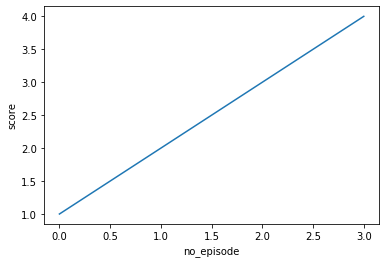

In [3]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.xlabel('no_episode')
plt.ylabel('score')
plt.show()

In [1]:
a = [10,12,14]

In [2]:
for i, x in enumerate(a):
    print(i)
    print(x)

0
10
1
12
2
14


In [ ]:
for i, phrase_mode in enumerate(phrase_modes):
    plt.plot(tr_x, training_scores[i], label=phrase_mode)

In [17]:

import requests


In [19]:
r = requests.post(
    "https://api.deepai.org/api/densecap",
    files={
        'image': open('image.jpg', 'rb'),
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
print(r.json())

{'output': {'captions': [{'caption': 'a banana is in the photo', 'bounding_box': [31, 1, 190, 212], 'confidence': 0.9975239634513855}, {'caption': 'the womans hair is brown', 'bounding_box': [46, 0, 136, 96], 'confidence': 0.9717059135437012}, {'caption': 'a yellow banana', 'bounding_box': [119, 85, 89, 128], 'confidence': 0.9130056500434875}, {'caption': 'a white wall', 'bounding_box': [168, 0, 133, 214], 'confidence': 0.8637468814849854}, {'caption': 'a yellow banana', 'bounding_box': [1, 112, 124, 101], 'confidence': 0.8614827990531921}, {'caption': 'the mans mouth is open', 'bounding_box': [81, 139, 70, 73], 'confidence': 0.8561619520187378}, {'caption': 'the word <unk>', 'bounding_box': [234, 80, 65, 59], 'confidence': 0.8088706135749817}, {'caption': 'the banana is yellow', 'bounding_box': [34, 126, 49, 87], 'confidence': 0.7804918885231018}, {'caption': 'the eyes are brown', 'bounding_box': [45, 45, 116, 38], 'confidence': 0.76678866147995}, {'caption': 'the wall is yellow', 'bo